> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [2]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#tf.logging.set_verbosity(tf.logging.ERROR)

In [18]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32, name="D_a")#tf.Variable([1.0], dtype=tf.float32, 
                                   #name="D_a", 
                                   #constraint= lambda z: tf.clip_by_value(z, 1e-10, 1e10))#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-10, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.constant(0.0, dtype=tf.float32, name="sigma_a")#tf.Variable([0.0], dtype=tf.float32)#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.constant(0.02, dtype=tf.float32, name="rho_s")#tf.Variable([1.00], dtype=tf.float32, 
                                     #name="rho_s",
                                    #constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#
            self.kappa_a = tf.constant(0.25, dtype=tf.float32)#tf.Variable([1.00], dtype=tf.float32,name="kappa_a")#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")

        self.loss = self.loss_1 + self.loss_a + self.loss_s        

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train(self, nIter, early_stop_thresh = None, print_iter = 100): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
        
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a, self.D_s,
                                          self.sigma_a, self.sigma_s,
                                          self.rho_a, self.rho_s,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [19]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [20]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
model.train(100000, early_stop_thresh=32.0, print_iter=100)

It: 0, loss_a  : 46.68553925, loss_s  : 32700.52929688, loss  : 125474.59,
D_a: 0.004999999888241291, D_s: [0.9990100264549255]
sigma_a: 0.0, sigma_s: [0.9990000128746033]
rho_a: [0.9990000128746033], rho_s: 0.019999999552965164
mu_a: [0.9990000128746033], kappa_a: 0.25, 
Time:3.64

It: 100, loss_a  : 40.42076874, loss_s  : 25373.85937500, loss  : 35331.53,
D_a: 0.004999999888241291, D_s: [1.1031347513198853]
sigma_a: 0.0, sigma_s: [0.9012414216995239]
rho_a: [0.9904515743255615], rho_s: 0.019999999552965164
mu_a: [0.9972004294395447], kappa_a: 0.25, 
Time:100.60

It: 200, loss_a  : 12.94083214, loss_s  : 20296.94140625, loss  : 30225.22,
D_a: 0.004999999888241291, D_s: [1.1928547620773315]
sigma_a: 0.0, sigma_s: [0.8084209561347961]
rho_a: [0.9789767265319824], rho_s: 0.019999999552965164
mu_a: [1.0103468894958496], kappa_a: 0.25, 
Time:100.71

It: 300, loss_a  : 9.00233459, loss_s  : 16028.40039062, loss  : 25952.76,
D_a: 0.004999999888241291, D_s: [1.2715708017349243]
sigma_a: 0.0, 

It: 2900, loss_a  : 4.50886536, loss_s  : 0.08503002, loss  : 9837.89,
D_a: 0.004999999888241291, D_s: [1.7602900266647339]
sigma_a: 0.0, sigma_s: [0.02080620639026165]
rho_a: [0.976426899433136], rho_s: 0.019999999552965164
mu_a: [0.9954016208648682], kappa_a: 0.25, 
Time:100.55

It: 3000, loss_a  : 3.25913095, loss_s  : 0.09439284, loss  : 9828.82,
D_a: 0.004999999888241291, D_s: [1.757468342781067]
sigma_a: 0.0, sigma_s: [0.02066781371831894]
rho_a: [0.9759117960929871], rho_s: 0.019999999552965164
mu_a: [0.9948753714561462], kappa_a: 0.25, 
Time:100.77

It: 3100, loss_a  : 3.05484009, loss_s  : 0.09092021, loss  : 9828.37,
D_a: 0.004999999888241291, D_s: [1.7543580532073975]
sigma_a: 0.0, sigma_s: [0.020586054772138596]
rho_a: [0.975416898727417], rho_s: 0.019999999552965164
mu_a: [0.9943435788154602], kappa_a: 0.25, 
Time:100.80

It: 3200, loss_a  : 2.91974878, loss_s  : 0.08938396, loss  : 9827.89,
D_a: 0.004999999888241291, D_s: [1.7510353326797485]
sigma_a: 0.0, sigma_s: [0.020

It: 5800, loss_a  : 3.90512323, loss_s  : 0.11398851, loss  : 9732.85,
D_a: 0.004999999888241291, D_s: [1.5401580333709717]
sigma_a: 0.0, sigma_s: [0.02076820656657219]
rho_a: [0.945756733417511], rho_s: 0.019999999552965164
mu_a: [0.9635146260261536], kappa_a: 0.25, 
Time:100.77

It: 5900, loss_a  : 3.40190649, loss_s  : 0.12343499, loss  : 9731.46,
D_a: 0.004999999888241291, D_s: [1.518928050994873]
sigma_a: 0.0, sigma_s: [0.020827071741223335]
rho_a: [0.9449623227119446], rho_s: 0.019999999552965164
mu_a: [0.9622014760971069], kappa_a: 0.25, 
Time:100.85

It: 6000, loss_a  : 10.69943428, loss_s  : 0.14714387, loss  : 9752.07,
D_a: 0.004999999888241291, D_s: [1.4960033893585205]
sigma_a: 0.0, sigma_s: [0.020876675844192505]
rho_a: [0.9435893297195435], rho_s: 0.019999999552965164
mu_a: [0.9614318013191223], kappa_a: 0.25, 
Time:100.65

It: 6100, loss_a  : 3.55504298, loss_s  : 0.13044624, loss  : 9712.39,
D_a: 0.004999999888241291, D_s: [1.4698737859725952]
sigma_a: 0.0, sigma_s: [0.

It: 8700, loss_a  : 100.30153656, loss_s  : 1.39170718, loss  : 4979.40,
D_a: 0.004999999888241291, D_s: [0.05634064972400665]
sigma_a: 0.0, sigma_s: [0.02006460167467594]
rho_a: [0.7335323691368103], rho_s: 0.019999999552965164
mu_a: [0.7458770871162415], kappa_a: 0.25, 
Time:100.50

It: 8800, loss_a  : 99.08921051, loss_s  : 1.64733624, loss  : 4612.98,
D_a: 0.004999999888241291, D_s: [0.048513077199459076]
sigma_a: 0.0, sigma_s: [0.020032986998558044]
rho_a: [0.7007870078086853], rho_s: 0.019999999552965164
mu_a: [0.7135315537452698], kappa_a: 0.25, 
Time:100.71

It: 8900, loss_a  : 95.66577911, loss_s  : 1.72764003, loss  : 4262.62,
D_a: 0.004999999888241291, D_s: [0.050529468804597855]
sigma_a: 0.0, sigma_s: [0.019968662410974503]
rho_a: [0.6663783192634583], rho_s: 0.019999999552965164
mu_a: [0.6788583993911743], kappa_a: 0.25, 
Time:100.84

It: 9000, loss_a  : 87.24065399, loss_s  : 1.74981570, loss  : 3904.91,
D_a: 0.004999999888241291, D_s: [0.05692634731531143]
sigma_a: 0.0, 

It: 11600, loss_a  : 0.10491456, loss_s  : 2.80356455, loss  : 3187.85,
D_a: 0.004999999888241291, D_s: [0.10318750143051147]
sigma_a: 0.0, sigma_s: [0.020030543208122253]
rho_a: [0.02209203876554966], rho_s: 0.019999999552965164
mu_a: [0.022569455206394196], kappa_a: 0.25, 
Time:100.78

It: 11700, loss_a  : 0.06612776, loss_s  : 2.06019068, loss  : 965.94,
D_a: 0.004999999888241291, D_s: [0.10901223123073578]
sigma_a: 0.0, sigma_s: [0.020087214186787605]
rho_a: [0.01845100335776806], rho_s: 0.019999999552965164
mu_a: [0.018846619874238968], kappa_a: 0.25, 
Time:100.85

It: 11800, loss_a  : 0.04864609, loss_s  : 2.01445293, loss  : 909.42,
D_a: 0.004999999888241291, D_s: [0.1118924543261528]
sigma_a: 0.0, sigma_s: [0.020089464262127876]
rho_a: [0.015722043812274933], rho_s: 0.019999999552965164
mu_a: [0.015993038192391396], kappa_a: 0.25, 
Time:100.74

It: 11900, loss_a  : 0.03657096, loss_s  : 1.97992325, loss  : 892.99,
D_a: 0.004999999888241291, D_s: [0.11432676017284393]
sigma_a: 0

It: 14500, loss_a  : 0.01698058, loss_s  : 1.47046947, loss  : 95.81,
D_a: 0.004999999888241291, D_s: [0.1497109979391098]
sigma_a: 0.0, sigma_s: [0.02005781978368759]
rho_a: [0.008396599441766739], rho_s: 0.019999999552965164
mu_a: [0.008338945917785168], kappa_a: 0.25, 
Time:100.69

It: 14600, loss_a  : 0.01695292, loss_s  : 1.45693898, loss  : 95.60,
D_a: 0.004999999888241291, D_s: [0.15051992237567902]
sigma_a: 0.0, sigma_s: [0.020060129463672638]
rho_a: [0.008383533917367458], rho_s: 0.019999999552965164
mu_a: [0.008326058275997639], kappa_a: 0.25, 
Time:100.82

It: 14700, loss_a  : 0.01644232, loss_s  : 1.43245661, loss  : 92.10,
D_a: 0.004999999888241291, D_s: [0.15175028145313263]
sigma_a: 0.0, sigma_s: [0.020054269582033157]
rho_a: [0.00836559571325779], rho_s: 0.019999999552965164
mu_a: [0.00830786395817995], kappa_a: 0.25, 
Time:100.94

It: 14800, loss_a  : 0.01816387, loss_s  : 1.67112398, loss  : 906.73,
D_a: 0.004999999888241291, D_s: [0.15067124366760254]
sigma_a: 0.0, s

It: 17400, loss_a  : 0.01356148, loss_s  : 1.08874822, loss  : 165.82,
D_a: 0.004999999888241291, D_s: [0.1696486473083496]
sigma_a: 0.0, sigma_s: [0.020086947828531265]
rho_a: [0.00826561450958252], rho_s: 0.019999999552965164
mu_a: [0.00827659759670496], kappa_a: 0.25, 
Time:100.87

It: 17500, loss_a  : 0.01283118, loss_s  : 1.06002951, loss  : 90.96,
D_a: 0.004999999888241291, D_s: [0.17060671746730804]
sigma_a: 0.0, sigma_s: [0.02008543722331524]
rho_a: [0.008331187069416046], rho_s: 0.019999999552965164
mu_a: [0.008287530392408371], kappa_a: 0.25, 
Time:100.91

It: 17600, loss_a  : 0.01190943, loss_s  : 1.02863979, loss  : 64.21,
D_a: 0.004999999888241291, D_s: [0.17122212052345276]
sigma_a: 0.0, sigma_s: [0.020059455186128616]
rho_a: [0.008339008316397667], rho_s: 0.019999999552965164
mu_a: [0.008283224888145924], kappa_a: 0.25, 
Time:100.89

It: 17700, loss_a  : 0.01188685, loss_s  : 1.02165723, loss  : 63.49,
D_a: 0.004999999888241291, D_s: [0.17154063284397125]
sigma_a: 0.0, s

It: 20300, loss_a  : 0.00963750, loss_s  : 0.81740952, loss  : 51.09,
D_a: 0.004999999888241291, D_s: [0.1807919442653656]
sigma_a: 0.0, sigma_s: [0.020098578184843063]
rho_a: [0.008347218856215477], rho_s: 0.019999999552965164
mu_a: [0.008294527418911457], kappa_a: 0.25, 
Time:100.83

It: 20400, loss_a  : 0.00951068, loss_s  : 0.81058192, loss  : 50.88,
D_a: 0.004999999888241291, D_s: [0.1810573786497116]
sigma_a: 0.0, sigma_s: [0.020099902525544167]
rho_a: [0.008346912451088428], rho_s: 0.019999999552965164
mu_a: [0.00829000398516655], kappa_a: 0.25, 
Time:100.72

It: 20500, loss_a  : 0.00957470, loss_s  : 0.80439305, loss  : 53.41,
D_a: 0.004999999888241291, D_s: [0.17922905087471008]
sigma_a: 0.0, sigma_s: [0.020122775807976723]
rho_a: [0.008326360024511814], rho_s: 0.019999999552965164
mu_a: [0.00822356529533863], kappa_a: 0.25, 
Time:100.92

It: 20600, loss_a  : 0.00940513, loss_s  : 0.79863381, loss  : 49.91,
D_a: 0.004999999888241291, D_s: [0.18156550824642181]
sigma_a: 0.0, si

It: 23200, loss_a  : 0.00800804, loss_s  : 0.71174479, loss  : 81.02,
D_a: 0.004999999888241291, D_s: [0.18613456189632416]
sigma_a: 0.0, sigma_s: [0.020097211003303528]
rho_a: [0.008353552781045437], rho_s: 0.019999999552965164
mu_a: [0.008249384351074696], kappa_a: 0.25, 
Time:100.78

It: 23300, loss_a  : 0.00785537, loss_s  : 0.67817581, loss  : 39.86,
D_a: 0.004999999888241291, D_s: [0.1862628310918808]
sigma_a: 0.0, sigma_s: [0.02013099007308483]
rho_a: [0.008436637930572033], rho_s: 0.019999999552965164
mu_a: [0.008392687886953354], kappa_a: 0.25, 
Time:100.84

It: 23400, loss_a  : 0.00783300, loss_s  : 0.67348707, loss  : 39.49,
D_a: 0.004999999888241291, D_s: [0.18642926216125488]
sigma_a: 0.0, sigma_s: [0.020134013146162033]
rho_a: [0.008440084755420685], rho_s: 0.019999999552965164
mu_a: [0.008398081175982952], kappa_a: 0.25, 
Time:100.78

It: 23500, loss_a  : 0.00772055, loss_s  : 0.66923445, loss  : 39.24,
D_a: 0.004999999888241291, D_s: [0.18655438721179962]
sigma_a: 0.0, 

In [24]:
model.minimise(max_iter=1000)   

loss: 31.920713424682617, loss_a: 0.0067017897963523865, loss_s: 0.5960355997085571,
D_a: 0.004999999888241291, D_s: [0.18885745108127594]
sigma_a: 0.0, sigma_s: [0.02015220932662487]
rho_a: [0.00850970484316349], rho_s: 0.019999999552965164
mu_a: [0.008471012115478516], kappa_a: 0.25

loss: 1874299.875, loss_a: 629.5072021484375, loss_s: 1142.80419921875,
D_a: 0.004999999888241291, D_s: [0.18890206515789032]
sigma_a: 0.0, sigma_s: [0.021106092259287834]
rho_a: [0.008465633727610111], rho_s: 0.019999999552965164
mu_a: [0.008540081791579723], kappa_a: 0.25

loss: 31.85318374633789, loss_a: 0.006703190505504608, loss_s: 0.5959106683731079,
D_a: 0.004999999888241291, D_s: [0.18885745108127594]
sigma_a: 0.0, sigma_s: [0.020152347162365913]
rho_a: [0.008509698323905468], rho_s: 0.019999999552965164
mu_a: [0.008471022360026836], kappa_a: 0.25

loss: 31.852535247802734, loss_a: 0.006703201215714216, loss_s: 0.5959124565124512,
D_a: 0.004999999888241291, D_s: [0.18885746598243713]
sigma_a: 0.0

loss: 31.578224182128906, loss_a: 0.006713650189340115, loss_s: 0.5942857265472412,
D_a: 0.004999999888241291, D_s: [0.18890507519245148]
sigma_a: 0.0, sigma_s: [0.0201563723385334]
rho_a: [0.008525634184479713], rho_s: 0.019999999552965164
mu_a: [0.008487899787724018], kappa_a: 0.25

loss: 31.561328887939453, loss_a: 0.006711927242577076, loss_s: 0.5942317247390747,
D_a: 0.004999999888241291, D_s: [0.18890754878520966]
sigma_a: 0.0, sigma_s: [0.020158471539616585]
rho_a: [0.008526361547410488], rho_s: 0.019999999552965164
mu_a: [0.008488744497299194], kappa_a: 0.25

loss: 31.52385139465332, loss_a: 0.00670992024242878, loss_s: 0.5940999388694763,
D_a: 0.004999999888241291, D_s: [0.18891541659832]
sigma_a: 0.0, sigma_s: [0.02016487903892994]
rho_a: [0.008528565056622028], rho_s: 0.019999999552965164
mu_a: [0.008491509594023228], kappa_a: 0.25

loss: 31.491352081298828, loss_a: 0.006706463173031807, loss_s: 0.5939388275146484,
D_a: 0.004999999888241291, D_s: [0.18892492353916168]
sigma_

loss: 29.76908302307129, loss_a: 0.006540342699736357, loss_s: 0.5723341703414917,
D_a: 0.004999999888241291, D_s: [0.18946929275989532]
sigma_a: 0.0, sigma_s: [0.020167505368590355]
rho_a: [0.008651738055050373], rho_s: 0.019999999552965164
mu_a: [0.008622199296951294], kappa_a: 0.25

loss: 29.72696304321289, loss_a: 0.0065215881913900375, loss_s: 0.5713595151901245,
D_a: 0.004999999888241291, D_s: [0.1894942820072174]
sigma_a: 0.0, sigma_s: [0.02017471380531788]
rho_a: [0.008656052872538567], rho_s: 0.019999999552965164
mu_a: [0.008626951836049557], kappa_a: 0.25

loss: 29.68756866455078, loss_a: 0.006536138243973255, loss_s: 0.5717372894287109,
D_a: 0.004999999888241291, D_s: [0.1894940435886383]
sigma_a: 0.0, sigma_s: [0.02017955482006073]
rho_a: [0.008654818870127201], rho_s: 0.019999999552965164
mu_a: [0.008625342510640621], kappa_a: 0.25

loss: 29.6495418548584, loss_a: 0.00653435755521059, loss_s: 0.5716110467910767,
D_a: 0.004999999888241291, D_s: [0.1895076036453247]
sigma_a:

loss: 28.18865203857422, loss_a: 0.006293660495430231, loss_s: 0.5536775588989258,
D_a: 0.004999999888241291, D_s: [0.19013965129852295]
sigma_a: 0.0, sigma_s: [0.020195070654153824]
rho_a: [0.008726104162633419], rho_s: 0.019999999552965164
mu_a: [0.008696402423083782], kappa_a: 0.25

loss: 28.128318786621094, loss_a: 0.006280702538788319, loss_s: 0.553004264831543,
D_a: 0.004999999888241291, D_s: [0.19016796350479126]
sigma_a: 0.0, sigma_s: [0.020182790234684944]
rho_a: [0.008727524429559708], rho_s: 0.019999999552965164
mu_a: [0.00869853887706995], kappa_a: 0.25

loss: 28.0782413482666, loss_a: 0.006276614498347044, loss_s: 0.5523025393486023,
D_a: 0.004999999888241291, D_s: [0.19018207490444183]
sigma_a: 0.0, sigma_s: [0.02017461694777012]
rho_a: [0.00872610229998827], rho_s: 0.019999999552965164
mu_a: [0.008698131889104843], kappa_a: 0.25

loss: 28.009801864624023, loss_a: 0.006266742013394833, loss_s: 0.551173746585846,
D_a: 0.004999999888241291, D_s: [0.19020132720470428]
sigma_

loss: 26.8524169921875, loss_a: 0.006121654529124498, loss_s: 0.5445283651351929,
D_a: 0.004999999888241291, D_s: [0.190766379237175]
sigma_a: 0.0, sigma_s: [0.020175650715827942]
rho_a: [0.008708908222615719], rho_s: 0.019999999552965164
mu_a: [0.008680395781993866], kappa_a: 0.25

loss: 26.786272048950195, loss_a: 0.006111019290983677, loss_s: 0.5437757968902588,
D_a: 0.004999999888241291, D_s: [0.19078049063682556]
sigma_a: 0.0, sigma_s: [0.020182128995656967]
rho_a: [0.008703197352588177], rho_s: 0.019999999552965164
mu_a: [0.008672467432916164], kappa_a: 0.25

loss: 26.838071823120117, loss_a: 0.0061004022136330605, loss_s: 0.5420334935188293,
D_a: 0.004999999888241291, D_s: [0.19084195792675018]
sigma_a: 0.0, sigma_s: [0.020184943452477455]
rho_a: [0.008701788261532784], rho_s: 0.019999999552965164
mu_a: [0.008665437810122967], kappa_a: 0.25

loss: 26.757280349731445, loss_a: 0.0061065093614161015, loss_s: 0.5430964231491089,
D_a: 0.004999999888241291, D_s: [0.19080352783203125]


loss: 25.560808181762695, loss_a: 0.0059683858416974545, loss_s: 0.5325928926467896,
D_a: 0.004999999888241291, D_s: [0.19120387732982635]
sigma_a: 0.0, sigma_s: [0.020189721137285233]
rho_a: [0.008656267076730728], rho_s: 0.019999999552965164
mu_a: [0.008614336140453815], kappa_a: 0.25

loss: 25.513134002685547, loss_a: 0.0059515140019357204, loss_s: 0.5319306254386902,
D_a: 0.004999999888241291, D_s: [0.19124163687229156]
sigma_a: 0.0, sigma_s: [0.020189722999930382]
rho_a: [0.00865190289914608], rho_s: 0.019999999552965164
mu_a: [0.008615744300186634], kappa_a: 0.25

loss: 25.48092269897461, loss_a: 0.005937379319220781, loss_s: 0.5314170122146606,
D_a: 0.004999999888241291, D_s: [0.19125720858573914]
sigma_a: 0.0, sigma_s: [0.020189518108963966]
rho_a: [0.008646884001791477], rho_s: 0.019999999552965164
mu_a: [0.008615914732217789], kappa_a: 0.25

loss: 25.434234619140625, loss_a: 0.005916999187320471, loss_s: 0.5304261445999146,
D_a: 0.004999999888241291, D_s: [0.19127601385116577

loss: 24.500410079956055, loss_a: 0.005643648095428944, loss_s: 0.5172731876373291,
D_a: 0.004999999888241291, D_s: [0.19158263504505157]
sigma_a: 0.0, sigma_s: [0.02023749239742756]
rho_a: [0.008603637106716633], rho_s: 0.019999999552965164
mu_a: [0.00857805460691452], kappa_a: 0.25

loss: 24.47165870666504, loss_a: 0.005640850402414799, loss_s: 0.5175750851631165,
D_a: 0.004999999888241291, D_s: [0.191565603017807]
sigma_a: 0.0, sigma_s: [0.02023247815668583]
rho_a: [0.008604236878454685], rho_s: 0.019999999552965164
mu_a: [0.008580554276704788], kappa_a: 0.25

loss: 24.439300537109375, loss_a: 0.00564299151301384, loss_s: 0.5175917148590088,
D_a: 0.004999999888241291, D_s: [0.1915682703256607]
sigma_a: 0.0, sigma_s: [0.020233342424035072]
rho_a: [0.008604510687291622], rho_s: 0.019999999552965164
mu_a: [0.008579055778682232], kappa_a: 0.25

loss: 24.40462303161621, loss_a: 0.00564356055110693, loss_s: 0.5176144242286682,
D_a: 0.004999999888241291, D_s: [0.19157223403453827]
sigma_a:

loss: 23.529525756835938, loss_a: 0.005537586286664009, loss_s: 0.5090654492378235,
D_a: 0.004999999888241291, D_s: [0.19179944694042206]
sigma_a: 0.0, sigma_s: [0.020202910527586937]
rho_a: [0.00859125703573227], rho_s: 0.019999999552965164
mu_a: [0.008559814654290676], kappa_a: 0.25

loss: 23.497806549072266, loss_a: 0.005536152049899101, loss_s: 0.5084058046340942,
D_a: 0.004999999888241291, D_s: [0.19181010127067566]
sigma_a: 0.0, sigma_s: [0.020194943994283676]
rho_a: [0.008588719181716442], rho_s: 0.019999999552965164
mu_a: [0.008565652184188366], kappa_a: 0.25

loss: 23.46895980834961, loss_a: 0.005528237204998732, loss_s: 0.5082508325576782,
D_a: 0.004999999888241291, D_s: [0.19181711971759796]
sigma_a: 0.0, sigma_s: [0.020198030397295952]
rho_a: [0.008589988574385643], rho_s: 0.019999999552965164
mu_a: [0.008563853800296783], kappa_a: 0.25

loss: 23.4477481842041, loss_a: 0.00551439356058836, loss_s: 0.5078696608543396,
D_a: 0.004999999888241291, D_s: [0.19182944297790527]
sig

loss: 22.803466796875, loss_a: 0.0053557343780994415, loss_s: 0.5006433725357056,
D_a: 0.004999999888241291, D_s: [0.19178465008735657]
sigma_a: 0.0, sigma_s: [0.020242761820554733]
rho_a: [0.00863886158913374], rho_s: 0.019999999552965164
mu_a: [0.008605346083641052], kappa_a: 0.25

loss: 22.78196907043457, loss_a: 0.0053461636416614056, loss_s: 0.5002888441085815,
D_a: 0.004999999888241291, D_s: [0.19178538024425507]
sigma_a: 0.0, sigma_s: [0.02024269662797451]
rho_a: [0.00863918662071228], rho_s: 0.019999999552965164
mu_a: [0.008604696951806545], kappa_a: 0.25

loss: 22.74166488647461, loss_a: 0.005335519090294838, loss_s: 0.4999333620071411,
D_a: 0.004999999888241291, D_s: [0.19178004562854767]
sigma_a: 0.0, sigma_s: [0.020238691940903664]
rho_a: [0.008639038540422916], rho_s: 0.019999999552965164
mu_a: [0.008606093004345894], kappa_a: 0.25

loss: 22.71539306640625, loss_a: 0.005333121865987778, loss_s: 0.4998825490474701,
D_a: 0.004999999888241291, D_s: [0.19177241623401642]
sigma

loss: 22.048002243041992, loss_a: 0.005239877849817276, loss_s: 0.49183183908462524,
D_a: 0.004999999888241291, D_s: [0.19168773293495178]
sigma_a: 0.0, sigma_s: [0.020226407796144485]
rho_a: [0.00870492309331894], rho_s: 0.019999999552965164
mu_a: [0.008681412786245346], kappa_a: 0.25

loss: 22.0235595703125, loss_a: 0.005238592624664307, loss_s: 0.49153512716293335,
D_a: 0.004999999888241291, D_s: [0.19168362021446228]
sigma_a: 0.0, sigma_s: [0.020228592678904533]
rho_a: [0.00870620459318161], rho_s: 0.019999999552965164
mu_a: [0.008683511056005955], kappa_a: 0.25

loss: 21.991024017333984, loss_a: 0.005233758594840765, loss_s: 0.4907989501953125,
D_a: 0.004999999888241291, D_s: [0.19167768955230713]
sigma_a: 0.0, sigma_s: [0.020232049748301506]
rho_a: [0.008711344562470913], rho_s: 0.019999999552965164
mu_a: [0.008687173947691917], kappa_a: 0.25

loss: 21.973697662353516, loss_a: 0.005230125971138477, loss_s: 0.49053841829299927,
D_a: 0.004999999888241291, D_s: [0.19167448580265045]

loss: 21.33574104309082, loss_a: 0.0050704446621239185, loss_s: 0.48043808341026306,
D_a: 0.004999999888241291, D_s: [0.19161903858184814]
sigma_a: 0.0, sigma_s: [0.020231029018759727]
rho_a: [0.008799394592642784], rho_s: 0.019999999552965164
mu_a: [0.008772838860750198], kappa_a: 0.25

loss: 21.312864303588867, loss_a: 0.005069764330983162, loss_s: 0.4799255132675171,
D_a: 0.004999999888241291, D_s: [0.19161474704742432]
sigma_a: 0.0, sigma_s: [0.020222803577780724]
rho_a: [0.008800918236374855], rho_s: 0.019999999552965164
mu_a: [0.008777128532528877], kappa_a: 0.25

loss: 21.294570922851562, loss_a: 0.005066552199423313, loss_s: 0.47949662804603577,
D_a: 0.004999999888241291, D_s: [0.19161272048950195]
sigma_a: 0.0, sigma_s: [0.020215360447764397]
rho_a: [0.008802385069429874], rho_s: 0.019999999552965164
mu_a: [0.008780664764344692], kappa_a: 0.25

loss: 21.255672454833984, loss_a: 0.005059397779405117, loss_s: 0.4786936044692993,
D_a: 0.004999999888241291, D_s: [0.191609904170036

loss: 20.52705192565918, loss_a: 0.0048646689392626286, loss_s: 0.46654030680656433,
D_a: 0.004999999888241291, D_s: [0.1917380541563034]
sigma_a: 0.0, sigma_s: [0.02021448127925396]
rho_a: [0.008847715333104134], rho_s: 0.019999999552965164
mu_a: [0.008825630880892277], kappa_a: 0.25

loss: 20.504064559936523, loss_a: 0.004864413291215897, loss_s: 0.46653515100479126,
D_a: 0.004999999888241291, D_s: [0.19174101948738098]
sigma_a: 0.0, sigma_s: [0.020212508738040924]
rho_a: [0.008848884142935276], rho_s: 0.019999999552965164
mu_a: [0.008828755468130112], kappa_a: 0.25

loss: 20.483335494995117, loss_a: 0.004859817214310169, loss_s: 0.466330885887146,
D_a: 0.004999999888241291, D_s: [0.19174443185329437]
sigma_a: 0.0, sigma_s: [0.020211903378367424]
rho_a: [0.008850116282701492], rho_s: 0.019999999552965164
mu_a: [0.008830210193991661], kappa_a: 0.25

loss: 20.435155868530273, loss_a: 0.004843882285058498, loss_s: 0.465354859828949,
D_a: 0.004999999888241291, D_s: [0.1917564421892166]
s

loss: 19.84811019897461, loss_a: 0.00473339669406414, loss_s: 0.45715412497520447,
D_a: 0.004999999888241291, D_s: [0.1918904185295105]
sigma_a: 0.0, sigma_s: [0.020197458565235138]
rho_a: [0.008896955288946629], rho_s: 0.019999999552965164
mu_a: [0.008868182078003883], kappa_a: 0.25

loss: 19.822858810424805, loss_a: 0.004727279767394066, loss_s: 0.4565699100494385,
D_a: 0.004999999888241291, D_s: [0.19190163910388947]
sigma_a: 0.0, sigma_s: [0.020190458744764328]
rho_a: [0.008896304294466972], rho_s: 0.019999999552965164
mu_a: [0.008868920616805553], kappa_a: 0.25

loss: 19.804550170898438, loss_a: 0.004726526327431202, loss_s: 0.45677247643470764,
D_a: 0.004999999888241291, D_s: [0.19189821183681488]
sigma_a: 0.0, sigma_s: [0.020192040130496025]
rho_a: [0.008893223479390144], rho_s: 0.019999999552965164
mu_a: [0.008869745768606663], kappa_a: 0.25

loss: 19.788190841674805, loss_a: 0.00472386134788394, loss_s: 0.4567541480064392,
D_a: 0.004999999888241291, D_s: [0.1918996423482895]
s

loss: 19.367355346679688, loss_a: 0.004657570272684097, loss_s: 0.45501279830932617,
D_a: 0.004999999888241291, D_s: [0.19214767217636108]
sigma_a: 0.0, sigma_s: [0.02019251324236393]
rho_a: [0.008873406797647476], rho_s: 0.019999999552965164
mu_a: [0.008853232488036156], kappa_a: 0.25

loss: 19.344757080078125, loss_a: 0.0046449704095721245, loss_s: 0.4544483423233032,
D_a: 0.004999999888241291, D_s: [0.1921662539243698]
sigma_a: 0.0, sigma_s: [0.020193049684166908]
rho_a: [0.00887316558510065], rho_s: 0.019999999552965164
mu_a: [0.0088531244546175], kappa_a: 0.25

loss: 19.41732406616211, loss_a: 0.004636011086404324, loss_s: 0.4533841609954834,
D_a: 0.004999999888241291, D_s: [0.1922101080417633]
sigma_a: 0.0, sigma_s: [0.02019011601805687]
rho_a: [0.008870266377925873], rho_s: 0.019999999552965164
mu_a: [0.008861544542014599], kappa_a: 0.25

loss: 19.337505340576172, loss_a: 0.004640811122953892, loss_s: 0.45418351888656616,
D_a: 0.004999999888241291, D_s: [0.19217640161514282]
sig

loss: 18.935592651367188, loss_a: 0.004584575537592173, loss_s: 0.45170319080352783,
D_a: 0.004999999888241291, D_s: [0.19264118373394012]
sigma_a: 0.0, sigma_s: [0.02019748091697693]
rho_a: [0.008839812129735947], rho_s: 0.019999999552965164
mu_a: [0.008814327418804169], kappa_a: 0.25

loss: 18.91200828552246, loss_a: 0.004587922245264053, loss_s: 0.4520556330680847,
D_a: 0.004999999888241291, D_s: [0.1926780641078949]
sigma_a: 0.0, sigma_s: [0.02020576037466526]
rho_a: [0.008835925720632076], rho_s: 0.019999999552965164
mu_a: [0.008812122978270054], kappa_a: 0.25

loss: 18.954944610595703, loss_a: 0.0046071442775428295, loss_s: 0.4529578387737274,
D_a: 0.004999999888241291, D_s: [0.1927507072687149]
sigma_a: 0.0, sigma_s: [0.0202203206717968]
rho_a: [0.008826587349176407], rho_s: 0.019999999552965164
mu_a: [0.008798529393970966], kappa_a: 0.25

loss: 18.89874267578125, loss_a: 0.004593550693243742, loss_s: 0.45233145356178284,
D_a: 0.004999999888241291, D_s: [0.19270183145999908]
sig

loss: 18.494895935058594, loss_a: 0.004516907501965761, loss_s: 0.45007041096687317,
D_a: 0.004999999888241291, D_s: [0.19326789677143097]
sigma_a: 0.0, sigma_s: [0.020219655707478523]
rho_a: [0.008781621232628822], rho_s: 0.019999999552965164
mu_a: [0.00876998994499445], kappa_a: 0.25

loss: 18.48297691345215, loss_a: 0.004518311470746994, loss_s: 0.4502109885215759,
D_a: 0.004999999888241291, D_s: [0.19324547052383423]
sigma_a: 0.0, sigma_s: [0.02021849900484085]
rho_a: [0.008784177713096142], rho_s: 0.019999999552965164
mu_a: [0.008769632317125797], kappa_a: 0.25

loss: 18.465967178344727, loss_a: 0.0045183077454566956, loss_s: 0.45029258728027344,
D_a: 0.004999999888241291, D_s: [0.1932401955127716]
sigma_a: 0.0, sigma_s: [0.020217206329107285]
rho_a: [0.008787872269749641], rho_s: 0.019999999552965164
mu_a: [0.00876670517027378], kappa_a: 0.25

loss: 18.454708099365234, loss_a: 0.004519074689596891, loss_s: 0.450370728969574,
D_a: 0.004999999888241291, D_s: [0.19324161112308502]
s

loss: 18.107648849487305, loss_a: 0.004469852428883314, loss_s: 0.44776517152786255,
D_a: 0.004999999888241291, D_s: [0.19373778998851776]
sigma_a: 0.0, sigma_s: [0.02019301988184452]
rho_a: [0.008753267116844654], rho_s: 0.019999999552965164
mu_a: [0.008730843663215637], kappa_a: 0.25

loss: 18.089033126831055, loss_a: 0.004469927400350571, loss_s: 0.44772738218307495,
D_a: 0.004999999888241291, D_s: [0.1937469244003296]
sigma_a: 0.0, sigma_s: [0.020190676674246788]
rho_a: [0.00875422079116106], rho_s: 0.019999999552965164
mu_a: [0.00872950628399849], kappa_a: 0.25

loss: 18.07294464111328, loss_a: 0.0044669946655631065, loss_s: 0.4474892318248749,
D_a: 0.004999999888241291, D_s: [0.1937892884016037]
sigma_a: 0.0, sigma_s: [0.020186150446534157]
rho_a: [0.008753896690905094], rho_s: 0.019999999552965164
mu_a: [0.008726897649466991], kappa_a: 0.25

loss: 18.05521583557129, loss_a: 0.004465941339731216, loss_s: 0.44730931520462036,
D_a: 0.004999999888241291, D_s: [0.19379472732543945]
s

loss: 17.5012149810791, loss_a: 0.004325131420046091, loss_s: 0.4448031783103943,
D_a: 0.004999999888241291, D_s: [0.19445696473121643]
sigma_a: 0.0, sigma_s: [0.020221726968884468]
rho_a: [0.00875395443290472], rho_s: 0.019999999552965164
mu_a: [0.008725842460989952], kappa_a: 0.25

loss: 17.460601806640625, loss_a: 0.004317469894886017, loss_s: 0.44506382942199707,
D_a: 0.004999999888241291, D_s: [0.19452325999736786]
sigma_a: 0.0, sigma_s: [0.020214784890413284]
rho_a: [0.008753648027777672], rho_s: 0.019999999552965164
mu_a: [0.008725310675799847], kappa_a: 0.25

loss: 17.43598747253418, loss_a: 0.0043106162920594215, loss_s: 0.4452050030231476,
D_a: 0.004999999888241291, D_s: [0.19458606839179993]
sigma_a: 0.0, sigma_s: [0.020203424617648125]
rho_a: [0.008753587491810322], rho_s: 0.019999999552965164
mu_a: [0.008726452477276325], kappa_a: 0.25

loss: 17.41082763671875, loss_a: 0.004305104725062847, loss_s: 0.44549715518951416,
D_a: 0.004999999888241291, D_s: [0.1946260631084442]
s

loss: 16.86334228515625, loss_a: 0.004237125627696514, loss_s: 0.4440005421638489,
D_a: 0.004999999888241291, D_s: [0.1948995590209961]
sigma_a: 0.0, sigma_s: [0.020167721435427666]
rho_a: [0.008779367431998253], rho_s: 0.019999999552965164
mu_a: [0.008767052553594112], kappa_a: 0.25

loss: 16.90357208251953, loss_a: 0.004222807474434376, loss_s: 0.4438944458961487,
D_a: 0.004999999888241291, D_s: [0.1949673295021057]
sigma_a: 0.0, sigma_s: [0.02017171122133732]
rho_a: [0.00878142099827528], rho_s: 0.019999999552965164
mu_a: [0.008765901438891888], kappa_a: 0.25

loss: 16.850208282470703, loss_a: 0.004231872968375683, loss_s: 0.44395285844802856,
D_a: 0.004999999888241291, D_s: [0.19492200016975403]
sigma_a: 0.0, sigma_s: [0.02016904205083847]
rho_a: [0.008780047297477722], rho_s: 0.019999999552965164
mu_a: [0.008766671642661095], kappa_a: 0.25

loss: 16.826435089111328, loss_a: 0.004229379817843437, loss_s: 0.44406938552856445,
D_a: 0.004999999888241291, D_s: [0.19492708146572113]
sig

loss: 16.28631591796875, loss_a: 0.004114954266697168, loss_s: 0.4407539367675781,
D_a: 0.004999999888241291, D_s: [0.19501283764839172]
sigma_a: 0.0, sigma_s: [0.02020455151796341]
rho_a: [0.008829822763800621], rho_s: 0.019999999552965164
mu_a: [0.008803986012935638], kappa_a: 0.25

loss: 16.274919509887695, loss_a: 0.004113819915801287, loss_s: 0.44063541293144226,
D_a: 0.004999999888241291, D_s: [0.195002943277359]
sigma_a: 0.0, sigma_s: [0.02019508183002472]
rho_a: [0.00883269589394331], rho_s: 0.019999999552965164
mu_a: [0.008806479163467884], kappa_a: 0.25

loss: 16.257516860961914, loss_a: 0.004110660403966904, loss_s: 0.4402688145637512,
D_a: 0.004999999888241291, D_s: [0.1949777454137802]
sigma_a: 0.0, sigma_s: [0.020182788372039795]
rho_a: [0.008835363201797009], rho_s: 0.019999999552965164
mu_a: [0.0088105583563447], kappa_a: 0.25

loss: 16.24142837524414, loss_a: 0.00410806480795145, loss_s: 0.43981143832206726,
D_a: 0.004999999888241291, D_s: [0.19494225084781647]
sigma_a

loss: 15.874818801879883, loss_a: 0.004087477922439575, loss_s: 0.4398001432418823,
D_a: 0.004999999888241291, D_s: [0.1948401778936386]
sigma_a: 0.0, sigma_s: [0.020133044570684433]
rho_a: [0.008867229335010052], rho_s: 0.019999999552965164
mu_a: [0.008847193792462349], kappa_a: 0.25

loss: 15.857725143432617, loss_a: 0.004087251611053944, loss_s: 0.4395562410354614,
D_a: 0.004999999888241291, D_s: [0.19482429325580597]
sigma_a: 0.0, sigma_s: [0.0201469287276268]
rho_a: [0.008866557851433754], rho_s: 0.019999999552965164
mu_a: [0.008852005936205387], kappa_a: 0.25

loss: 15.835439682006836, loss_a: 0.004089114256203175, loss_s: 0.4391385018825531,
D_a: 0.004999999888241291, D_s: [0.1947779357433319]
sigma_a: 0.0, sigma_s: [0.020186221227049828]
rho_a: [0.008868512697517872], rho_s: 0.019999999552965164
mu_a: [0.008857987821102142], kappa_a: 0.25

loss: 15.817662239074707, loss_a: 0.004090485163033009, loss_s: 0.43894222378730774,
D_a: 0.004999999888241291, D_s: [0.19476597011089325]
s

loss: 15.37302303314209, loss_a: 0.004014275036752224, loss_s: 0.43355363607406616,
D_a: 0.004999999888241291, D_s: [0.19437704980373383]
sigma_a: 0.0, sigma_s: [0.020199822261929512]
rho_a: [0.008909427560865879], rho_s: 0.019999999552965164
mu_a: [0.008897865191102028], kappa_a: 0.25

loss: 15.356815338134766, loss_a: 0.004009176045656204, loss_s: 0.43327459692955017,
D_a: 0.004999999888241291, D_s: [0.19435635209083557]
sigma_a: 0.0, sigma_s: [0.020168177783489227]
rho_a: [0.008913819678127766], rho_s: 0.019999999552965164
mu_a: [0.008898108266294003], kappa_a: 0.25

loss: 15.343999862670898, loss_a: 0.004004235379397869, loss_s: 0.43299418687820435,
D_a: 0.004999999888241291, D_s: [0.19431844353675842]
sigma_a: 0.0, sigma_s: [0.02010989747941494]
rho_a: [0.008919524028897285], rho_s: 0.019999999552965164
mu_a: [0.008897875435650349], kappa_a: 0.25

loss: 15.327363014221191, loss_a: 0.004003314301371574, loss_s: 0.4329626262187958,
D_a: 0.004999999888241291, D_s: [0.1943256855010986

loss: 14.900752067565918, loss_a: 0.003926172386854887, loss_s: 0.42689043283462524,
D_a: 0.004999999888241291, D_s: [0.19412639737129211]
sigma_a: 0.0, sigma_s: [0.020101848989725113]
rho_a: [0.008936727419495583], rho_s: 0.019999999552965164
mu_a: [0.008919475600123405], kappa_a: 0.25

loss: 14.88542366027832, loss_a: 0.003920082468539476, loss_s: 0.4264428913593292,
D_a: 0.004999999888241291, D_s: [0.19411878287792206]
sigma_a: 0.0, sigma_s: [0.020113596692681313]
rho_a: [0.00893821194767952], rho_s: 0.019999999552965164
mu_a: [0.008921675384044647], kappa_a: 0.25

loss: 14.867010116577148, loss_a: 0.003912211395800114, loss_s: 0.42613160610198975,
D_a: 0.004999999888241291, D_s: [0.19410796463489532]
sigma_a: 0.0, sigma_s: [0.02013825997710228]
rho_a: [0.008938189595937729], rho_s: 0.019999999552965164
mu_a: [0.008923777379095554], kappa_a: 0.25

loss: 14.848942756652832, loss_a: 0.003908293787389994, loss_s: 0.42589202523231506,
D_a: 0.004999999888241291, D_s: [0.19411136209964752

loss: 14.479656219482422, loss_a: 0.0038057570345699787, loss_s: 0.4233640730381012,
D_a: 0.004999999888241291, D_s: [0.19433502852916718]
sigma_a: 0.0, sigma_s: [0.020179858431220055]
rho_a: [0.008932198397815228], rho_s: 0.019999999552965164
mu_a: [0.008916775695979595], kappa_a: 0.25

loss: 14.46256160736084, loss_a: 0.00379952066577971, loss_s: 0.42343589663505554,
D_a: 0.004999999888241291, D_s: [0.19435296952724457]
sigma_a: 0.0, sigma_s: [0.02016609162092209]
rho_a: [0.00893331877887249], rho_s: 0.019999999552965164
mu_a: [0.008915821090340614], kappa_a: 0.25

loss: 14.43268871307373, loss_a: 0.0037932097911834717, loss_s: 0.4234507977962494,
D_a: 0.004999999888241291, D_s: [0.19437870383262634]
sigma_a: 0.0, sigma_s: [0.020136062055826187]
rho_a: [0.008932768367230892], rho_s: 0.019999999552965164
mu_a: [0.008913702331483364], kappa_a: 0.25

loss: 14.454545021057129, loss_a: 0.0037816595286130905, loss_s: 0.42333054542541504,
D_a: 0.004999999888241291, D_s: [0.19441355764865875

loss: 14.094842910766602, loss_a: 0.0037299301475286484, loss_s: 0.42147913575172424,
D_a: 0.004999999888241291, D_s: [0.19461677968502045]
sigma_a: 0.0, sigma_s: [0.02012169361114502]
rho_a: [0.008913412690162659], rho_s: 0.019999999552965164
mu_a: [0.008897162042558193], kappa_a: 0.25

loss: 14.075589179992676, loss_a: 0.0037229808513075113, loss_s: 0.42146676778793335,
D_a: 0.004999999888241291, D_s: [0.1946544647216797]
sigma_a: 0.0, sigma_s: [0.020109213888645172]
rho_a: [0.008907653391361237], rho_s: 0.019999999552965164
mu_a: [0.008896276354789734], kappa_a: 0.25

loss: 14.052857398986816, loss_a: 0.0037154967430979013, loss_s: 0.4214373528957367,
D_a: 0.004999999888241291, D_s: [0.19470396637916565]
sigma_a: 0.0, sigma_s: [0.020104460418224335]
rho_a: [0.0089032594114542], rho_s: 0.019999999552965164
mu_a: [0.008892483077943325], kappa_a: 0.25

loss: 14.042791366577148, loss_a: 0.0037126787938177586, loss_s: 0.421298086643219,
D_a: 0.004999999888241291, D_s: [0.1947005987167358

loss: 13.638553619384766, loss_a: 0.0035749946255236864, loss_s: 0.41807419061660767,
D_a: 0.004999999888241291, D_s: [0.1952950805425644]
sigma_a: 0.0, sigma_s: [0.02023465745151043]
rho_a: [0.00887644849717617], rho_s: 0.019999999552965164
mu_a: [0.008854931220412254], kappa_a: 0.25

loss: 13.623071670532227, loss_a: 0.003577224910259247, loss_s: 0.4179832935333252,
D_a: 0.004999999888241291, D_s: [0.19532153010368347]
sigma_a: 0.0, sigma_s: [0.020217882469296455]
rho_a: [0.008878721855580807], rho_s: 0.019999999552965164
mu_a: [0.008854242973029613], kappa_a: 0.25

loss: 13.603621482849121, loss_a: 0.003571547335013747, loss_s: 0.4177250266075134,
D_a: 0.004999999888241291, D_s: [0.1953338235616684]
sigma_a: 0.0, sigma_s: [0.020206058397889137]
rho_a: [0.00887587945908308], rho_s: 0.019999999552965164
mu_a: [0.008855411782860756], kappa_a: 0.25

loss: 13.588661193847656, loss_a: 0.003567707259207964, loss_s: 0.4174520969390869,
D_a: 0.004999999888241291, D_s: [0.19533708691596985]
s

loss: 13.259305000305176, loss_a: 0.0034982850775122643, loss_s: 0.4166620969772339,
D_a: 0.004999999888241291, D_s: [0.19590669870376587]
sigma_a: 0.0, sigma_s: [0.020077239722013474]
rho_a: [0.008862026035785675], rho_s: 0.019999999552965164
mu_a: [0.00885014608502388], kappa_a: 0.25

loss: 13.247857093811035, loss_a: 0.0035017477348446846, loss_s: 0.4166826605796814,
D_a: 0.004999999888241291, D_s: [0.19591696560382843]
sigma_a: 0.0, sigma_s: [0.02007274329662323]
rho_a: [0.008859843015670776], rho_s: 0.019999999552965164
mu_a: [0.008852772414684296], kappa_a: 0.25

loss: 13.238279342651367, loss_a: 0.0035026553086936474, loss_s: 0.4165927767753601,
D_a: 0.004999999888241291, D_s: [0.1959182471036911]
sigma_a: 0.0, sigma_s: [0.020077748224139214]
rho_a: [0.008859721012413502], rho_s: 0.019999999552965164
mu_a: [0.008852400816977024], kappa_a: 0.25

loss: 13.217483520507812, loss_a: 0.0035023498348891735, loss_s: 0.416380375623703,
D_a: 0.004999999888241291, D_s: [0.19593797624111176

loss: 12.842379570007324, loss_a: 0.003447092603892088, loss_s: 0.4160781502723694,
D_a: 0.004999999888241291, D_s: [0.19679467380046844]
sigma_a: 0.0, sigma_s: [0.020154235884547234]
rho_a: [0.008862337097525597], rho_s: 0.019999999552965164
mu_a: [0.008838050067424774], kappa_a: 0.25

loss: 12.83056640625, loss_a: 0.0034489233512431383, loss_s: 0.4162682294845581,
D_a: 0.004999999888241291, D_s: [0.1968446969985962]
sigma_a: 0.0, sigma_s: [0.020172707736492157]
rho_a: [0.008865085430443287], rho_s: 0.019999999552965164
mu_a: [0.008835161104798317], kappa_a: 0.25

loss: 12.821839332580566, loss_a: 0.003454672172665596, loss_s: 0.41632208228111267,
D_a: 0.004999999888241291, D_s: [0.1968516856431961]
sigma_a: 0.0, sigma_s: [0.020176542922854424]
rho_a: [0.008868040516972542], rho_s: 0.019999999552965164
mu_a: [0.008833804167807102], kappa_a: 0.25

loss: 12.812236785888672, loss_a: 0.0034590705763548613, loss_s: 0.41652899980545044,
D_a: 0.004999999888241291, D_s: [0.19687539339065552]


loss: 12.479901313781738, loss_a: 0.003431258024647832, loss_s: 0.4190673828125,
D_a: 0.004999999888241291, D_s: [0.1972348988056183]
sigma_a: 0.0, sigma_s: [0.020111627876758575]
rho_a: [0.008894293569028378], rho_s: 0.019999999552965164
mu_a: [0.008857402950525284], kappa_a: 0.25

loss: 12.46043586730957, loss_a: 0.0034142863005399704, loss_s: 0.41952937841415405,
D_a: 0.004999999888241291, D_s: [0.19724300503730774]
sigma_a: 0.0, sigma_s: [0.02008325606584549]
rho_a: [0.008886001072824001], rho_s: 0.019999999552965164
mu_a: [0.008867768570780754], kappa_a: 0.25

loss: 12.447555541992188, loss_a: 0.003447116818279028, loss_s: 0.41983193159103394,
D_a: 0.004999999888241291, D_s: [0.19722503423690796]
sigma_a: 0.0, sigma_s: [0.020047472789883614]
rho_a: [0.008876816369593143], rho_s: 0.019999999552965164
mu_a: [0.008879942819476128], kappa_a: 0.25

loss: 12.432509422302246, loss_a: 0.0034521103370934725, loss_s: 0.41996264457702637,
D_a: 0.004999999888241291, D_s: [0.19723421335220337]

loss: 12.123640060424805, loss_a: 0.0034574391320347786, loss_s: 0.42277273535728455,
D_a: 0.004999999888241291, D_s: [0.19725820422172546]
sigma_a: 0.0, sigma_s: [0.02018655650317669]
rho_a: [0.008898214437067509], rho_s: 0.019999999552965164
mu_a: [0.00891311839222908], kappa_a: 0.25

loss: 12.111429214477539, loss_a: 0.003435908118262887, loss_s: 0.42272692918777466,
D_a: 0.004999999888241291, D_s: [0.1972315013408661]
sigma_a: 0.0, sigma_s: [0.02017628401517868]
rho_a: [0.008905238471925259], rho_s: 0.019999999552965164
mu_a: [0.00890909880399704], kappa_a: 0.25

loss: 12.092146873474121, loss_a: 0.0034271276090294123, loss_s: 0.42265450954437256,
D_a: 0.004999999888241291, D_s: [0.19718436896800995]
sigma_a: 0.0, sigma_s: [0.020162008702754974]
rho_a: [0.00891859456896782], rho_s: 0.019999999552965164
mu_a: [0.008901135064661503], kappa_a: 0.25

loss: 12.131669044494629, loss_a: 0.003532865084707737, loss_s: 0.42331254482269287,
D_a: 0.004999999888241291, D_s: [0.19717130064964294

loss: 11.71594524383545, loss_a: 0.0034328338224440813, loss_s: 0.4274941086769104,
D_a: 0.004999999888241291, D_s: [0.1969047635793686]
sigma_a: 0.0, sigma_s: [0.020110279321670532]
rho_a: [0.008956393226981163], rho_s: 0.019999999552965164
mu_a: [0.008918683044612408], kappa_a: 0.25

loss: 11.7039794921875, loss_a: 0.0034239976666867733, loss_s: 0.4276316165924072,
D_a: 0.004999999888241291, D_s: [0.19690456986427307]
sigma_a: 0.0, sigma_s: [0.020098719745874405]
rho_a: [0.008955210447311401], rho_s: 0.019999999552965164
mu_a: [0.00892143789678812], kappa_a: 0.25

loss: 11.691347122192383, loss_a: 0.0034043623600155115, loss_s: 0.4278910756111145,
D_a: 0.004999999888241291, D_s: [0.1969180554151535]
sigma_a: 0.0, sigma_s: [0.02009453997015953]
rho_a: [0.008949479088187218], rho_s: 0.019999999552965164
mu_a: [0.008928410708904266], kappa_a: 0.25

loss: 11.678638458251953, loss_a: 0.0034008489456027746, loss_s: 0.42820459604263306,
D_a: 0.004999999888241291, D_s: [0.19692540168762207]


loss: 11.398741722106934, loss_a: 0.003452171105891466, loss_s: 0.4308975338935852,
D_a: 0.004999999888241291, D_s: [0.19652171432971954]
sigma_a: 0.0, sigma_s: [0.02020913176238537]
rho_a: [0.008947516791522503], rho_s: 0.019999999552965164
mu_a: [0.008976956829428673], kappa_a: 0.25

loss: 11.387861251831055, loss_a: 0.0034024741034954786, loss_s: 0.43066269159317017,
D_a: 0.004999999888241291, D_s: [0.19648419320583344]
sigma_a: 0.0, sigma_s: [0.020215000957250595]
rho_a: [0.008956843055784702], rho_s: 0.019999999552965164
mu_a: [0.00896876398473978], kappa_a: 0.25

loss: 11.377218246459961, loss_a: 0.00338020920753479, loss_s: 0.43046510219573975,
D_a: 0.004999999888241291, D_s: [0.19644704461097717]
sigma_a: 0.0, sigma_s: [0.020216789096593857]
rho_a: [0.008971095085144043], rho_s: 0.019999999552965164
mu_a: [0.00895691104233265], kappa_a: 0.25

loss: 11.38646125793457, loss_a: 0.0035422455985099077, loss_s: 0.43079519271850586,
D_a: 0.004999999888241291, D_s: [0.19639883935451508

loss: 11.127954483032227, loss_a: 0.0034565646201372147, loss_s: 0.4320611357688904,
D_a: 0.004999999888241291, D_s: [0.19577637314796448]
sigma_a: 0.0, sigma_s: [0.02013249881565571]
rho_a: [0.009015319868922234], rho_s: 0.019999999552965164
mu_a: [0.008959795348346233], kappa_a: 0.25

loss: 11.119902610778809, loss_a: 0.0034667577128857374, loss_s: 0.4322457015514374,
D_a: 0.004999999888241291, D_s: [0.19570627808570862]
sigma_a: 0.0, sigma_s: [0.020093286409974098]
rho_a: [0.00901690311729908], rho_s: 0.019999999552965164
mu_a: [0.008960574865341187], kappa_a: 0.25

loss: 11.103264808654785, loss_a: 0.0034245436545461416, loss_s: 0.43217939138412476,
D_a: 0.004999999888241291, D_s: [0.19570302963256836]
sigma_a: 0.0, sigma_s: [0.020067807286977768]
rho_a: [0.009010848589241505], rho_s: 0.019999999552965164
mu_a: [0.008963895961642265], kappa_a: 0.25

loss: 11.096749305725098, loss_a: 0.0033697588369250298, loss_s: 0.43215125799179077,
D_a: 0.004999999888241291, D_s: [0.1956841796636

loss: 10.803086280822754, loss_a: 0.003620271570980549, loss_s: 0.4338093101978302,
D_a: 0.004999999888241291, D_s: [0.19489938020706177]
sigma_a: 0.0, sigma_s: [0.020245887339115143]
rho_a: [0.008950317278504372], rho_s: 0.019999999552965164
mu_a: [0.009022198617458344], kappa_a: 0.25

loss: 10.787384986877441, loss_a: 0.0033725365065038204, loss_s: 0.4338644742965698,
D_a: 0.004999999888241291, D_s: [0.19485174119472504]
sigma_a: 0.0, sigma_s: [0.02023494802415371]
rho_a: [0.008977124467492104], rho_s: 0.019999999552965164
mu_a: [0.00899564754217863], kappa_a: 0.25

loss: 10.776086807250977, loss_a: 0.003351057879626751, loss_s: 0.43379244208335876,
D_a: 0.004999999888241291, D_s: [0.19482067227363586]
sigma_a: 0.0, sigma_s: [0.020209696143865585]
rho_a: [0.00899812113493681], rho_s: 0.019999999552965164
mu_a: [0.008974902331829071], kappa_a: 0.25

loss: 10.760649681091309, loss_a: 0.0035791611298918724, loss_s: 0.43377113342285156,
D_a: 0.004999999888241291, D_s: [0.194759339094162]

loss: 10.5204496383667, loss_a: 0.0035228864289820194, loss_s: 0.4343799948692322,
D_a: 0.004999999888241291, D_s: [0.19458846747875214]
sigma_a: 0.0, sigma_s: [0.020234834402799606]
rho_a: [0.008941774256527424], rho_s: 0.019999999552965164
mu_a: [0.008999102748930454], kappa_a: 0.25

loss: 10.514140129089355, loss_a: 0.003457051934674382, loss_s: 0.434531033039093,
D_a: 0.004999999888241291, D_s: [0.19458061456680298]
sigma_a: 0.0, sigma_s: [0.020244523882865906]
rho_a: [0.008947376161813736], rho_s: 0.019999999552965164
mu_a: [0.008993163704872131], kappa_a: 0.25

loss: 10.505821228027344, loss_a: 0.0033785628620535135, loss_s: 0.4347447156906128,
D_a: 0.004999999888241291, D_s: [0.194571852684021]
sigma_a: 0.0, sigma_s: [0.020248260349035263]
rho_a: [0.008956744335591793], rho_s: 0.019999999552965164
mu_a: [0.008983401581645012], kappa_a: 0.25

loss: 10.492072105407715, loss_a: 0.003323450218886137, loss_s: 0.4351019561290741,
D_a: 0.004999999888241291, D_s: [0.1945643126964569]
si

loss: 10.293645858764648, loss_a: 0.0033042996656149626, loss_s: 0.4364636540412903,
D_a: 0.004999999888241291, D_s: [0.19475169479846954]
sigma_a: 0.0, sigma_s: [0.02005603164434433]
rho_a: [0.00896943174302578], rho_s: 0.019999999552965164
mu_a: [0.008940672501921654], kappa_a: 0.25

loss: 10.287418365478516, loss_a: 0.0032909715082496405, loss_s: 0.4364069402217865,
D_a: 0.004999999888241291, D_s: [0.19475272297859192]
sigma_a: 0.0, sigma_s: [0.020078863948583603]
rho_a: [0.008961532264947891], rho_s: 0.019999999552965164
mu_a: [0.008947866968810558], kappa_a: 0.25

loss: 10.282283782958984, loss_a: 0.003452970879152417, loss_s: 0.43649226427078247,
D_a: 0.004999999888241291, D_s: [0.1947644054889679]
sigma_a: 0.0, sigma_s: [0.020159108564257622]
rho_a: [0.008929385803639889], rho_s: 0.019999999552965164
mu_a: [0.008978106081485748], kappa_a: 0.25

loss: 10.26945972442627, loss_a: 0.0033906372264027596, loss_s: 0.4365765452384949,
D_a: 0.004999999888241291, D_s: [0.19477739930152893

loss: 10.03490161895752, loss_a: 0.0032705925405025482, loss_s: 0.4383866786956787,
D_a: 0.004999999888241291, D_s: [0.1952984482049942]
sigma_a: 0.0, sigma_s: [0.020322972908616066]
rho_a: [0.008958125486969948], rho_s: 0.019999999552965164
mu_a: [0.008943865075707436], kappa_a: 0.25

loss: 10.024285316467285, loss_a: 0.0033420256804674864, loss_s: 0.4386753439903259,
D_a: 0.004999999888241291, D_s: [0.1953187733888626]
sigma_a: 0.0, sigma_s: [0.020326146855950356]
rho_a: [0.008934643119573593], rho_s: 0.019999999552965164
mu_a: [0.008965669199824333], kappa_a: 0.25

loss: 10.007845878601074, loss_a: 0.003428099909797311, loss_s: 0.43867892026901245,
D_a: 0.004999999888241291, D_s: [0.19535277783870697]
sigma_a: 0.0, sigma_s: [0.02028493583202362]
rho_a: [0.008923905901610851], rho_s: 0.019999999552965164
mu_a: [0.00897555984556675], kappa_a: 0.25

loss: 10.015073776245117, loss_a: 0.0036091015208512545, loss_s: 0.4383572041988373,
D_a: 0.004999999888241291, D_s: [0.195393368601799]
s

In [28]:
model.minimise(max_iter=200)   

loss: 9.803053855895996, loss_a: 0.003975894767791033, loss_s: 0.43697190284729004,
D_a: 0.004999999888241291, D_s: [0.19576892256736755]
sigma_a: 0.0, sigma_s: [0.01996106468141079]
rho_a: [0.009037732146680355], rho_s: 0.019999999552965164
mu_a: [0.008901492692530155], kappa_a: 0.25

loss: 243564.1875, loss_a: 8377.708984375, loss_s: 1336.0712890625,
D_a: 0.004999999888241291, D_s: [0.195997416973114]
sigma_a: 0.0, sigma_s: [0.21296706795692444]
rho_a: [-0.15729813277721405], rho_s: 0.019999999552965164
mu_a: [0.16740134358406067], kappa_a: 0.25

loss: 9.799030303955078, loss_a: 0.003634271677583456, loss_s: 0.43672969937324524,
D_a: 0.004999999888241291, D_s: [0.19576895236968994]
sigma_a: 0.0, sigma_s: [0.01998160406947136]
rho_a: [0.009020030498504639], rho_s: 0.019999999552965164
mu_a: [0.00891836080700159], kappa_a: 0.25

loss: 9.79547119140625, loss_a: 0.003391712438315153, loss_s: 0.4364893436431885,
D_a: 0.004999999888241291, D_s: [0.19576896727085114]
sigma_a: 0.0, sigma_s: 

loss: 9.715972900390625, loss_a: 0.0034981113858520985, loss_s: 0.4362967014312744,
D_a: 0.004999999888241291, D_s: [0.19577418267726898]
sigma_a: 0.0, sigma_s: [0.02008187398314476]
rho_a: [0.009013699367642403], rho_s: 0.019999999552965164
mu_a: [0.008932104334235191], kappa_a: 0.25

loss: 9.713135719299316, loss_a: 0.0033021210692822933, loss_s: 0.43617239594459534,
D_a: 0.004999999888241291, D_s: [0.19577422738075256]
sigma_a: 0.0, sigma_s: [0.020107772201299667]
rho_a: [0.008992397226393223], rho_s: 0.019999999552965164
mu_a: [0.00895259901881218], kappa_a: 0.25

loss: 9.710554122924805, loss_a: 0.003255910240113735, loss_s: 0.4360830783843994,
D_a: 0.004999999888241291, D_s: [0.19577434659004211]
sigma_a: 0.0, sigma_s: [0.02013942413032055]
rho_a: [0.00897573959082365], rho_s: 0.019999999552965164
mu_a: [0.008968849666416645], kappa_a: 0.25

loss: 9.703699111938477, loss_a: 0.003393505234271288, loss_s: 0.43617677688598633,
D_a: 0.004999999888241291, D_s: [0.19577480852603912]
si

loss: 9.575858116149902, loss_a: 0.0032458878122270107, loss_s: 0.43463167548179626,
D_a: 0.004999999888241291, D_s: [0.19575706124305725]
sigma_a: 0.0, sigma_s: [0.02017640508711338]
rho_a: [0.008994593285024166], rho_s: 0.019999999552965164
mu_a: [0.008996930904686451], kappa_a: 0.25

loss: 9.573153495788574, loss_a: 0.003246686886996031, loss_s: 0.43467316031455994,
D_a: 0.004999999888241291, D_s: [0.19575877487659454]
sigma_a: 0.0, sigma_s: [0.020133620128035545]
rho_a: [0.00900504644960165], rho_s: 0.019999999552965164
mu_a: [0.00898574199527502], kappa_a: 0.25

loss: 9.57040023803711, loss_a: 0.0032433615997433662, loss_s: 0.4346371293067932,
D_a: 0.004999999888241291, D_s: [0.1957579106092453]
sigma_a: 0.0, sigma_s: [0.02016369253396988]
rho_a: [0.008995970711112022], rho_s: 0.019999999552965164
mu_a: [0.008995015174150467], kappa_a: 0.25

loss: 9.566107749938965, loss_a: 0.003298678435385227, loss_s: 0.4347182512283325,
D_a: 0.004999999888241291, D_s: [0.19575627148151398]
sigm

loss: 9.481582641601562, loss_a: 0.0033461395651102066, loss_s: 0.4350016117095947,
D_a: 0.004999999888241291, D_s: [0.19568996131420135]
sigma_a: 0.0, sigma_s: [0.020248539745807648]
rho_a: [0.008990566246211529], rho_s: 0.019999999552965164
mu_a: [0.009031495079398155], kappa_a: 0.25

loss: 9.477176666259766, loss_a: 0.0034882472828030586, loss_s: 0.4346819519996643,
D_a: 0.004999999888241291, D_s: [0.19568757712841034]
sigma_a: 0.0, sigma_s: [0.02020731382071972]
rho_a: [0.00897703506052494], rho_s: 0.019999999552965164
mu_a: [0.009044981561601162], kappa_a: 0.25

loss: 9.472004890441895, loss_a: 0.0033128634095191956, loss_s: 0.4345177412033081,
D_a: 0.004999999888241291, D_s: [0.19568178057670593]
sigma_a: 0.0, sigma_s: [0.020120825618505478]
rho_a: [0.00899540539830923], rho_s: 0.019999999552965164
mu_a: [0.00902909878641367], kappa_a: 0.25

loss: 9.467520713806152, loss_a: 0.0033195149153470993, loss_s: 0.43452584743499756,
D_a: 0.004999999888241291, D_s: [0.1956765502691269]
si

loss: 9.313982009887695, loss_a: 0.0032199318520724773, loss_s: 0.43434128165245056,
D_a: 0.004999999888241291, D_s: [0.19559915363788605]
sigma_a: 0.0, sigma_s: [0.020126694813370705]
rho_a: [0.009020785801112652], rho_s: 0.019999999552965164
mu_a: [0.009027691558003426], kappa_a: 0.25

loss: 9.307662963867188, loss_a: 0.0032167453318834305, loss_s: 0.4344630241394043,
D_a: 0.004999999888241291, D_s: [0.19560186564922333]
sigma_a: 0.0, sigma_s: [0.020108947530388832]
rho_a: [0.009027460590004921], rho_s: 0.019999999552965164
mu_a: [0.009021549485623837], kappa_a: 0.25

loss: 9.30286979675293, loss_a: 0.0032434577587991953, loss_s: 0.4346020817756653,
D_a: 0.004999999888241291, D_s: [0.19560733437538147]
sigma_a: 0.0, sigma_s: [0.02008555829524994]
rho_a: [0.009039280004799366], rho_s: 0.019999999552965164
mu_a: [0.00901083555072546], kappa_a: 0.25

loss: 9.29686164855957, loss_a: 0.0032660290598869324, loss_s: 0.43462666869163513,
D_a: 0.004999999888241291, D_s: [0.19561000168323517]


loss: 9.175447463989258, loss_a: 0.0032213942613452673, loss_s: 0.4353632628917694,
D_a: 0.004999999888241291, D_s: [0.19572857022285461]
sigma_a: 0.0, sigma_s: [0.020186174660921097]
rho_a: [0.009010093286633492], rho_s: 0.019999999552965164
mu_a: [0.00901331752538681], kappa_a: 0.25

loss: 9.171358108520508, loss_a: 0.003218835685402155, loss_s: 0.43532565236091614,
D_a: 0.004999999888241291, D_s: [0.19573615491390228]
sigma_a: 0.0, sigma_s: [0.020178912207484245]
rho_a: [0.009017735719680786], rho_s: 0.019999999552965164
mu_a: [0.009004167281091213], kappa_a: 0.25

loss: 9.161888122558594, loss_a: 0.0032790431287139654, loss_s: 0.43519651889801025,
D_a: 0.004999999888241291, D_s: [0.19575335085391998]
sigma_a: 0.0, sigma_s: [0.020163020119071007]
rho_a: [0.009031733497977257], rho_s: 0.019999999552965164
mu_a: [0.008986485190689564], kappa_a: 0.25

loss: 9.167618751525879, loss_a: 0.003264845348894596, loss_s: 0.43523162603378296,
D_a: 0.004999999888241291, D_s: [0.19578373432159424

loss: 8.997055053710938, loss_a: 0.003190071787685156, loss_s: 0.4333758056163788,
D_a: 0.004999999888241291, D_s: [0.1959926187992096]
sigma_a: 0.0, sigma_s: [0.020183168351650238]
rho_a: [0.008983009494841099], rho_s: 0.019999999552965164
mu_a: [0.008979497477412224], kappa_a: 0.25

loss: 8.995224952697754, loss_a: 0.0031904850620776415, loss_s: 0.4333658218383789,
D_a: 0.004999999888241291, D_s: [0.19599485397338867]
sigma_a: 0.0, sigma_s: [0.020197417587041855]
rho_a: [0.008988172747194767], rho_s: 0.019999999552965164
mu_a: [0.008974120020866394], kappa_a: 0.25

loss: 8.992311477661133, loss_a: 0.0032172505743801594, loss_s: 0.4333484470844269,
D_a: 0.004999999888241291, D_s: [0.196000337600708]
sigma_a: 0.0, sigma_s: [0.020223263651132584]
rho_a: [0.00899759866297245], rho_s: 0.019999999552965164
mu_a: [0.00896377582103014], kappa_a: 0.25

loss: 8.988030433654785, loss_a: 0.003245813539251685, loss_s: 0.43326789140701294,
D_a: 0.004999999888241291, D_s: [0.19600823521614075]
sigm

loss: 8.869441032409668, loss_a: 0.003198981750756502, loss_s: 0.4313018023967743,
D_a: 0.004999999888241291, D_s: [0.19619925320148468]
sigma_a: 0.0, sigma_s: [0.02013518288731575]
rho_a: [0.008973651565611362], rho_s: 0.019999999552965164
mu_a: [0.008955324999988079], kappa_a: 0.25

loss: 8.865941047668457, loss_a: 0.0031977184116840363, loss_s: 0.431268572807312,
D_a: 0.004999999888241291, D_s: [0.19620653986930847]
sigma_a: 0.0, sigma_s: [0.020112082362174988]
rho_a: [0.008963081054389477], rho_s: 0.019999999552965164
mu_a: [0.008964602835476398], kappa_a: 0.25

loss: 8.861993789672852, loss_a: 0.003269389970228076, loss_s: 0.4312046766281128,
D_a: 0.004999999888241291, D_s: [0.196214497089386]
sigma_a: 0.0, sigma_s: [0.020095719024538994]
rho_a: [0.008946411311626434], rho_s: 0.019999999552965164
mu_a: [0.008979824371635914], kappa_a: 0.25

loss: 8.856465339660645, loss_a: 0.0033782164100557566, loss_s: 0.4310747981071472,
D_a: 0.004999999888241291, D_s: [0.19622354209423065]
sigm

In [30]:
model.minimise(max_iter=5000)  

loss: 8.789578437805176, loss_a: 0.0035341931506991386, loss_s: 0.4287325441837311,
D_a: 0.004999999888241291, D_s: [0.19635194540023804]
sigma_a: 0.0, sigma_s: [0.02014363370835781]
rho_a: [0.008919909596443176], rho_s: 0.019999999552965164
mu_a: [0.009001845493912697], kappa_a: 0.25

loss: 450834.875, loss_a: 8894.482421875, loss_s: 502.82623291015625,
D_a: 0.004999999888241291, D_s: [0.1964358538389206]
sigma_a: 0.0, sigma_s: [0.024538222700357437]
rho_a: [0.09982404857873917], rho_s: 0.019999999552965164
mu_a: [-0.07718071341514587], kappa_a: 0.25

loss: 8.787221908569336, loss_a: 0.0034525697119534016, loss_s: 0.4286874234676361,
D_a: 0.004999999888241291, D_s: [0.19635194540023804]
sigma_a: 0.0, sigma_s: [0.0201439056545496]
rho_a: [0.008925524540245533], rho_s: 0.019999999552965164
mu_a: [0.008996522054076195], kappa_a: 0.25

loss: 8.785484313964844, loss_a: 0.0033989567309617996, loss_s: 0.42870795726776123,
D_a: 0.004999999888241291, D_s: [0.19635196030139923]
sigma_a: 0.0, si

loss: 8.73935317993164, loss_a: 0.0033270916901528835, loss_s: 0.42879217863082886,
D_a: 0.004999999888241291, D_s: [0.1963554173707962]
sigma_a: 0.0, sigma_s: [0.020146533846855164]
rho_a: [0.008940477855503559], rho_s: 0.019999999552965164
mu_a: [0.00899178721010685], kappa_a: 0.25

loss: 8.736603736877441, loss_a: 0.0032354495488107204, loss_s: 0.42875057458877563,
D_a: 0.004999999888241291, D_s: [0.1963559091091156]
sigma_a: 0.0, sigma_s: [0.020149247720837593]
rho_a: [0.008951975964009762], rho_s: 0.019999999552965164
mu_a: [0.008982091210782528], kappa_a: 0.25

loss: 8.733953475952148, loss_a: 0.0031798244453966618, loss_s: 0.42860621213912964,
D_a: 0.004999999888241291, D_s: [0.19635708630084991]
sigma_a: 0.0, sigma_s: [0.020153984427452087]
rho_a: [0.008980662561953068], rho_s: 0.019999999552965164
mu_a: [0.00895774457603693], kappa_a: 0.25

loss: 8.731014251708984, loss_a: 0.0033104615285992622, loss_s: 0.4286453127861023,
D_a: 0.004999999888241291, D_s: [0.19635728001594543]


loss: 8.653159141540527, loss_a: 0.0032112537883222103, loss_s: 0.4273865818977356,
D_a: 0.004999999888241291, D_s: [0.19637279212474823]
sigma_a: 0.0, sigma_s: [0.020143048837780952]
rho_a: [0.008981829509139061], rho_s: 0.019999999552965164
mu_a: [0.009011149406433105], kappa_a: 0.25

loss: 8.648294448852539, loss_a: 0.0031696432270109653, loss_s: 0.4272967278957367,
D_a: 0.004999999888241291, D_s: [0.1963731199502945]
sigma_a: 0.0, sigma_s: [0.020145799964666367]
rho_a: [0.00899259652942419], rho_s: 0.019999999552965164
mu_a: [0.009005419909954071], kappa_a: 0.25

loss: 8.64361572265625, loss_a: 0.003181162755936384, loss_s: 0.42721325159072876,
D_a: 0.004999999888241291, D_s: [0.19637320935726166]
sigma_a: 0.0, sigma_s: [0.020150376483798027]
rho_a: [0.009018352255225182], rho_s: 0.019999999552965164
mu_a: [0.008985469117760658], kappa_a: 0.25

loss: 8.641234397888184, loss_a: 0.003405516967177391, loss_s: 0.42712825536727905,
D_a: 0.004999999888241291, D_s: [0.19637300074100494]
s

loss: 8.586797714233398, loss_a: 0.0031452286057174206, loss_s: 0.42606791853904724,
D_a: 0.004999999888241291, D_s: [0.19636160135269165]
sigma_a: 0.0, sigma_s: [0.020154155790805817]
rho_a: [0.009020482189953327], rho_s: 0.019999999552965164
mu_a: [0.009024559520184994], kappa_a: 0.25

loss: 8.584447860717773, loss_a: 0.003143982496112585, loss_s: 0.4258606731891632,
D_a: 0.004999999888241291, D_s: [0.19636020064353943]
sigma_a: 0.0, sigma_s: [0.020151829347014427]
rho_a: [0.009021207690238953], rho_s: 0.019999999552965164
mu_a: [0.009025025181472301], kappa_a: 0.25

loss: 8.581871032714844, loss_a: 0.0031690692994743586, loss_s: 0.425818532705307,
D_a: 0.004999999888241291, D_s: [0.19635950028896332]
sigma_a: 0.0, sigma_s: [0.02015078440308571]
rho_a: [0.009013197384774685], rho_s: 0.019999999552965164
mu_a: [0.009033878333866596], kappa_a: 0.25

loss: 8.5789213180542, loss_a: 0.0031739408150315285, loss_s: 0.42570000886917114,
D_a: 0.004999999888241291, D_s: [0.19635823369026184]
s

loss: 8.512486457824707, loss_a: 0.0031831618398427963, loss_s: 0.42360779643058777,
D_a: 0.004999999888241291, D_s: [0.19635525345802307]
sigma_a: 0.0, sigma_s: [0.020159322768449783]
rho_a: [0.009023125283420086], rho_s: 0.019999999552965164
mu_a: [0.009053878486156464], kappa_a: 0.25

loss: 8.511297225952148, loss_a: 0.0032120333053171635, loss_s: 0.42361897230148315,
D_a: 0.004999999888241291, D_s: [0.19635510444641113]
sigma_a: 0.0, sigma_s: [0.020158464089035988]
rho_a: [0.009018901735544205], rho_s: 0.019999999552965164
mu_a: [0.009058266878128052], kappa_a: 0.25

loss: 8.510308265686035, loss_a: 0.0031400525476783514, loss_s: 0.4236293435096741,
D_a: 0.004999999888241291, D_s: [0.19635529816150665]
sigma_a: 0.0, sigma_s: [0.02015751414000988]
rho_a: [0.009033061563968658], rho_s: 0.019999999552965164
mu_a: [0.00904461182653904], kappa_a: 0.25

loss: 8.50790023803711, loss_a: 0.0031482516787946224, loss_s: 0.42360252141952515,
D_a: 0.004999999888241291, D_s: [0.19635552167892456

loss: 8.445839881896973, loss_a: 0.0031743759755045176, loss_s: 0.42348727583885193,
D_a: 0.004999999888241291, D_s: [0.1963590383529663]
sigma_a: 0.0, sigma_s: [0.02015058882534504]
rho_a: [0.009022281505167484], rho_s: 0.019999999552965164
mu_a: [0.009044724516570568], kappa_a: 0.25

loss: 8.440945625305176, loss_a: 0.0031641838140785694, loss_s: 0.4234192967414856,
D_a: 0.004999999888241291, D_s: [0.19635845720767975]
sigma_a: 0.0, sigma_s: [0.02014652080833912]
rho_a: [0.009026454761624336], rho_s: 0.019999999552965164
mu_a: [0.009042270481586456], kappa_a: 0.25

loss: 8.438429832458496, loss_a: 0.0031562717631459236, loss_s: 0.4235156178474426,
D_a: 0.004999999888241291, D_s: [0.19635848701000214]
sigma_a: 0.0, sigma_s: [0.020146889612078667]
rho_a: [0.00902967806905508], rho_s: 0.019999999552965164
mu_a: [0.00903813075274229], kappa_a: 0.25

loss: 8.435272216796875, loss_a: 0.0031506952363997698, loss_s: 0.42337483167648315,
D_a: 0.004999999888241291, D_s: [0.196357861161232]
sig

loss: 8.369377136230469, loss_a: 0.0031709084287285805, loss_s: 0.4224950075149536,
D_a: 0.004999999888241291, D_s: [0.19630932807922363]
sigma_a: 0.0, sigma_s: [0.020157989114522934]
rho_a: [0.009033745154738426], rho_s: 0.019999999552965164
mu_a: [0.009001471102237701], kappa_a: 0.25

loss: 8.36380386352539, loss_a: 0.0032072619069367647, loss_s: 0.42250022292137146,
D_a: 0.004999999888241291, D_s: [0.19631518423557281]
sigma_a: 0.0, sigma_s: [0.02016100287437439]
rho_a: [0.009041883051395416], rho_s: 0.019999999552965164
mu_a: [0.008997010067105293], kappa_a: 0.25

loss: 8.35903549194336, loss_a: 0.0031439599115401506, loss_s: 0.4225088953971863,
D_a: 0.004999999888241291, D_s: [0.19630950689315796]
sigma_a: 0.0, sigma_s: [0.020158035680651665]
rho_a: [0.009020332247018814], rho_s: 0.019999999552965164
mu_a: [0.009014268405735493], kappa_a: 0.25

loss: 8.356610298156738, loss_a: 0.003178684739395976, loss_s: 0.4225364625453949,
D_a: 0.004999999888241291, D_s: [0.19630767405033112]
s

loss: 8.289084434509277, loss_a: 0.0031853336840867996, loss_s: 0.4222010672092438,
D_a: 0.004999999888241291, D_s: [0.1962219476699829]
sigma_a: 0.0, sigma_s: [0.0201469287276268]
rho_a: [0.009014502167701721], rho_s: 0.019999999552965164
mu_a: [0.008979203179478645], kappa_a: 0.25

loss: 8.285698890686035, loss_a: 0.0031831637024879456, loss_s: 0.42223864793777466,
D_a: 0.004999999888241291, D_s: [0.19621741771697998]
sigma_a: 0.0, sigma_s: [0.020155830308794975]
rho_a: [0.00901261530816555], rho_s: 0.019999999552965164
mu_a: [0.008977922610938549], kappa_a: 0.25

loss: 8.282492637634277, loss_a: 0.0031526340171694756, loss_s: 0.4221325218677521,
D_a: 0.004999999888241291, D_s: [0.19621679186820984]
sigma_a: 0.0, sigma_s: [0.020157331600785255]
rho_a: [0.009004324674606323], rho_s: 0.019999999552965164
mu_a: [0.008985757827758789], kappa_a: 0.25

loss: 8.279582023620605, loss_a: 0.0031481434125453234, loss_s: 0.42205503582954407,
D_a: 0.004999999888241291, D_s: [0.19621583819389343]


loss: 8.18163776397705, loss_a: 0.00312738586217165, loss_s: 0.422115683555603,
D_a: 0.004999999888241291, D_s: [0.19616957008838654]
sigma_a: 0.0, sigma_s: [0.020131630823016167]
rho_a: [0.00899528432637453], rho_s: 0.019999999552965164
mu_a: [0.009000350721180439], kappa_a: 0.25

loss: 8.17400074005127, loss_a: 0.0031220982782542706, loss_s: 0.42209458351135254,
D_a: 0.004999999888241291, D_s: [0.19616860151290894]
sigma_a: 0.0, sigma_s: [0.020123470574617386]
rho_a: [0.009001837112009525], rho_s: 0.019999999552965164
mu_a: [0.008994504809379578], kappa_a: 0.25

loss: 8.164961814880371, loss_a: 0.0031397989951074123, loss_s: 0.4220966398715973,
D_a: 0.004999999888241291, D_s: [0.19616727530956268]
sigma_a: 0.0, sigma_s: [0.020122060552239418]
rho_a: [0.00901156384497881], rho_s: 0.019999999552965164
mu_a: [0.008985557593405247], kappa_a: 0.25

loss: 8.152460098266602, loss_a: 0.0031350324861705303, loss_s: 0.42204105854034424,
D_a: 0.004999999888241291, D_s: [0.19617627561092377]
sig

loss: 7.961286544799805, loss_a: 0.0032127206213772297, loss_s: 0.42247867584228516,
D_a: 0.004999999888241291, D_s: [0.19623996317386627]
sigma_a: 0.0, sigma_s: [0.02017035335302353]
rho_a: [0.008985663764178753], rho_s: 0.019999999552965164
mu_a: [0.009027483873069286], kappa_a: 0.25

loss: 7.94216775894165, loss_a: 0.003121226094663143, loss_s: 0.42236900329589844,
D_a: 0.004999999888241291, D_s: [0.1962358057498932]
sigma_a: 0.0, sigma_s: [0.020163411274552345]
rho_a: [0.009005483239889145], rho_s: 0.019999999552965164
mu_a: [0.009010341949760914], kappa_a: 0.25

loss: 7.9372334480285645, loss_a: 0.0031180400401353836, loss_s: 0.42225340008735657,
D_a: 0.004999999888241291, D_s: [0.19623391330242157]
sigma_a: 0.0, sigma_s: [0.020152898505330086]
rho_a: [0.009006742388010025], rho_s: 0.019999999552965164
mu_a: [0.009008215740323067], kappa_a: 0.25

loss: 7.927220821380615, loss_a: 0.0031173150055110455, loss_s: 0.42220866680145264,
D_a: 0.004999999888241291, D_s: [0.1962322294712066

loss: 7.748916149139404, loss_a: 0.0036952216178178787, loss_s: 0.42165201902389526,
D_a: 0.004999999888241291, D_s: [0.19635580480098724]
sigma_a: 0.0, sigma_s: [0.020201917737722397]
rho_a: [0.009088840335607529], rho_s: 0.019999999552965164
mu_a: [0.008966956287622452], kappa_a: 0.25

loss: 7.741179943084717, loss_a: 0.00327831762842834, loss_s: 0.421786904335022,
D_a: 0.004999999888241291, D_s: [0.1963432878255844]
sigma_a: 0.0, sigma_s: [0.020196136087179184]
rho_a: [0.009059899486601353], rho_s: 0.019999999552965164
mu_a: [0.008990833535790443], kappa_a: 0.25

loss: 7.729825496673584, loss_a: 0.0037567594554275274, loss_s: 0.4217124879360199,
D_a: 0.004999999888241291, D_s: [0.1963527649641037]
sigma_a: 0.0, sigma_s: [0.02020607516169548]
rho_a: [0.009091447107493877], rho_s: 0.019999999552965164
mu_a: [0.008964808657765388], kappa_a: 0.25

loss: 7.719877243041992, loss_a: 0.003962375223636627, loss_s: 0.42157477140426636,
D_a: 0.004999999888241291, D_s: [0.19635844230651855]
sig

loss: 7.525271415710449, loss_a: 0.003965004347264767, loss_s: 0.42039138078689575,
D_a: 0.004999999888241291, D_s: [0.1965450793504715]
sigma_a: 0.0, sigma_s: [0.02014252543449402]
rho_a: [0.008986380882561207], rho_s: 0.019999999552965164
mu_a: [0.009126242250204086], kappa_a: 0.25

loss: 7.517765045166016, loss_a: 0.0039052958600223064, loss_s: 0.4203874468803406,
D_a: 0.004999999888241291, D_s: [0.19655539095401764]
sigma_a: 0.0, sigma_s: [0.020148757845163345]
rho_a: [0.008989882655441761], rho_s: 0.019999999552965164
mu_a: [0.00912495981901884], kappa_a: 0.25

loss: 7.510619640350342, loss_a: 0.003456298727542162, loss_s: 0.4204469919204712,
D_a: 0.004999999888241291, D_s: [0.1965762972831726]
sigma_a: 0.0, sigma_s: [0.02015761472284794]
rho_a: [0.009013956412672997], rho_s: 0.019999999552965164
mu_a: [0.009104227647185326], kappa_a: 0.25

loss: 7.502582550048828, loss_a: 0.0030884339939802885, loss_s: 0.4203614890575409,
D_a: 0.004999999888241291, D_s: [0.19658344984054565]
sigm

loss: 7.299323081970215, loss_a: 0.003086293116211891, loss_s: 0.42184343934059143,
D_a: 0.004999999888241291, D_s: [0.19687917828559875]
sigma_a: 0.0, sigma_s: [0.020146317780017853]
rho_a: [0.009097649715840816], rho_s: 0.019999999552965164
mu_a: [0.009095259942114353], kappa_a: 0.25

loss: 7.292214870452881, loss_a: 0.0033549044746905565, loss_s: 0.42175352573394775,
D_a: 0.004999999888241291, D_s: [0.19688841700553894]
sigma_a: 0.0, sigma_s: [0.020159777253866196]
rho_a: [0.009057747200131416], rho_s: 0.019999999552965164
mu_a: [0.009135556407272816], kappa_a: 0.25

loss: 7.293310642242432, loss_a: 0.003996456041932106, loss_s: 0.42143648862838745,
D_a: 0.004999999888241291, D_s: [0.19690479338169098]
sigma_a: 0.0, sigma_s: [0.020175224170088768]
rho_a: [0.009026841260492802], rho_s: 0.019999999552965164
mu_a: [0.009168729186058044], kappa_a: 0.25

loss: 7.289120674133301, loss_a: 0.003604504745453596, loss_s: 0.42160189151763916,
D_a: 0.004999999888241291, D_s: [0.1968959867954254

loss: 7.066177845001221, loss_a: 0.003360369708389044, loss_s: 0.4218170940876007,
D_a: 0.004999999888241291, D_s: [0.19714687764644623]
sigma_a: 0.0, sigma_s: [0.020185725763440132]
rho_a: [0.009166022762656212], rho_s: 0.019999999552965164
mu_a: [0.00908269826322794], kappa_a: 0.25

loss: 7.057744026184082, loss_a: 0.0034432141110301018, loss_s: 0.42186155915260315,
D_a: 0.004999999888241291, D_s: [0.19715987145900726]
sigma_a: 0.0, sigma_s: [0.02018127031624317]
rho_a: [0.009172292426228523], rho_s: 0.019999999552965164
mu_a: [0.009078504517674446], kappa_a: 0.25

loss: 7.040939807891846, loss_a: 0.003286179155111313, loss_s: 0.42196598649024963,
D_a: 0.004999999888241291, D_s: [0.19718578457832336]
sigma_a: 0.0, sigma_s: [0.020171524956822395]
rho_a: [0.009163818322122097], rho_s: 0.019999999552965164
mu_a: [0.009090786799788475], kappa_a: 0.25

loss: 7.033018112182617, loss_a: 0.0037538863252848387, loss_s: 0.42238980531692505,
D_a: 0.004999999888241291, D_s: [0.19721011817455292]

loss: 6.760859489440918, loss_a: 0.003014985704794526, loss_s: 0.42246749997138977,
D_a: 0.004999999888241291, D_s: [0.1973622888326645]
sigma_a: 0.0, sigma_s: [0.02015214040875435]
rho_a: [0.009110436774790287], rho_s: 0.019999999552965164
mu_a: [0.009104227647185326], kappa_a: 0.25

loss: 6.747903823852539, loss_a: 0.003024250501766801, loss_s: 0.42252618074417114,
D_a: 0.004999999888241291, D_s: [0.19735023379325867]
sigma_a: 0.0, sigma_s: [0.020153507590293884]
rho_a: [0.009115918539464474], rho_s: 0.019999999552965164
mu_a: [0.009097668342292309], kappa_a: 0.25

loss: 6.7447357177734375, loss_a: 0.0030326531268656254, loss_s: 0.4225718379020691,
D_a: 0.004999999888241291, D_s: [0.19735169410705566]
sigma_a: 0.0, sigma_s: [0.020155662670731544]
rho_a: [0.009118706919252872], rho_s: 0.019999999552965164
mu_a: [0.00909571722149849], kappa_a: 0.25

loss: 6.738896369934082, loss_a: 0.0030365558341145515, loss_s: 0.4226139783859253,
D_a: 0.004999999888241291, D_s: [0.19735340774059296]


loss: 6.509848594665527, loss_a: 0.003034390974789858, loss_s: 0.4221249222755432,
D_a: 0.004999999888241291, D_s: [0.1973370909690857]
sigma_a: 0.0, sigma_s: [0.020178500562906265]
rho_a: [0.009068983606994152], rho_s: 0.019999999552965164
mu_a: [0.009088304825127125], kappa_a: 0.25

loss: 6.5046772956848145, loss_a: 0.0030142839532345533, loss_s: 0.42211076617240906,
D_a: 0.004999999888241291, D_s: [0.1973334401845932]
sigma_a: 0.0, sigma_s: [0.0201675146818161]
rho_a: [0.009082413278520107], rho_s: 0.019999999552965164
mu_a: [0.009075431153178215], kappa_a: 0.25

loss: 6.496006011962891, loss_a: 0.0030706056859344244, loss_s: 0.4218543767929077,
D_a: 0.004999999888241291, D_s: [0.19730889797210693]
sigma_a: 0.0, sigma_s: [0.020156236365437508]
rho_a: [0.009096957743167877], rho_s: 0.019999999552965164
mu_a: [0.009058346040546894], kappa_a: 0.25

loss: 6.48311185836792, loss_a: 0.003107955679297447, loss_s: 0.4216610789299011,
D_a: 0.004999999888241291, D_s: [0.19727513194084167]
sig

loss: 6.336724758148193, loss_a: 0.0030218809843063354, loss_s: 0.42191508412361145,
D_a: 0.004999999888241291, D_s: [0.19702984392642975]
sigma_a: 0.0, sigma_s: [0.020168131217360497]
rho_a: [0.009069406427443027], rho_s: 0.019999999552965164
mu_a: [0.009078030474483967], kappa_a: 0.25

loss: 6.332734107971191, loss_a: 0.0030193922575563192, loss_s: 0.4218073785305023,
D_a: 0.004999999888241291, D_s: [0.19701993465423584]
sigma_a: 0.0, sigma_s: [0.020170478150248528]
rho_a: [0.00906949583441019], rho_s: 0.019999999552965164
mu_a: [0.009078331291675568], kappa_a: 0.25

loss: 6.328019618988037, loss_a: 0.0030183536000549793, loss_s: 0.42176610231399536,
D_a: 0.004999999888241291, D_s: [0.19700534641742706]
sigma_a: 0.0, sigma_s: [0.020170534029603004]
rho_a: [0.009068720042705536], rho_s: 0.019999999552965164
mu_a: [0.009079286828637123], kappa_a: 0.25

loss: 6.321210861206055, loss_a: 0.00301453098654747, loss_s: 0.4217626452445984,
D_a: 0.004999999888241291, D_s: [0.19698339700698853]

loss: 6.170458793640137, loss_a: 0.00310444924980402, loss_s: 0.4221806526184082,
D_a: 0.004999999888241291, D_s: [0.19672982394695282]
sigma_a: 0.0, sigma_s: [0.020167170092463493]
rho_a: [0.00912795215845108], rho_s: 0.019999999552965164
mu_a: [0.009084119461476803], kappa_a: 0.25

loss: 6.164093971252441, loss_a: 0.003020118223503232, loss_s: 0.4223034679889679,
D_a: 0.004999999888241291, D_s: [0.19672483205795288]
sigma_a: 0.0, sigma_s: [0.020168732851743698]
rho_a: [0.009109977632761002], rho_s: 0.019999999552965164
mu_a: [0.009100183844566345], kappa_a: 0.25

loss: 6.159334182739258, loss_a: 0.0030346731655299664, loss_s: 0.4224015772342682,
D_a: 0.004999999888241291, D_s: [0.1967180222272873]
sigma_a: 0.0, sigma_s: [0.020170869305729866]
rho_a: [0.009094568900763988], rho_s: 0.019999999552965164
mu_a: [0.009115882217884064], kappa_a: 0.25

loss: 6.154404163360596, loss_a: 0.0030668992549180984, loss_s: 0.42244404554367065,
D_a: 0.004999999888241291, D_s: [0.19670960307121277]
si

loss: 5.998090744018555, loss_a: 0.0030249240808188915, loss_s: 0.42363882064819336,
D_a: 0.004999999888241291, D_s: [0.19660848379135132]
sigma_a: 0.0, sigma_s: [0.02014434151351452]
rho_a: [0.009132460691034794], rho_s: 0.019999999552965164
mu_a: [0.009151342324912548], kappa_a: 0.25

loss: 5.993374824523926, loss_a: 0.003206635359674692, loss_s: 0.42383694648742676,
D_a: 0.004999999888241291, D_s: [0.1966058760881424]
sigma_a: 0.0, sigma_s: [0.02014361508190632]
rho_a: [0.009107564575970173], rho_s: 0.019999999552965164
mu_a: [0.009177735075354576], kappa_a: 0.25

loss: 5.988173484802246, loss_a: 0.003155443584546447, loss_s: 0.42384767532348633,
D_a: 0.004999999888241291, D_s: [0.1966053992509842]
sigma_a: 0.0, sigma_s: [0.020146433264017105]
rho_a: [0.009114520624279976], rho_s: 0.019999999552965164
mu_a: [0.009174806997179985], kappa_a: 0.25

loss: 5.983438491821289, loss_a: 0.0030339909717440605, loss_s: 0.4239710569381714,
D_a: 0.004999999888241291, D_s: [0.19660277664661407]
s

loss: 5.883906841278076, loss_a: 0.0030345204286277294, loss_s: 0.42471110820770264,
D_a: 0.004999999888241291, D_s: [0.1965962052345276]
sigma_a: 0.0, sigma_s: [0.02015596069395542]
rho_a: [0.00917544960975647], rho_s: 0.019999999552965164
mu_a: [0.009149041026830673], kappa_a: 0.25

loss: 5.869637966156006, loss_a: 0.0031131254509091377, loss_s: 0.4247245788574219,
D_a: 0.004999999888241291, D_s: [0.19659800827503204]
sigma_a: 0.0, sigma_s: [0.020154369994997978]
rho_a: [0.009185770526528358], rho_s: 0.019999999552965164
mu_a: [0.009138353168964386], kappa_a: 0.25

loss: 5.865662574768066, loss_a: 0.0030173081904649734, loss_s: 0.4247809052467346,
D_a: 0.004999999888241291, D_s: [0.19659972190856934]
sigma_a: 0.0, sigma_s: [0.020149266347289085]
rho_a: [0.009170258417725563], rho_s: 0.019999999552965164
mu_a: [0.009152598679065704], kappa_a: 0.25

loss: 5.8589677810668945, loss_a: 0.0031107752583920956, loss_s: 0.42493462562561035,
D_a: 0.004999999888241291, D_s: [0.19660060107707977

loss: 5.76154088973999, loss_a: 0.003014517482370138, loss_s: 0.426719605922699,
D_a: 0.004999999888241291, D_s: [0.19667112827301025]
sigma_a: 0.0, sigma_s: [0.020154204219579697]
rho_a: [0.009164338931441307], rho_s: 0.019999999552965164
mu_a: [0.009159434586763382], kappa_a: 0.25

loss: 5.757800102233887, loss_a: 0.0030120788142085075, loss_s: 0.42671138048171997,
D_a: 0.004999999888241291, D_s: [0.19667840003967285]
sigma_a: 0.0, sigma_s: [0.020157327875494957]
rho_a: [0.009163614362478256], rho_s: 0.019999999552965164
mu_a: [0.009158887900412083], kappa_a: 0.25

loss: 5.754185676574707, loss_a: 0.0030087281484156847, loss_s: 0.42679497599601746,
D_a: 0.004999999888241291, D_s: [0.19668671488761902]
sigma_a: 0.0, sigma_s: [0.020159298554062843]
rho_a: [0.009161225520074368], rho_s: 0.019999999552965164
mu_a: [0.009160407818853855], kappa_a: 0.25

loss: 5.7510552406311035, loss_a: 0.003009129548445344, loss_s: 0.4268905222415924,
D_a: 0.004999999888241291, D_s: [0.19669300317764282]

loss: 5.642396926879883, loss_a: 0.00304081616923213, loss_s: 0.42726194858551025,
D_a: 0.004999999888241291, D_s: [0.1968635618686676]
sigma_a: 0.0, sigma_s: [0.020136598497629166]
rho_a: [0.009163141250610352], rho_s: 0.019999999552965164
mu_a: [0.009143879637122154], kappa_a: 0.25

loss: 5.636453151702881, loss_a: 0.003043809439986944, loss_s: 0.42722034454345703,
D_a: 0.004999999888241291, D_s: [0.19688162207603455]
sigma_a: 0.0, sigma_s: [0.020144814625382423]
rho_a: [0.00913634616881609], rho_s: 0.019999999552965164
mu_a: [0.009168959222733974], kappa_a: 0.25

loss: 5.6328606605529785, loss_a: 0.0030308091081678867, loss_s: 0.4272303879261017,
D_a: 0.004999999888241291, D_s: [0.1968911737203598]
sigma_a: 0.0, sigma_s: [0.02014908939599991]
rho_a: [0.00913926213979721], rho_s: 0.019999999552965164
mu_a: [0.009166453033685684], kappa_a: 0.25

loss: 5.626131534576416, loss_a: 0.003025949466973543, loss_s: 0.42717689275741577,
D_a: 0.004999999888241291, D_s: [0.19690798223018646]
sig

loss: 5.540034770965576, loss_a: 0.0029898989014327526, loss_s: 0.42591917514801025,
D_a: 0.004999999888241291, D_s: [0.19714757800102234]
sigma_a: 0.0, sigma_s: [0.020166045054793358]
rho_a: [0.009148912504315376], rho_s: 0.019999999552965164
mu_a: [0.009150058962404728], kappa_a: 0.25

loss: 5.536521911621094, loss_a: 0.002989565720781684, loss_s: 0.4259549379348755,
D_a: 0.004999999888241291, D_s: [0.1971634030342102]
sigma_a: 0.0, sigma_s: [0.020162047818303108]
rho_a: [0.009148815646767616], rho_s: 0.019999999552965164
mu_a: [0.00915069691836834], kappa_a: 0.25

loss: 5.528636455535889, loss_a: 0.0029918926302343607, loss_s: 0.4260546565055847,
D_a: 0.004999999888241291, D_s: [0.1971880942583084]
sigma_a: 0.0, sigma_s: [0.020150359719991684]
rho_a: [0.009151116013526917], rho_s: 0.019999999552965164
mu_a: [0.009150372818112373], kappa_a: 0.25

loss: 5.54222297668457, loss_a: 0.002990548964589834, loss_s: 0.4268506169319153,
D_a: 0.004999999888241291, D_s: [0.19723695516586304]
sig

loss: 5.408310890197754, loss_a: 0.002977800788357854, loss_s: 0.4265306890010834,
D_a: 0.004999999888241291, D_s: [0.19740210473537445]
sigma_a: 0.0, sigma_s: [0.020184220746159554]
rho_a: [0.009163415059447289], rho_s: 0.019999999552965164
mu_a: [0.009170722216367722], kappa_a: 0.25

loss: 5.402818202972412, loss_a: 0.0029753674753010273, loss_s: 0.42649173736572266,
D_a: 0.004999999888241291, D_s: [0.19741107523441315]
sigma_a: 0.0, sigma_s: [0.020182395353913307]
rho_a: [0.009164432063698769], rho_s: 0.019999999552965164
mu_a: [0.009171911515295506], kappa_a: 0.25

loss: 5.39652681350708, loss_a: 0.00297397468239069, loss_s: 0.42650049924850464,
D_a: 0.004999999888241291, D_s: [0.19742169976234436]
sigma_a: 0.0, sigma_s: [0.020181959494948387]
rho_a: [0.009166344068944454], rho_s: 0.019999999552965164
mu_a: [0.009172909893095493], kappa_a: 0.25

loss: 5.386311054229736, loss_a: 0.002970069646835327, loss_s: 0.4264366030693054,
D_a: 0.004999999888241291, D_s: [0.19743475317955017]
s

loss: 5.286863803863525, loss_a: 0.0029618164990097284, loss_s: 0.42546260356903076,
D_a: 0.004999999888241291, D_s: [0.19748389720916748]
sigma_a: 0.0, sigma_s: [0.020085157826542854]
rho_a: [0.00917360931634903], rho_s: 0.019999999552965164
mu_a: [0.00919309351593256], kappa_a: 0.25

loss: 5.277810573577881, loss_a: 0.0029622691217809916, loss_s: 0.4251466691493988,
D_a: 0.004999999888241291, D_s: [0.1974894106388092]
sigma_a: 0.0, sigma_s: [0.0201262217015028]
rho_a: [0.009174641221761703], rho_s: 0.019999999552965164
mu_a: [0.009195294231176376], kappa_a: 0.25

loss: 5.305535316467285, loss_a: 0.0029550278559327126, loss_s: 0.42575857043266296,
D_a: 0.004999999888241291, D_s: [0.19750048220157623]
sigma_a: 0.0, sigma_s: [0.020201101899147034]
rho_a: [0.009180182591080666], rho_s: 0.019999999552965164
mu_a: [0.0091954804956913], kappa_a: 0.25

loss: 5.275378704071045, loss_a: 0.0029597990214824677, loss_s: 0.4252564311027527,
D_a: 0.004999999888241291, D_s: [0.197491854429245]
sigma

loss: 5.1589155197143555, loss_a: 0.0030239555053412914, loss_s: 0.4227460026741028,
D_a: 0.004999999888241291, D_s: [0.19739767909049988]
sigma_a: 0.0, sigma_s: [0.020111462101340294]
rho_a: [0.009168146178126335], rho_s: 0.019999999552965164
mu_a: [0.009218849241733551], kappa_a: 0.25

loss: 5.151470184326172, loss_a: 0.002982320496812463, loss_s: 0.4226512312889099,
D_a: 0.004999999888241291, D_s: [0.1973932832479477]
sigma_a: 0.0, sigma_s: [0.020070260390639305]
rho_a: [0.009174606762826443], rho_s: 0.019999999552965164
mu_a: [0.009214149788022041], kappa_a: 0.25

loss: 5.145518779754639, loss_a: 0.0029256120324134827, loss_s: 0.42247116565704346,
D_a: 0.004999999888241291, D_s: [0.19738726317882538]
sigma_a: 0.0, sigma_s: [0.020038412883877754]
rho_a: [0.009190589189529419], rho_s: 0.019999999552965164
mu_a: [0.009202461689710617], kappa_a: 0.25

loss: 5.137812614440918, loss_a: 0.002929273061454296, loss_s: 0.42228829860687256,
D_a: 0.004999999888241291, D_s: [0.19738571345806122

loss: 5.036147117614746, loss_a: 0.0030051213689148426, loss_s: 0.42004305124282837,
D_a: 0.004999999888241291, D_s: [0.19719083607196808]
sigma_a: 0.0, sigma_s: [0.020215051248669624]
rho_a: [0.009178536012768745], rho_s: 0.019999999552965164
mu_a: [0.00923009030520916], kappa_a: 0.25

loss: 5.028505802154541, loss_a: 0.0029676146805286407, loss_s: 0.4196562170982361,
D_a: 0.004999999888241291, D_s: [0.19718120992183685]
sigma_a: 0.0, sigma_s: [0.0202272217720747]
rho_a: [0.009185210801661015], rho_s: 0.019999999552965164
mu_a: [0.009224561043083668], kappa_a: 0.25

loss: 5.022294521331787, loss_a: 0.0029180352576076984, loss_s: 0.4196590185165405,
D_a: 0.004999999888241291, D_s: [0.19717776775360107]
sigma_a: 0.0, sigma_s: [0.020230581983923912]
rho_a: [0.009200070053339005], rho_s: 0.019999999552965164
mu_a: [0.009211717173457146], kappa_a: 0.25

loss: 5.018340110778809, loss_a: 0.0029318714514374733, loss_s: 0.4195103347301483,
D_a: 0.004999999888241291, D_s: [0.19718165695667267]


loss: 4.914337635040283, loss_a: 0.002902263542637229, loss_s: 0.41632863879203796,
D_a: 0.004999999888241291, D_s: [0.19706618785858154]
sigma_a: 0.0, sigma_s: [0.020014066249132156]
rho_a: [0.009214184246957302], rho_s: 0.019999999552965164
mu_a: [0.00920225027948618], kappa_a: 0.25

loss: 4.908419132232666, loss_a: 0.002886734204366803, loss_s: 0.4164999723434448,
D_a: 0.004999999888241291, D_s: [0.19707542657852173]
sigma_a: 0.0, sigma_s: [0.02001860924065113]
rho_a: [0.009206315502524376], rho_s: 0.019999999552965164
mu_a: [0.009210214018821716], kappa_a: 0.25

loss: 4.901512145996094, loss_a: 0.0028840983286499977, loss_s: 0.41615960001945496,
D_a: 0.004999999888241291, D_s: [0.1970701962709427]
sigma_a: 0.0, sigma_s: [0.02003668062388897]
rho_a: [0.009203005582094193], rho_s: 0.019999999552965164
mu_a: [0.009212217293679714], kappa_a: 0.25

loss: 4.89699649810791, loss_a: 0.0028819653671234846, loss_s: 0.41577136516571045,
D_a: 0.004999999888241291, D_s: [0.19706948101520538]
si

loss: 4.791232109069824, loss_a: 0.0029236385598778725, loss_s: 0.41401124000549316,
D_a: 0.004999999888241291, D_s: [0.19721615314483643]
sigma_a: 0.0, sigma_s: [0.02011377364397049]
rho_a: [0.00922385323792696], rho_s: 0.019999999552965164
mu_a: [0.009199777618050575], kappa_a: 0.25

loss: 4.772704601287842, loss_a: 0.0028821704909205437, loss_s: 0.4141175150871277,
D_a: 0.004999999888241291, D_s: [0.19719693064689636]
sigma_a: 0.0, sigma_s: [0.020162880420684814]
rho_a: [0.009210910648107529], rho_s: 0.019999999552965164
mu_a: [0.009211139753460884], kappa_a: 0.25

loss: 4.7651753425598145, loss_a: 0.002918353071436286, loss_s: 0.41433191299438477,
D_a: 0.004999999888241291, D_s: [0.19720345735549927]
sigma_a: 0.0, sigma_s: [0.020081711933016777]
rho_a: [0.009223666042089462], rho_s: 0.019999999552965164
mu_a: [0.009201123379170895], kappa_a: 0.25

loss: 4.761013507843018, loss_a: 0.0029458876233547926, loss_s: 0.4143736958503723,
D_a: 0.004999999888241291, D_s: [0.19720259308815002

loss: 4.64377498626709, loss_a: 0.0030345534905791283, loss_s: 0.4123288094997406,
D_a: 0.004999999888241291, D_s: [0.1972886621952057]
sigma_a: 0.0, sigma_s: [0.020255204290151596]
rho_a: [0.009189685806632042], rho_s: 0.019999999552965164
mu_a: [0.009265737608075142], kappa_a: 0.25

loss: 4.638150215148926, loss_a: 0.002871941775083542, loss_s: 0.4121253490447998,
D_a: 0.004999999888241291, D_s: [0.19729429483413696]
sigma_a: 0.0, sigma_s: [0.02022985741496086]
rho_a: [0.009209535084664822], rho_s: 0.019999999552965164
mu_a: [0.009247601963579655], kappa_a: 0.25

loss: 4.633604526519775, loss_a: 0.0028633400797843933, loss_s: 0.4117298424243927,
D_a: 0.004999999888241291, D_s: [0.1972975730895996]
sigma_a: 0.0, sigma_s: [0.020152945071458817]
rho_a: [0.009238637052476406], rho_s: 0.019999999552965164
mu_a: [0.009220195934176445], kappa_a: 0.25

loss: 4.629312515258789, loss_a: 0.0029506771825253963, loss_s: 0.4117956757545471,
D_a: 0.004999999888241291, D_s: [0.19730429351329803]
sig

loss: 4.528357982635498, loss_a: 0.002820920431986451, loss_s: 0.409686416387558,
D_a: 0.004999999888241291, D_s: [0.1975223422050476]
sigma_a: 0.0, sigma_s: [0.02012116089463234]
rho_a: [0.009229311719536781], rho_s: 0.019999999552965164
mu_a: [0.009253200143575668], kappa_a: 0.25

loss: 4.524605751037598, loss_a: 0.002877897582948208, loss_s: 0.4094870686531067,
D_a: 0.004999999888241291, D_s: [0.19753849506378174]
sigma_a: 0.0, sigma_s: [0.02016996033489704]
rho_a: [0.009217726066708565], rho_s: 0.019999999552965164
mu_a: [0.009265421889722347], kappa_a: 0.25

loss: 4.519674301147461, loss_a: 0.0029205535538494587, loss_s: 0.4095160961151123,
D_a: 0.004999999888241291, D_s: [0.19754107296466827]
sigma_a: 0.0, sigma_s: [0.020189272239804268]
rho_a: [0.009212295524775982], rho_s: 0.019999999552965164
mu_a: [0.00927060842514038], kappa_a: 0.25

loss: 4.516818523406982, loss_a: 0.0028636991046369076, loss_s: 0.40949106216430664,
D_a: 0.004999999888241291, D_s: [0.19754450023174286]
sigm

loss: 4.411116600036621, loss_a: 0.0027636727318167686, loss_s: 0.4059569835662842,
D_a: 0.004999999888241291, D_s: [0.19782310724258423]
sigma_a: 0.0, sigma_s: [0.020111743360757828]
rho_a: [0.009253152646124363], rho_s: 0.019999999552965164
mu_a: [0.009256144985556602], kappa_a: 0.25

loss: 4.4098076820373535, loss_a: 0.00276385759934783, loss_s: 0.4059533476829529,
D_a: 0.004999999888241291, D_s: [0.19782531261444092]
sigma_a: 0.0, sigma_s: [0.020117729902267456]
rho_a: [0.009247567504644394], rho_s: 0.019999999552965164
mu_a: [0.009261555038392544], kappa_a: 0.25

loss: 4.4081244468688965, loss_a: 0.002775943838059902, loss_s: 0.4059414863586426,
D_a: 0.004999999888241291, D_s: [0.1978294402360916]
sigma_a: 0.0, sigma_s: [0.02012951299548149]
rho_a: [0.00924170482903719], rho_s: 0.019999999552965164
mu_a: [0.009267086163163185], kappa_a: 0.25

loss: 4.405812740325928, loss_a: 0.0027844517026096582, loss_s: 0.4059070348739624,
D_a: 0.004999999888241291, D_s: [0.1978364735841751]
sig

loss: 4.3205342292785645, loss_a: 0.0027394057251513004, loss_s: 0.40164095163345337,
D_a: 0.004999999888241291, D_s: [0.19812074303627014]
sigma_a: 0.0, sigma_s: [0.02012014016509056]
rho_a: [0.009268888272345066], rho_s: 0.019999999552965164
mu_a: [0.009254313074052334], kappa_a: 0.25

loss: 4.316319465637207, loss_a: 0.0027726402040570974, loss_s: 0.4015006422996521,
D_a: 0.004999999888241291, D_s: [0.19813193380832672]
sigma_a: 0.0, sigma_s: [0.02009475603699684]
rho_a: [0.009276002645492554], rho_s: 0.019999999552965164
mu_a: [0.009247798472642899], kappa_a: 0.25

loss: 4.312601089477539, loss_a: 0.002758805174380541, loss_s: 0.4012644290924072,
D_a: 0.004999999888241291, D_s: [0.1981486827135086]
sigma_a: 0.0, sigma_s: [0.02008860558271408]
rho_a: [0.009274299256503582], rho_s: 0.019999999552965164
mu_a: [0.009249885566532612], kappa_a: 0.25

loss: 4.310946941375732, loss_a: 0.00273530138656497, loss_s: 0.40110093355178833,
D_a: 0.004999999888241291, D_s: [0.19816875457763672]
si

loss: 4.215527057647705, loss_a: 0.002699841745197773, loss_s: 0.3969131112098694,
D_a: 0.004999999888241291, D_s: [0.19840103387832642]
sigma_a: 0.0, sigma_s: [0.020160218700766563]
rho_a: [0.009253721684217453], rho_s: 0.019999999552965164
mu_a: [0.009275954216718674], kappa_a: 0.25

loss: 4.217382431030273, loss_a: 0.002693797927349806, loss_s: 0.3963944911956787,
D_a: 0.004999999888241291, D_s: [0.19842611253261566]
sigma_a: 0.0, sigma_s: [0.020193058997392654]
rho_a: [0.009261976927518845], rho_s: 0.019999999552965164
mu_a: [0.00926894135773182], kappa_a: 0.25

loss: 4.212521553039551, loss_a: 0.0026942710392177105, loss_s: 0.3966722786426544,
D_a: 0.004999999888241291, D_s: [0.19841207563877106]
sigma_a: 0.0, sigma_s: [0.020174670964479446]
rho_a: [0.009257354773581028], rho_s: 0.019999999552965164
mu_a: [0.009272867813706398], kappa_a: 0.25

loss: 4.20774507522583, loss_a: 0.0027143715415149927, loss_s: 0.39631229639053345,
D_a: 0.004999999888241291, D_s: [0.1984299272298813]
si

loss: 4.120900630950928, loss_a: 0.002715516835451126, loss_s: 0.3916018307209015,
D_a: 0.004999999888241291, D_s: [0.19851244986057281]
sigma_a: 0.0, sigma_s: [0.020107200369238853]
rho_a: [0.009244896471500397], rho_s: 0.019999999552965164
mu_a: [0.009286640211939812], kappa_a: 0.25

loss: 4.117310523986816, loss_a: 0.0027281614020466805, loss_s: 0.3913237452507019,
D_a: 0.004999999888241291, D_s: [0.19851650297641754]
sigma_a: 0.0, sigma_s: [0.020111702382564545]
rho_a: [0.009242543950676918], rho_s: 0.019999999552965164
mu_a: [0.009288902394473553], kappa_a: 0.25

loss: 4.1147589683532715, loss_a: 0.002776477485895157, loss_s: 0.39067792892456055,
D_a: 0.004999999888241291, D_s: [0.1985229104757309]
sigma_a: 0.0, sigma_s: [0.02011978067457676]
rho_a: [0.00923539511859417], rho_s: 0.019999999552965164
mu_a: [0.009296254254877567], kappa_a: 0.25

loss: 4.109804153442383, loss_a: 0.002662722487002611, loss_s: 0.3903765082359314,
D_a: 0.004999999888241291, D_s: [0.1985296756029129]
sig

loss: 4.028181076049805, loss_a: 0.0026860833168029785, loss_s: 0.38521498441696167,
D_a: 0.004999999888241291, D_s: [0.1986091583967209]
sigma_a: 0.0, sigma_s: [0.020095083862543106]
rho_a: [0.009243383072316647], rho_s: 0.019999999552965164
mu_a: [0.009284698404371738], kappa_a: 0.25

loss: 4.027059555053711, loss_a: 0.0026678573340177536, loss_s: 0.38517051935195923,
D_a: 0.004999999888241291, D_s: [0.19860726594924927]
sigma_a: 0.0, sigma_s: [0.02010319195687771]
rho_a: [0.009246766567230225], rho_s: 0.019999999552965164
mu_a: [0.009281184524297714], kappa_a: 0.25

loss: 4.024686336517334, loss_a: 0.00264726672321558, loss_s: 0.38512781262397766,
D_a: 0.004999999888241291, D_s: [0.19860945641994476]
sigma_a: 0.0, sigma_s: [0.02010427415370941]
rho_a: [0.009253083728253841], rho_s: 0.019999999552965164
mu_a: [0.009275133721530437], kappa_a: 0.25

loss: 4.022927284240723, loss_a: 0.0026458939537405968, loss_s: 0.3850219249725342,
D_a: 0.004999999888241291, D_s: [0.19861185550689697]


loss: 3.948403835296631, loss_a: 0.0026250192895531654, loss_s: 0.3798621892929077,
D_a: 0.004999999888241291, D_s: [0.1988198459148407]
sigma_a: 0.0, sigma_s: [0.020127393305301666]
rho_a: [0.009255832061171532], rho_s: 0.019999999552965164
mu_a: [0.009259403683245182], kappa_a: 0.25

loss: 3.946770429611206, loss_a: 0.00277892779558897, loss_s: 0.379343718290329,
D_a: 0.004999999888241291, D_s: [0.19883951544761658]
sigma_a: 0.0, sigma_s: [0.02010701596736908]
rho_a: [0.009221442975103855], rho_s: 0.019999999552965164
mu_a: [0.00929046981036663], kappa_a: 0.25

loss: 3.9431610107421875, loss_a: 0.0026703437324613333, loss_s: 0.3793628513813019,
D_a: 0.004999999888241291, D_s: [0.1988372504711151]
sigma_a: 0.0, sigma_s: [0.02010616660118103]
rho_a: [0.00923557486385107], rho_s: 0.019999999552965164
mu_a: [0.009277263656258583], kappa_a: 0.25

loss: 3.9417929649353027, loss_a: 0.002646639011800289, loss_s: 0.3793037533760071,
D_a: 0.004999999888241291, D_s: [0.19883780181407928]
sigma_

loss: 3.8683395385742188, loss_a: 0.0026174294762313366, loss_s: 0.3745023012161255,
D_a: 0.004999999888241291, D_s: [0.1990843564271927]
sigma_a: 0.0, sigma_s: [0.020145656540989876]
rho_a: [0.009259284473955631], rho_s: 0.019999999552965164
mu_a: [0.009240275248885155], kappa_a: 0.25

loss: 3.866776943206787, loss_a: 0.0026359898038208485, loss_s: 0.37441372871398926,
D_a: 0.004999999888241291, D_s: [0.1990903615951538]
sigma_a: 0.0, sigma_s: [0.02014412172138691]
rho_a: [0.009263074956834316], rho_s: 0.019999999552965164
mu_a: [0.009236635640263557], kappa_a: 0.25

loss: 3.8656115531921387, loss_a: 0.002638098318129778, loss_s: 0.3742825984954834,
D_a: 0.004999999888241291, D_s: [0.19909724593162537]
sigma_a: 0.0, sigma_s: [0.02014094404876232]
rho_a: [0.009263740852475166], rho_s: 0.019999999552965164
mu_a: [0.009235969744622707], kappa_a: 0.25

loss: 3.8639628887176514, loss_a: 0.0026055010966956615, loss_s: 0.37410444021224976,
D_a: 0.004999999888241291, D_s: [0.1991063505411148]

loss: 3.7912917137145996, loss_a: 0.0025593400932848454, loss_s: 0.36865460872650146,
D_a: 0.004999999888241291, D_s: [0.19948360323905945]
sigma_a: 0.0, sigma_s: [0.020083367824554443]
rho_a: [0.009253584779798985], rho_s: 0.019999999552965164
mu_a: [0.009245525114238262], kappa_a: 0.25

loss: 3.7865209579467773, loss_a: 0.002591704484075308, loss_s: 0.36821606755256653,
D_a: 0.004999999888241291, D_s: [0.19951508939266205]
sigma_a: 0.0, sigma_s: [0.02008245512843132]
rho_a: [0.009262141771614552], rho_s: 0.019999999552965164
mu_a: [0.009238026104867458], kappa_a: 0.25

loss: 3.7841408252716064, loss_a: 0.0026006875559687614, loss_s: 0.3680700957775116,
D_a: 0.004999999888241291, D_s: [0.19952647387981415]
sigma_a: 0.0, sigma_s: [0.020086750388145447]
rho_a: [0.009263901039958], rho_s: 0.019999999552965164
mu_a: [0.009236701764166355], kappa_a: 0.25

loss: 3.779661178588867, loss_a: 0.0025706239975988865, loss_s: 0.36761993169784546,
D_a: 0.004999999888241291, D_s: [0.1995549947023391

loss: 3.699462890625, loss_a: 0.002500800881534815, loss_s: 0.3626597225666046,
D_a: 0.004999999888241291, D_s: [0.20000669360160828]
sigma_a: 0.0, sigma_s: [0.020117979496717453]
rho_a: [0.00925027672201395], rho_s: 0.019999999552965164
mu_a: [0.009263530373573303], kappa_a: 0.25

loss: 3.694401502609253, loss_a: 0.0025017429143190384, loss_s: 0.36233004927635193,
D_a: 0.004999999888241291, D_s: [0.20004048943519592]
sigma_a: 0.0, sigma_s: [0.020074056461453438]
rho_a: [0.009258037433028221], rho_s: 0.019999999552965164
mu_a: [0.009257613681256771], kappa_a: 0.25

loss: 3.6955971717834473, loss_a: 0.002528740791603923, loss_s: 0.36215078830718994,
D_a: 0.004999999888241291, D_s: [0.20008261501789093]
sigma_a: 0.0, sigma_s: [0.02002590149641037]
rho_a: [0.009268376976251602], rho_s: 0.019999999552965164
mu_a: [0.009250030852854252], kappa_a: 0.25

loss: 3.6922054290771484, loss_a: 0.0025098766200244427, loss_s: 0.3622283935546875,
D_a: 0.004999999888241291, D_s: [0.20005926489830017]
s

loss: 3.609577178955078, loss_a: 0.0024791122414171696, loss_s: 0.3589528799057007,
D_a: 0.004999999888241291, D_s: [0.2003374546766281]
sigma_a: 0.0, sigma_s: [0.02016400545835495]
rho_a: [0.00926180835813284], rho_s: 0.019999999552965164
mu_a: [0.009276757948100567], kappa_a: 0.25

loss: 3.606773853302002, loss_a: 0.002487353514879942, loss_s: 0.35878148674964905,
D_a: 0.004999999888241291, D_s: [0.2003464549779892]
sigma_a: 0.0, sigma_s: [0.02015962451696396]
rho_a: [0.00925759132951498], rho_s: 0.019999999552965164
mu_a: [0.009281863458454609], kappa_a: 0.25

loss: 3.602776050567627, loss_a: 0.0024999401066452265, loss_s: 0.3587445318698883,
D_a: 0.004999999888241291, D_s: [0.20034046471118927]
sigma_a: 0.0, sigma_s: [0.020145725458860397]
rho_a: [0.009254648350179195], rho_s: 0.019999999552965164
mu_a: [0.009285943582654], kappa_a: 0.25

loss: 3.609004497528076, loss_a: 0.002479471731930971, loss_s: 0.35820865631103516,
D_a: 0.004999999888241291, D_s: [0.20033998787403107]
sigma_a

loss: 3.5066332817077637, loss_a: 0.0025136414915323257, loss_s: 0.351657509803772,
D_a: 0.004999999888241291, D_s: [0.20053666830062866]
sigma_a: 0.0, sigma_s: [0.02011839486658573]
rho_a: [0.009296389296650887], rho_s: 0.019999999552965164
mu_a: [0.009270766749978065], kappa_a: 0.25

loss: 3.504603862762451, loss_a: 0.0025240122340619564, loss_s: 0.35173505544662476,
D_a: 0.004999999888241291, D_s: [0.2005358338356018]
sigma_a: 0.0, sigma_s: [0.020117226988077164]
rho_a: [0.009298206306993961], rho_s: 0.019999999552965164
mu_a: [0.009269035421311855], kappa_a: 0.25

loss: 3.502272367477417, loss_a: 0.002474522916600108, loss_s: 0.3520784378051758,
D_a: 0.004999999888241291, D_s: [0.20050765573978424]
sigma_a: 0.0, sigma_s: [0.020118046551942825]
rho_a: [0.009286850690841675], rho_s: 0.019999999552965164
mu_a: [0.009278311394155025], kappa_a: 0.25

loss: 3.4993529319763184, loss_a: 0.0024714914616197348, loss_s: 0.3522123098373413,
D_a: 0.004999999888241291, D_s: [0.20047862827777863]

loss: 3.4206206798553467, loss_a: 0.002417404670268297, loss_s: 0.3449295163154602,
D_a: 0.004999999888241291, D_s: [0.2004060447216034]
sigma_a: 0.0, sigma_s: [0.020099299028515816]
rho_a: [0.009285623207688332], rho_s: 0.019999999552965164
mu_a: [0.00928565114736557], kappa_a: 0.25

loss: 3.4285871982574463, loss_a: 0.0024655438028275967, loss_s: 0.3445989191532135,
D_a: 0.004999999888241291, D_s: [0.2003726363182068]
sigma_a: 0.0, sigma_s: [0.020149271935224533]
rho_a: [0.009264331310987473], rho_s: 0.019999999552965164
mu_a: [0.009305279701948166], kappa_a: 0.25

loss: 3.4187488555908203, loss_a: 0.0024145455099642277, loss_s: 0.34480828046798706,
D_a: 0.004999999888241291, D_s: [0.2003958821296692]
sigma_a: 0.0, sigma_s: [0.020114481449127197]
rho_a: [0.009279154241085052], rho_s: 0.019999999552965164
mu_a: [0.009291615337133408], kappa_a: 0.25

loss: 3.414767026901245, loss_a: 0.0025030348915606737, loss_s: 0.344709575176239,
D_a: 0.004999999888241291, D_s: [0.2003779411315918]
s

loss: 3.3547353744506836, loss_a: 0.0025445318315178156, loss_s: 0.3402927815914154,
D_a: 0.004999999888241291, D_s: [0.20019614696502686]
sigma_a: 0.0, sigma_s: [0.020079437643289566]
rho_a: [0.009249160997569561], rho_s: 0.019999999552965164
mu_a: [0.009313385002315044], kappa_a: 0.25

loss: 3.3530921936035156, loss_a: 0.0025501898489892483, loss_s: 0.34031909704208374,
D_a: 0.004999999888241291, D_s: [0.2002025991678238]
sigma_a: 0.0, sigma_s: [0.020079385489225388]
rho_a: [0.009248573333024979], rho_s: 0.019999999552965164
mu_a: [0.00931412074714899], kappa_a: 0.25

loss: 3.3517541885375977, loss_a: 0.0024725862313061953, loss_s: 0.3405058979988098,
D_a: 0.004999999888241291, D_s: [0.20020753145217896]
sigma_a: 0.0, sigma_s: [0.020071780309081078]
rho_a: [0.009258006699383259], rho_s: 0.019999999552965164
mu_a: [0.009305031970143318], kappa_a: 0.25

loss: 3.348616123199463, loss_a: 0.0024046930484473705, loss_s: 0.3404594659805298,
D_a: 0.004999999888241291, D_s: [0.200206458568573

loss: 3.2783899307250977, loss_a: 0.0024895535316318274, loss_s: 0.3365698456764221,
D_a: 0.004999999888241291, D_s: [0.1999928206205368]
sigma_a: 0.0, sigma_s: [0.02010788582265377]
rho_a: [0.00924539752304554], rho_s: 0.019999999552965164
mu_a: [0.00930507481098175], kappa_a: 0.25

loss: 3.2761523723602295, loss_a: 0.002504868432879448, loss_s: 0.3364827334880829,
D_a: 0.004999999888241291, D_s: [0.19998933374881744]
sigma_a: 0.0, sigma_s: [0.02011464163661003]
rho_a: [0.009243296459317207], rho_s: 0.019999999552965164
mu_a: [0.009306509979069233], kappa_a: 0.25

loss: 3.275611400604248, loss_a: 0.0023688809014856815, loss_s: 0.3361620306968689,
D_a: 0.004999999888241291, D_s: [0.2000088095664978]
sigma_a: 0.0, sigma_s: [0.02011168748140335]
rho_a: [0.009267856366932392], rho_s: 0.019999999552965164
mu_a: [0.009281895123422146], kappa_a: 0.25

loss: 3.2696051597595215, loss_a: 0.0023692080285400152, loss_s: 0.33603841066360474,
D_a: 0.004999999888241291, D_s: [0.19998663663864136]
si

loss: 3.2123231887817383, loss_a: 0.0025485132355242968, loss_s: 0.3328933119773865,
D_a: 0.004999999888241291, D_s: [0.19996653497219086]
sigma_a: 0.0, sigma_s: [0.020060820505023003]
rho_a: [0.009229855611920357], rho_s: 0.019999999552965164
mu_a: [0.00930491741746664], kappa_a: 0.25

loss: 3.2096755504608154, loss_a: 0.002517371205613017, loss_s: 0.3327571749687195,
D_a: 0.004999999888241291, D_s: [0.19997596740722656]
sigma_a: 0.0, sigma_s: [0.02006136253476143]
rho_a: [0.009232878684997559], rho_s: 0.019999999552965164
mu_a: [0.009302358143031597], kappa_a: 0.25

loss: 3.2132158279418945, loss_a: 0.002400748897343874, loss_s: 0.33229076862335205,
D_a: 0.004999999888241291, D_s: [0.20001810789108276]
sigma_a: 0.0, sigma_s: [0.020048074424266815]
rho_a: [0.009245995432138443], rho_s: 0.019999999552965164
mu_a: [0.009290321730077267], kappa_a: 0.25

loss: 3.2083988189697266, loss_a: 0.0024711345322430134, loss_s: 0.332594096660614,
D_a: 0.004999999888241291, D_s: [0.19999028742313385

loss: 3.1547348499298096, loss_a: 0.002342329826205969, loss_s: 0.3285340666770935,
D_a: 0.004999999888241291, D_s: [0.2002916932106018]
sigma_a: 0.0, sigma_s: [0.020056290552020073]
rho_a: [0.00928126648068428], rho_s: 0.019999999552965164
mu_a: [0.009267560206353664], kappa_a: 0.25

loss: 3.1523053646087646, loss_a: 0.002319349441677332, loss_s: 0.3284255862236023,
D_a: 0.004999999888241291, D_s: [0.20028860867023468]
sigma_a: 0.0, sigma_s: [0.020060446113348007]
rho_a: [0.009271201677620411], rho_s: 0.019999999552965164
mu_a: [0.00927713979035616], kappa_a: 0.25

loss: 3.1508259773254395, loss_a: 0.0023327143862843513, loss_s: 0.32829195261001587,
D_a: 0.004999999888241291, D_s: [0.20028886198997498]
sigma_a: 0.0, sigma_s: [0.020062396302819252]
rho_a: [0.009260850958526134], rho_s: 0.019999999552965164
mu_a: [0.009287118911743164], kappa_a: 0.25

loss: 3.149332284927368, loss_a: 0.0023830144200474024, loss_s: 0.328117311000824,
D_a: 0.004999999888241291, D_s: [0.20029540359973907]


loss: 3.1055045127868652, loss_a: 0.002349752001464367, loss_s: 0.32467523217201233,
D_a: 0.004999999888241291, D_s: [0.20060408115386963]
sigma_a: 0.0, sigma_s: [0.02003645896911621]
rho_a: [0.009259193204343319], rho_s: 0.019999999552965164
mu_a: [0.009302348829805851], kappa_a: 0.25

loss: 3.1042017936706543, loss_a: 0.00232203071936965, loss_s: 0.3246423006057739,
D_a: 0.004999999888241291, D_s: [0.2006082683801651]
sigma_a: 0.0, sigma_s: [0.020047878846526146]
rho_a: [0.009264503605663776], rho_s: 0.019999999552965164
mu_a: [0.009297266602516174], kappa_a: 0.25

loss: 3.1025187969207764, loss_a: 0.0022969613783061504, loss_s: 0.3245691955089569,
D_a: 0.004999999888241291, D_s: [0.20062048733234406]
sigma_a: 0.0, sigma_s: [0.0200656708329916]
rho_a: [0.00927402451634407], rho_s: 0.019999999552965164
mu_a: [0.009288491681218147], kappa_a: 0.25

loss: 3.100794792175293, loss_a: 0.0022923978976905346, loss_s: 0.3243769407272339,
D_a: 0.004999999888241291, D_s: [0.20064367353916168]
si

loss: 3.045872211456299, loss_a: 0.0022619173396378756, loss_s: 0.32103481888771057,
D_a: 0.004999999888241291, D_s: [0.20123426616191864]
sigma_a: 0.0, sigma_s: [0.02002747729420662]
rho_a: [0.009275910444557667], rho_s: 0.019999999552965164
mu_a: [0.009300127625465393], kappa_a: 0.25

loss: 3.044217586517334, loss_a: 0.0022618239745497704, loss_s: 0.3210603594779968,
D_a: 0.004999999888241291, D_s: [0.20122958719730377]
sigma_a: 0.0, sigma_s: [0.020022734999656677]
rho_a: [0.009275790303945541], rho_s: 0.019999999552965164
mu_a: [0.009299787692725658], kappa_a: 0.25

loss: 3.0423943996429443, loss_a: 0.002253584563732147, loss_s: 0.3208118975162506,
D_a: 0.004999999888241291, D_s: [0.20124538242816925]
sigma_a: 0.0, sigma_s: [0.02001223713159561]
rho_a: [0.009279952384531498], rho_s: 0.019999999552965164
mu_a: [0.009295801632106304], kappa_a: 0.25

loss: 3.0403616428375244, loss_a: 0.002250267891213298, loss_s: 0.320605605840683,
D_a: 0.004999999888241291, D_s: [0.2012632191181183]
s

loss: 2.98986554145813, loss_a: 0.002228423487395048, loss_s: 0.3163681626319885,
D_a: 0.004999999888241291, D_s: [0.201731875538826]
sigma_a: 0.0, sigma_s: [0.0200737826526165]
rho_a: [0.009294182993471622], rho_s: 0.019999999552965164
mu_a: [0.009289023466408253], kappa_a: 0.25

loss: 2.9886016845703125, loss_a: 0.0022137241903692484, loss_s: 0.31562820076942444,
D_a: 0.004999999888241291, D_s: [0.2018105685710907]
sigma_a: 0.0, sigma_s: [0.020070552825927734]
rho_a: [0.009283395484089851], rho_s: 0.019999999552965164
mu_a: [0.00930000189691782], kappa_a: 0.25

loss: 2.9857020378112793, loss_a: 0.002218098845332861, loss_s: 0.3158617615699768,
D_a: 0.004999999888241291, D_s: [0.20178836584091187]
sigma_a: 0.0, sigma_s: [0.02006952092051506]
rho_a: [0.009283667430281639], rho_s: 0.019999999552965164
mu_a: [0.009299579076468945], kappa_a: 0.25

loss: 2.9848272800445557, loss_a: 0.0022212136536836624, loss_s: 0.31583160161972046,
D_a: 0.004999999888241291, D_s: [0.20179377496242523]
sig

loss: 2.9254488945007324, loss_a: 0.002180473180487752, loss_s: 0.31205111742019653,
D_a: 0.004999999888241291, D_s: [0.20221324265003204]
sigma_a: 0.0, sigma_s: [0.020063316449522972]
rho_a: [0.009295519441366196], rho_s: 0.019999999552965164
mu_a: [0.009294477291405201], kappa_a: 0.25

loss: 2.922518730163574, loss_a: 0.002173574408516288, loss_s: 0.3119439482688904,
D_a: 0.004999999888241291, D_s: [0.20221608877182007]
sigma_a: 0.0, sigma_s: [0.02007204107940197]
rho_a: [0.009290307760238647], rho_s: 0.019999999552965164
mu_a: [0.00929933600127697], kappa_a: 0.25

loss: 2.91985821723938, loss_a: 0.0021737515926361084, loss_s: 0.31169232726097107,
D_a: 0.004999999888241291, D_s: [0.20223407447338104]
sigma_a: 0.0, sigma_s: [0.020080000162124634]
rho_a: [0.009285977110266685], rho_s: 0.019999999552965164
mu_a: [0.009303472936153412], kappa_a: 0.25

loss: 2.916886329650879, loss_a: 0.002184706274420023, loss_s: 0.31175440549850464,
D_a: 0.004999999888241291, D_s: [0.20222638547420502]


loss: 2.870281457901001, loss_a: 0.002163470722734928, loss_s: 0.30919861793518066,
D_a: 0.004999999888241291, D_s: [0.20222370326519012]
sigma_a: 0.0, sigma_s: [0.02004302106797695]
rho_a: [0.009300454519689083], rho_s: 0.019999999552965164
mu_a: [0.00928899459540844], kappa_a: 0.25

loss: 2.8680553436279297, loss_a: 0.0021463283337652683, loss_s: 0.30910149216651917,
D_a: 0.004999999888241291, D_s: [0.2022085338830948]
sigma_a: 0.0, sigma_s: [0.02006538212299347]
rho_a: [0.00928663183003664], rho_s: 0.019999999552965164
mu_a: [0.00930194091051817], kappa_a: 0.25

loss: 2.866339921951294, loss_a: 0.0021728207357227802, loss_s: 0.3089425563812256,
D_a: 0.004999999888241291, D_s: [0.2022082507610321]
sigma_a: 0.0, sigma_s: [0.020074868574738503]
rho_a: [0.009276989847421646], rho_s: 0.019999999552965164
mu_a: [0.009310935623943806], kappa_a: 0.25

loss: 2.864961624145508, loss_a: 0.0022061066702008247, loss_s: 0.30884701013565063,
D_a: 0.004999999888241291, D_s: [0.20220445096492767]
si

loss: 2.812870740890503, loss_a: 0.0021708752028644085, loss_s: 0.30664771795272827,
D_a: 0.004999999888241291, D_s: [0.20168960094451904]
sigma_a: 0.0, sigma_s: [0.02003733068704605]
rho_a: [0.009271454066038132], rho_s: 0.019999999552965164
mu_a: [0.009307104162871838], kappa_a: 0.25

loss: 2.811314105987549, loss_a: 0.002403765916824341, loss_s: 0.3064378798007965,
D_a: 0.004999999888241291, D_s: [0.20166046917438507]
sigma_a: 0.0, sigma_s: [0.020035376772284508]
rho_a: [0.00924548227339983], rho_s: 0.019999999552965164
mu_a: [0.009331582114100456], kappa_a: 0.25

loss: 2.8089635372161865, loss_a: 0.0023314827121794224, loss_s: 0.306424081325531,
D_a: 0.004999999888241291, D_s: [0.20167024433612823]
sigma_a: 0.0, sigma_s: [0.02003486454486847]
rho_a: [0.009251370094716549], rho_s: 0.019999999552965164
mu_a: [0.009326120838522911], kappa_a: 0.25

loss: 2.807455062866211, loss_a: 0.0022409248631447554, loss_s: 0.3064045310020447,
D_a: 0.004999999888241291, D_s: [0.20167455077171326]
s

loss: 2.762629747390747, loss_a: 0.00222120713442564, loss_s: 0.30286651849746704,
D_a: 0.004999999888241291, D_s: [0.20117564499378204]
sigma_a: 0.0, sigma_s: [0.02009531483054161]
rho_a: [0.009308463893830776], rho_s: 0.019999999552965164
mu_a: [0.009265553206205368], kappa_a: 0.25

loss: 2.7602598667144775, loss_a: 0.002136814873665571, loss_s: 0.30276137590408325,
D_a: 0.004999999888241291, D_s: [0.20112769305706024]
sigma_a: 0.0, sigma_s: [0.02008363977074623]
rho_a: [0.009294899180531502], rho_s: 0.019999999552965164
mu_a: [0.009277693927288055], kappa_a: 0.25

loss: 2.758270263671875, loss_a: 0.0021140510216355324, loss_s: 0.3027011752128601,
D_a: 0.004999999888241291, D_s: [0.20109105110168457]
sigma_a: 0.0, sigma_s: [0.020067594945430756]
rho_a: [0.009277014061808586], rho_s: 0.019999999552965164
mu_a: [0.009294094517827034], kappa_a: 0.25

loss: 2.7562003135681152, loss_a: 0.0021890189964324236, loss_s: 0.3026488721370697,
D_a: 0.004999999888241291, D_s: [0.2010609656572342]


loss: 2.708629846572876, loss_a: 0.0021069045178592205, loss_s: 0.29930439591407776,
D_a: 0.004999999888241291, D_s: [0.20080678164958954]
sigma_a: 0.0, sigma_s: [0.020085174590349197]
rho_a: [0.009269816800951958], rho_s: 0.019999999552965164
mu_a: [0.009299028664827347], kappa_a: 0.25

loss: 2.7070395946502686, loss_a: 0.0021726118866354227, loss_s: 0.29926323890686035,
D_a: 0.004999999888241291, D_s: [0.20079943537712097]
sigma_a: 0.0, sigma_s: [0.02008078247308731]
rho_a: [0.009257897734642029], rho_s: 0.019999999552965164
mu_a: [0.0093104038387537], kappa_a: 0.25

loss: 2.7057790756225586, loss_a: 0.002160022733733058, loss_s: 0.2991802990436554,
D_a: 0.004999999888241291, D_s: [0.2007838636636734]
sigma_a: 0.0, sigma_s: [0.020071720704436302]
rho_a: [0.009259579703211784], rho_s: 0.019999999552965164
mu_a: [0.009308761917054653], kappa_a: 0.25

loss: 2.702775001525879, loss_a: 0.0020853369496762753, loss_s: 0.29896149039268494,
D_a: 0.004999999888241291, D_s: [0.20075199007987976

loss: 2.663151502609253, loss_a: 0.002092048991471529, loss_s: 0.2953975200653076,
D_a: 0.004999999888241291, D_s: [0.2009860724210739]
sigma_a: 0.0, sigma_s: [0.020091362297534943]
rho_a: [0.009269705042243004], rho_s: 0.019999999552965164
mu_a: [0.009309333749115467], kappa_a: 0.25

loss: 2.659740924835205, loss_a: 0.0020524724386632442, loss_s: 0.2952703535556793,
D_a: 0.004999999888241291, D_s: [0.20105217397212982]
sigma_a: 0.0, sigma_s: [0.02010529115796089]
rho_a: [0.009280897676944733], rho_s: 0.019999999552965164
mu_a: [0.009300610981881618], kappa_a: 0.25

loss: 2.659689426422119, loss_a: 0.00204708194360137, loss_s: 0.2947658598423004,
D_a: 0.004999999888241291, D_s: [0.20108018815517426]
sigma_a: 0.0, sigma_s: [0.020096737891435623]
rho_a: [0.009288306348025799], rho_s: 0.019999999552965164
mu_a: [0.009295360185205936], kappa_a: 0.25

loss: 2.6583573818206787, loss_a: 0.0020479378290474415, loss_s: 0.2950141429901123,
D_a: 0.004999999888241291, D_s: [0.20106631517410278]
si

loss: 2.612708806991577, loss_a: 0.002045519184321165, loss_s: 0.2911408543586731,
D_a: 0.004999999888241291, D_s: [0.20164130628108978]
sigma_a: 0.0, sigma_s: [0.020106034353375435]
rho_a: [0.009287301450967789], rho_s: 0.019999999552965164
mu_a: [0.009317174553871155], kappa_a: 0.25

loss: 2.6094725131988525, loss_a: 0.002046464243903756, loss_s: 0.2912679612636566,
D_a: 0.004999999888241291, D_s: [0.2016032189130783]
sigma_a: 0.0, sigma_s: [0.02008623629808426]
rho_a: [0.009286362677812576], rho_s: 0.019999999552965164
mu_a: [0.009316977113485336], kappa_a: 0.25

loss: 2.6069743633270264, loss_a: 0.0020364464726299047, loss_s: 0.2910502254962921,
D_a: 0.004999999888241291, D_s: [0.20166243612766266]
sigma_a: 0.0, sigma_s: [0.02011803910136223]
rho_a: [0.009288972243666649], rho_s: 0.019999999552965164
mu_a: [0.009316104464232922], kappa_a: 0.25

loss: 2.606146812438965, loss_a: 0.0020225360058248043, loss_s: 0.2909185290336609,
D_a: 0.004999999888241291, D_s: [0.20168554782867432]
s

loss: 2.5635173320770264, loss_a: 0.0019958135671913624, loss_s: 0.28727856278419495,
D_a: 0.004999999888241291, D_s: [0.20238026976585388]
sigma_a: 0.0, sigma_s: [0.020041443407535553]
rho_a: [0.009306326508522034], rho_s: 0.019999999552965164
mu_a: [0.009316918440163136], kappa_a: 0.25

loss: 2.562403678894043, loss_a: 0.0020070341415703297, loss_s: 0.28701362013816833,
D_a: 0.004999999888241291, D_s: [0.20240914821624756]
sigma_a: 0.0, sigma_s: [0.020040234550833702]
rho_a: [0.009299072436988354], rho_s: 0.019999999552965164
mu_a: [0.009324454702436924], kappa_a: 0.25

loss: 2.5607552528381348, loss_a: 0.0020355191081762314, loss_s: 0.2869833707809448,
D_a: 0.004999999888241291, D_s: [0.20243243873119354]
sigma_a: 0.0, sigma_s: [0.02004220150411129]
rho_a: [0.009291710332036018], rho_s: 0.019999999552965164
mu_a: [0.00933157466351986], kappa_a: 0.25

loss: 2.558199882507324, loss_a: 0.0020728714298456907, loss_s: 0.28688955307006836,
D_a: 0.004999999888241291, D_s: [0.20246571302413

loss: 2.512070655822754, loss_a: 0.0019812872633337975, loss_s: 0.28228485584259033,
D_a: 0.004999999888241291, D_s: [0.2031102478504181]
sigma_a: 0.0, sigma_s: [0.020069153979420662]
rho_a: [0.00932369101792574], rho_s: 0.019999999552965164
mu_a: [0.009309354238212109], kappa_a: 0.25

loss: 2.510423183441162, loss_a: 0.002047437708824873, loss_s: 0.28208813071250916,
D_a: 0.004999999888241291, D_s: [0.2031410038471222]
sigma_a: 0.0, sigma_s: [0.020075036212801933]
rho_a: [0.009335470385849476], rho_s: 0.019999999552965164
mu_a: [0.009298563934862614], kappa_a: 0.25

loss: 2.5082430839538574, loss_a: 0.0020593679510056973, loss_s: 0.2818690538406372,
D_a: 0.004999999888241291, D_s: [0.20317375659942627]
sigma_a: 0.0, sigma_s: [0.020072929561138153]
rho_a: [0.009337467141449451], rho_s: 0.019999999552965164
mu_a: [0.009296897798776627], kappa_a: 0.25

loss: 2.506354808807373, loss_a: 0.0019909446127712727, loss_s: 0.281686007976532,
D_a: 0.004999999888241291, D_s: [0.20320208370685577]


loss: 2.4600772857666016, loss_a: 0.0019227203447371721, loss_s: 0.27763181924819946,
D_a: 0.004999999888241291, D_s: [0.20349319279193878]
sigma_a: 0.0, sigma_s: [0.02002144791185856]
rho_a: [0.00931301899254322], rho_s: 0.019999999552965164
mu_a: [0.009316573850810528], kappa_a: 0.25

loss: 2.4585514068603516, loss_a: 0.002006152179092169, loss_s: 0.2776232957839966,
D_a: 0.004999999888241291, D_s: [0.20349019765853882]
sigma_a: 0.0, sigma_s: [0.020016631111502647]
rho_a: [0.009332588873803616], rho_s: 0.019999999552965164
mu_a: [0.009297860786318779], kappa_a: 0.25

loss: 2.4571430683135986, loss_a: 0.002120825694873929, loss_s: 0.277539998292923,
D_a: 0.004999999888241291, D_s: [0.20348894596099854]
sigma_a: 0.0, sigma_s: [0.020016146823763847]
rho_a: [0.009344580583274364], rho_s: 0.019999999552965164
mu_a: [0.009286236949265003], kappa_a: 0.25

loss: 2.4538190364837646, loss_a: 0.002017166232690215, loss_s: 0.2772027850151062,
D_a: 0.004999999888241291, D_s: [0.20348770916461945]

loss: 2.409290075302124, loss_a: 0.0018682342488318682, loss_s: 0.27262574434280396,
D_a: 0.004999999888241291, D_s: [0.20347775518894196]
sigma_a: 0.0, sigma_s: [0.02004076912999153]
rho_a: [0.009310889057815075], rho_s: 0.019999999552965164
mu_a: [0.009309526532888412], kappa_a: 0.25

loss: 2.4080586433410645, loss_a: 0.0018840321572497487, loss_s: 0.2725333571434021,
D_a: 0.004999999888241291, D_s: [0.20345887541770935]
sigma_a: 0.0, sigma_s: [0.020037490874528885]
rho_a: [0.009317401796579361], rho_s: 0.019999999552965164
mu_a: [0.009302753023803234], kappa_a: 0.25

loss: 2.4066624641418457, loss_a: 0.0019040731713175774, loss_s: 0.2723824977874756,
D_a: 0.004999999888241291, D_s: [0.2034357488155365]
sigma_a: 0.0, sigma_s: [0.02003728412091732]
rho_a: [0.009322002530097961], rho_s: 0.019999999552965164
mu_a: [0.009297594428062439], kappa_a: 0.25

loss: 2.4049627780914307, loss_a: 0.0018983890768140554, loss_s: 0.2722013592720032,
D_a: 0.004999999888241291, D_s: [0.2034147083759308

loss: 2.364278793334961, loss_a: 0.0018244115635752678, loss_s: 0.2684950828552246,
D_a: 0.004999999888241291, D_s: [0.20295609533786774]
sigma_a: 0.0, sigma_s: [0.019995305687189102]
rho_a: [0.009302539750933647], rho_s: 0.019999999552965164
mu_a: [0.009306569583714008], kappa_a: 0.25

loss: 2.3613104820251465, loss_a: 0.0018250528955832124, loss_s: 0.2682066559791565,
D_a: 0.004999999888241291, D_s: [0.202959805727005]
sigma_a: 0.0, sigma_s: [0.02001105062663555]
rho_a: [0.00929708406329155], rho_s: 0.019999999552965164
mu_a: [0.009312177076935768], kappa_a: 0.25

loss: 2.3612210750579834, loss_a: 0.00187018234282732, loss_s: 0.2677280306816101,
D_a: 0.004999999888241291, D_s: [0.202942356467247]
sigma_a: 0.0, sigma_s: [0.020031318068504333]
rho_a: [0.009319033473730087], rho_s: 0.019999999552965164
mu_a: [0.009291931986808777], kappa_a: 0.25

loss: 2.359804153442383, loss_a: 0.0018283352255821228, loss_s: 0.26795876026153564,
D_a: 0.004999999888241291, D_s: [0.20295095443725586]
sig

loss: 2.311558485031128, loss_a: 0.0018230369314551353, loss_s: 0.2622663974761963,
D_a: 0.004999999888241291, D_s: [0.20252282917499542]
sigma_a: 0.0, sigma_s: [0.019986355677247047]
rho_a: [0.009284709580242634], rho_s: 0.019999999552965164
mu_a: [0.009327654726803303], kappa_a: 0.25

loss: 2.3101413249969482, loss_a: 0.0018058617133647203, loss_s: 0.26196733117103577,
D_a: 0.004999999888241291, D_s: [0.20251025259494781]
sigma_a: 0.0, sigma_s: [0.01998867839574814]
rho_a: [0.009287245571613312], rho_s: 0.019999999552965164
mu_a: [0.009325558319687843], kappa_a: 0.25

loss: 2.30905818939209, loss_a: 0.0017648922512307763, loss_s: 0.26186850666999817,
D_a: 0.004999999888241291, D_s: [0.20250257849693298]
sigma_a: 0.0, sigma_s: [0.019991766661405563]
rho_a: [0.009298560209572315], rho_s: 0.019999999552965164
mu_a: [0.009315000846982002], kappa_a: 0.25

loss: 2.3068783283233643, loss_a: 0.0017640849109739065, loss_s: 0.26170286536216736,
D_a: 0.004999999888241291, D_s: [0.20246839523315

loss: 2.267756462097168, loss_a: 0.0017541294218972325, loss_s: 0.2600463628768921,
D_a: 0.004999999888241291, D_s: [0.20224733650684357]
sigma_a: 0.0, sigma_s: [0.020026229321956635]
rho_a: [0.009306258521974087], rho_s: 0.019999999552965164
mu_a: [0.00931865070015192], kappa_a: 0.25

loss: 2.276357889175415, loss_a: 0.0018766600405797362, loss_s: 0.2598199248313904,
D_a: 0.004999999888241291, D_s: [0.20227862894535065]
sigma_a: 0.0, sigma_s: [0.019979914650321007]
rho_a: [0.009336663410067558], rho_s: 0.019999999552965164
mu_a: [0.00929079856723547], kappa_a: 0.25

loss: 2.2672386169433594, loss_a: 0.0017546573653817177, loss_s: 0.2599928379058838,
D_a: 0.004999999888241291, D_s: [0.20225337147712708]
sigma_a: 0.0, sigma_s: [0.020017316564917564]
rho_a: [0.009312110021710396], rho_s: 0.019999999552965164
mu_a: [0.009313290938735008], kappa_a: 0.25

loss: 2.265834331512451, loss_a: 0.0017580471467226744, loss_s: 0.2599097490310669,
D_a: 0.004999999888241291, D_s: [0.20226261019706726]

loss: 2.233412981033325, loss_a: 0.0017368425615131855, loss_s: 0.25666335225105286,
D_a: 0.004999999888241291, D_s: [0.2026640772819519]
sigma_a: 0.0, sigma_s: [0.020072143524885178]
rho_a: [0.009308580309152603], rho_s: 0.019999999552965164
mu_a: [0.009330465458333492], kappa_a: 0.25

loss: 2.231997013092041, loss_a: 0.0017274364363402128, loss_s: 0.2567269802093506,
D_a: 0.004999999888241291, D_s: [0.20267662405967712]
sigma_a: 0.0, sigma_s: [0.020086588338017464]
rho_a: [0.009313470683991909], rho_s: 0.019999999552965164
mu_a: [0.009325998835265636], kappa_a: 0.25

loss: 2.2306969165802, loss_a: 0.0017260473687201738, loss_s: 0.256708025932312,
D_a: 0.004999999888241291, D_s: [0.2026800513267517]
sigma_a: 0.0, sigma_s: [0.020081181079149246]
rho_a: [0.00931879784911871], rho_s: 0.019999999552965164
mu_a: [0.009321033954620361], kappa_a: 0.25

loss: 2.228996992111206, loss_a: 0.001734497956931591, loss_s: 0.2565309703350067,
D_a: 0.004999999888241291, D_s: [0.202684685587883]
sigma_

loss: 2.19215989112854, loss_a: 0.0017646013293415308, loss_s: 0.2532452940940857,
D_a: 0.004999999888241291, D_s: [0.20317228138446808]
sigma_a: 0.0, sigma_s: [0.020026221871376038]
rho_a: [0.009304932318627834], rho_s: 0.019999999552965164
mu_a: [0.009346011094748974], kappa_a: 0.25

loss: 2.1917734146118164, loss_a: 0.0017270480748265982, loss_s: 0.2530285120010376,
D_a: 0.004999999888241291, D_s: [0.20323699712753296]
sigma_a: 0.0, sigma_s: [0.02004247158765793]
rho_a: [0.009314024820923805], rho_s: 0.019999999552965164
mu_a: [0.009337497875094414], kappa_a: 0.25

loss: 2.1898841857910156, loss_a: 0.0017174375243484974, loss_s: 0.25308990478515625,
D_a: 0.004999999888241291, D_s: [0.20322568714618683]
sigma_a: 0.0, sigma_s: [0.020055200904607773]
rho_a: [0.00931745208799839], rho_s: 0.019999999552965164
mu_a: [0.009334215894341469], kappa_a: 0.25

loss: 2.189371347427368, loss_a: 0.0017133057117462158, loss_s: 0.2530994415283203,
D_a: 0.004999999888241291, D_s: [0.20322531461715698

loss: 2.1498782634735107, loss_a: 0.0017276019789278507, loss_s: 0.2501654028892517,
D_a: 0.004999999888241291, D_s: [0.20399072766304016]
sigma_a: 0.0, sigma_s: [0.01999681256711483]
rho_a: [0.009311935864388943], rho_s: 0.019999999552965164
mu_a: [0.00934398453682661], kappa_a: 0.25

loss: 2.1473019123077393, loss_a: 0.001712127006612718, loss_s: 0.24998411536216736,
D_a: 0.004999999888241291, D_s: [0.20404331386089325]
sigma_a: 0.0, sigma_s: [0.020016750320792198]
rho_a: [0.009315608069300652], rho_s: 0.019999999552965164
mu_a: [0.00933993048965931], kappa_a: 0.25

loss: 2.147054433822632, loss_a: 0.0017132697394117713, loss_s: 0.24970343708992004,
D_a: 0.004999999888241291, D_s: [0.20413437485694885]
sigma_a: 0.0, sigma_s: [0.02005074918270111]
rho_a: [0.009334901347756386], rho_s: 0.019999999552965164
mu_a: [0.009320855140686035], kappa_a: 0.25

loss: 2.145905017852783, loss_a: 0.0016971523873507977, loss_s: 0.24982374906539917,
D_a: 0.004999999888241291, D_s: [0.20409102737903595

loss: 2.1081693172454834, loss_a: 0.0016958296764642, loss_s: 0.2477084994316101,
D_a: 0.004999999888241291, D_s: [0.20467104017734528]
sigma_a: 0.0, sigma_s: [0.020006125792860985]
rho_a: [0.009318256750702858], rho_s: 0.019999999552965164
mu_a: [0.00933336466550827], kappa_a: 0.25

loss: 2.107306480407715, loss_a: 0.0016938189510256052, loss_s: 0.24765990674495697,
D_a: 0.004999999888241291, D_s: [0.20467963814735413]
sigma_a: 0.0, sigma_s: [0.02000543847680092]
rho_a: [0.00931901577860117], rho_s: 0.019999999552965164
mu_a: [0.009332843124866486], kappa_a: 0.25

loss: 2.106492042541504, loss_a: 0.001691852929070592, loss_s: 0.24759790301322937,
D_a: 0.004999999888241291, D_s: [0.2046908438205719]
sigma_a: 0.0, sigma_s: [0.02000523917376995]
rho_a: [0.00932486541569233], rho_s: 0.019999999552965164
mu_a: [0.009327446110546589], kappa_a: 0.25

loss: 2.1052815914154053, loss_a: 0.0016948479460552335, loss_s: 0.247501403093338,
D_a: 0.004999999888241291, D_s: [0.2047020047903061]
sigma_

loss: 2.0727949142456055, loss_a: 0.0016880708280950785, loss_s: 0.2451673448085785,
D_a: 0.004999999888241291, D_s: [0.2048330456018448]
sigma_a: 0.0, sigma_s: [0.02000211924314499]
rho_a: [0.0093272365629673], rho_s: 0.019999999552965164
mu_a: [0.009322013705968857], kappa_a: 0.25

loss: 2.0719594955444336, loss_a: 0.0016853755805641413, loss_s: 0.24514305591583252,
D_a: 0.004999999888241291, D_s: [0.20481988787651062]
sigma_a: 0.0, sigma_s: [0.01999484933912754]
rho_a: [0.009317467920482159], rho_s: 0.019999999552965164
mu_a: [0.009331123903393745], kappa_a: 0.25

loss: 2.0706493854522705, loss_a: 0.0016844586934894323, loss_s: 0.24514111876487732,
D_a: 0.004999999888241291, D_s: [0.20482011139392853]
sigma_a: 0.0, sigma_s: [0.0199955552816391]
rho_a: [0.009325568564236164], rho_s: 0.019999999552965164
mu_a: [0.009323413483798504], kappa_a: 0.25

loss: 2.070033311843872, loss_a: 0.0016927357064560056, loss_s: 0.2451326698064804,
D_a: 0.004999999888241291, D_s: [0.20481917262077332]


loss: 2.037933111190796, loss_a: 0.001681353896856308, loss_s: 0.24383944272994995,
D_a: 0.004999999888241291, D_s: [0.20458810031414032]
sigma_a: 0.0, sigma_s: [0.020045368000864983]
rho_a: [0.009312275797128677], rho_s: 0.019999999552965164
mu_a: [0.009334027767181396], kappa_a: 0.25

loss: 2.0373594760894775, loss_a: 0.0016866400837898254, loss_s: 0.24383147060871124,
D_a: 0.004999999888241291, D_s: [0.20457766950130463]
sigma_a: 0.0, sigma_s: [0.020042287185788155]
rho_a: [0.009310565888881683], rho_s: 0.019999999552965164
mu_a: [0.009335702285170555], kappa_a: 0.25

loss: 2.0357460975646973, loss_a: 0.0016820232849568129, loss_s: 0.24378080666065216,
D_a: 0.004999999888241291, D_s: [0.20455090701580048]
sigma_a: 0.0, sigma_s: [0.020029062405228615]
rho_a: [0.009312574751675129], rho_s: 0.019999999552965164
mu_a: [0.009333880618214607], kappa_a: 0.25

loss: 2.044891357421875, loss_a: 0.0016654853243380785, loss_s: 0.24368391931056976,
D_a: 0.004999999888241291, D_s: [0.204497084021

loss: 2.006901264190674, loss_a: 0.0016675363294780254, loss_s: 0.2422386109828949,
D_a: 0.004999999888241291, D_s: [0.20415456593036652]
sigma_a: 0.0, sigma_s: [0.020026277750730515]
rho_a: [0.009327689185738564], rho_s: 0.019999999552965164
mu_a: [0.009320619516074657], kappa_a: 0.25

loss: 2.0062692165374756, loss_a: 0.001663305563852191, loss_s: 0.24225479364395142,
D_a: 0.004999999888241291, D_s: [0.20414546132087708]
sigma_a: 0.0, sigma_s: [0.020031046122312546]
rho_a: [0.009316187351942062], rho_s: 0.019999999552965164
mu_a: [0.009331452660262585], kappa_a: 0.25

loss: 2.0054056644439697, loss_a: 0.0016953232698142529, loss_s: 0.24224528670310974,
D_a: 0.004999999888241291, D_s: [0.20412737131118774]
sigma_a: 0.0, sigma_s: [0.02003781870007515]
rho_a: [0.009306120686233044], rho_s: 0.019999999552965164
mu_a: [0.009340896271169186], kappa_a: 0.25

loss: 2.0034804344177246, loss_a: 0.0017231038073077798, loss_s: 0.24218295514583588,
D_a: 0.004999999888241291, D_s: [0.2040798664093

loss: 1.9776779413223267, loss_a: 0.0016616096254438162, loss_s: 0.24067232012748718,
D_a: 0.004999999888241291, D_s: [0.20361964404582977]
sigma_a: 0.0, sigma_s: [0.020019637420773506]
rho_a: [0.009327610954642296], rho_s: 0.019999999552965164
mu_a: [0.009322705678641796], kappa_a: 0.25

loss: 1.9765681028366089, loss_a: 0.0016731383511796594, loss_s: 0.24058155715465546,
D_a: 0.004999999888241291, D_s: [0.2036142647266388]
sigma_a: 0.0, sigma_s: [0.020015452057123184]
rho_a: [0.009332126937806606], rho_s: 0.019999999552965164
mu_a: [0.009318762458860874], kappa_a: 0.25

loss: 1.9754612445831299, loss_a: 0.001672679791226983, loss_s: 0.24050219357013702,
D_a: 0.004999999888241291, D_s: [0.20361244678497314]
sigma_a: 0.0, sigma_s: [0.02001173049211502]
rho_a: [0.00933214370161295], rho_s: 0.019999999552965164
mu_a: [0.009319068863987923], kappa_a: 0.25

loss: 1.974128007888794, loss_a: 0.0016606117133051157, loss_s: 0.24039198458194733,
D_a: 0.004999999888241291, D_s: [0.20360460877418

loss: 1.9483776092529297, loss_a: 0.001640348811633885, loss_s: 0.23888030648231506,
D_a: 0.004999999888241291, D_s: [0.20339974761009216]
sigma_a: 0.0, sigma_s: [0.020043890923261642]
rho_a: [0.009328137151896954], rho_s: 0.019999999552965164
mu_a: [0.009332744404673576], kappa_a: 0.25

loss: 1.947121262550354, loss_a: 0.0016601246315985918, loss_s: 0.23881781101226807,
D_a: 0.004999999888241291, D_s: [0.20339588820934296]
sigma_a: 0.0, sigma_s: [0.020031241700053215]
rho_a: [0.00931663066148758], rho_s: 0.019999999552965164
mu_a: [0.009344002231955528], kappa_a: 0.25

loss: 1.9455574750900269, loss_a: 0.0016806155908852816, loss_s: 0.23870648443698883,
D_a: 0.004999999888241291, D_s: [0.20338314771652222]
sigma_a: 0.0, sigma_s: [0.020015478134155273]
rho_a: [0.009312744252383709], rho_s: 0.019999999552965164
mu_a: [0.009348397143185139], kappa_a: 0.25

loss: 1.9440439939498901, loss_a: 0.0016995996702462435, loss_s: 0.23861193656921387,
D_a: 0.004999999888241291, D_s: [0.203387573361

loss: 1.9067482948303223, loss_a: 0.0016782640013843775, loss_s: 0.23553159832954407,
D_a: 0.004999999888241291, D_s: [0.20353715121746063]
sigma_a: 0.0, sigma_s: [0.020013850182294846]
rho_a: [0.009316259063780308], rho_s: 0.019999999552965164
mu_a: [0.009359746240079403], kappa_a: 0.25

loss: 1.9085440635681152, loss_a: 0.0016997572965919971, loss_s: 0.23518073558807373,
D_a: 0.004999999888241291, D_s: [0.20354589819908142]
sigma_a: 0.0, sigma_s: [0.020019209012389183]
rho_a: [0.009313884191215038], rho_s: 0.019999999552965164
mu_a: [0.009362699463963509], kappa_a: 0.25

loss: 1.9061201810836792, loss_a: 0.0016850931569933891, loss_s: 0.2354116439819336,
D_a: 0.004999999888241291, D_s: [0.20354010164737701]
sigma_a: 0.0, sigma_s: [0.02001565881073475]
rho_a: [0.009315457195043564], rho_s: 0.019999999552965164
mu_a: [0.009360742755234241], kappa_a: 0.25

loss: 1.9049144983291626, loss_a: 0.0016274058725684881, loss_s: 0.2352674901485443,
D_a: 0.004999999888241291, D_s: [0.203541278839

loss: 1.8772451877593994, loss_a: 0.0016115016769617796, loss_s: 0.2331123799085617,
D_a: 0.004999999888241291, D_s: [0.20417796075344086]
sigma_a: 0.0, sigma_s: [0.020005201920866966]
rho_a: [0.009349181316792965], rho_s: 0.019999999552965164
mu_a: [0.009335500188171864], kappa_a: 0.25

loss: 1.875723123550415, loss_a: 0.0015933106187731028, loss_s: 0.2329850196838379,
D_a: 0.004999999888241291, D_s: [0.20420882105827332]
sigma_a: 0.0, sigma_s: [0.020007949322462082]
rho_a: [0.009340876713395119], rho_s: 0.019999999552965164
mu_a: [0.009343312121927738], kappa_a: 0.25

loss: 1.8750101327896118, loss_a: 0.0015922222519293427, loss_s: 0.23283299803733826,
D_a: 0.004999999888241291, D_s: [0.20425143837928772]
sigma_a: 0.0, sigma_s: [0.020009426400065422]
rho_a: [0.009341546334326267], rho_s: 0.019999999552965164
mu_a: [0.009342358447611332], kappa_a: 0.25

loss: 1.8736077547073364, loss_a: 0.0015929096844047308, loss_s: 0.23281803727149963,
D_a: 0.004999999888241291, D_s: [0.204241096973

loss: 1.8447147607803345, loss_a: 0.0015681420918554068, loss_s: 0.23094965517520905,
D_a: 0.004999999888241291, D_s: [0.2048329859972]
sigma_a: 0.0, sigma_s: [0.020018834620714188]
rho_a: [0.009340368211269379], rho_s: 0.019999999552965164
mu_a: [0.009343580342829227], kappa_a: 0.25

loss: 1.8470158576965332, loss_a: 0.0015774432104080915, loss_s: 0.23067936301231384,
D_a: 0.004999999888241291, D_s: [0.20485368371009827]
sigma_a: 0.0, sigma_s: [0.02002837508916855]
rho_a: [0.009346891194581985], rho_s: 0.019999999552965164
mu_a: [0.009337490424513817], kappa_a: 0.25

loss: 1.8440816402435303, loss_a: 0.0015697747003287077, loss_s: 0.23086148500442505,
D_a: 0.004999999888241291, D_s: [0.2048395574092865]
sigma_a: 0.0, sigma_s: [0.020021863281726837]
rho_a: [0.009342439472675323], rho_s: 0.019999999552965164
mu_a: [0.009341645985841751], kappa_a: 0.25

loss: 1.8425021171569824, loss_a: 0.0015689291758462787, loss_s: 0.2307148277759552,
D_a: 0.004999999888241291, D_s: [0.2048995941877365

loss: 1.8157161474227905, loss_a: 0.001553896814584732, loss_s: 0.22893059253692627,
D_a: 0.004999999888241291, D_s: [0.20527799427509308]
sigma_a: 0.0, sigma_s: [0.02000388689339161]
rho_a: [0.009326866827905178], rho_s: 0.019999999552965164
mu_a: [0.009355449117720127], kappa_a: 0.25

loss: 1.8143870830535889, loss_a: 0.0016039449255913496, loss_s: 0.2287999987602234,
D_a: 0.004999999888241291, D_s: [0.20531241595745087]
sigma_a: 0.0, sigma_s: [0.020004170015454292]
rho_a: [0.00931741762906313], rho_s: 0.019999999552965164
mu_a: [0.00936458632349968], kappa_a: 0.25

loss: 1.8135755062103271, loss_a: 0.0015971665270626545, loss_s: 0.22875404357910156,
D_a: 0.004999999888241291, D_s: [0.20532400906085968]
sigma_a: 0.0, sigma_s: [0.020007528364658356]
rho_a: [0.009318365715444088], rho_s: 0.019999999552965164
mu_a: [0.009363731369376183], kappa_a: 0.25

loss: 1.8122774362564087, loss_a: 0.0015749754384160042, loss_s: 0.2287403643131256,
D_a: 0.004999999888241291, D_s: [0.205334320664405

loss: 1.7844818830490112, loss_a: 0.001521871192380786, loss_s: 0.22733989357948303,
D_a: 0.004999999888241291, D_s: [0.20565785467624664]
sigma_a: 0.0, sigma_s: [0.020008070394396782]
rho_a: [0.009346657432615757], rho_s: 0.019999999552965164
mu_a: [0.009341759607195854], kappa_a: 0.25

loss: 1.783572793006897, loss_a: 0.001516602118499577, loss_s: 0.22729763388633728,
D_a: 0.004999999888241291, D_s: [0.20565102994441986]
sigma_a: 0.0, sigma_s: [0.020003274083137512]
rho_a: [0.009337990544736385], rho_s: 0.019999999552965164
mu_a: [0.009350155480206013], kappa_a: 0.25

loss: 1.782837152481079, loss_a: 0.0015282741514965892, loss_s: 0.2272743582725525,
D_a: 0.004999999888241291, D_s: [0.2056449055671692]
sigma_a: 0.0, sigma_s: [0.020000439137220383]
rho_a: [0.009331968612968922], rho_s: 0.019999999552965164
mu_a: [0.009355963207781315], kappa_a: 0.25

loss: 1.7818466424942017, loss_a: 0.0015411206986755133, loss_s: 0.22722256183624268,
D_a: 0.004999999888241291, D_s: [0.205643832683563

loss: 1.7584497928619385, loss_a: 0.001542818732559681, loss_s: 0.2255828082561493,
D_a: 0.004999999888241291, D_s: [0.20543381571769714]
sigma_a: 0.0, sigma_s: [0.020015357062220573]
rho_a: [0.009361203759908676], rho_s: 0.019999999552965164
mu_a: [0.009335835464298725], kappa_a: 0.25

loss: 1.757442593574524, loss_a: 0.0015622307546436787, loss_s: 0.22547265887260437,
D_a: 0.004999999888241291, D_s: [0.2054445445537567]
sigma_a: 0.0, sigma_s: [0.020012272521853447]
rho_a: [0.009364760480821133], rho_s: 0.019999999552965164
mu_a: [0.009332842193543911], kappa_a: 0.25

loss: 1.756012201309204, loss_a: 0.0015444052405655384, loss_s: 0.22532641887664795,
D_a: 0.004999999888241291, D_s: [0.2054504007101059]
sigma_a: 0.0, sigma_s: [0.02000499702990055]
rho_a: [0.009362325072288513], rho_s: 0.019999999552965164
mu_a: [0.009335764683783054], kappa_a: 0.25

loss: 1.7547800540924072, loss_a: 0.0014940265100449324, loss_s: 0.225163996219635,
D_a: 0.004999999888241291, D_s: [0.20544898509979248]

loss: 1.7253957986831665, loss_a: 0.0014683613553643227, loss_s: 0.22235386073589325,
D_a: 0.004999999888241291, D_s: [0.20505914092063904]
sigma_a: 0.0, sigma_s: [0.020005356520414352]
rho_a: [0.00934689212590456], rho_s: 0.019999999552965164
mu_a: [0.009365016594529152], kappa_a: 0.25

loss: 1.7244956493377686, loss_a: 0.0014650009106844664, loss_s: 0.22235232591629028,
D_a: 0.004999999888241291, D_s: [0.2050548940896988]
sigma_a: 0.0, sigma_s: [0.02000206522643566]
rho_a: [0.009355311281979084], rho_s: 0.019999999552965164
mu_a: [0.00935701746493578], kappa_a: 0.25

loss: 1.7232924699783325, loss_a: 0.001478841295465827, loss_s: 0.22229787707328796,
D_a: 0.004999999888241291, D_s: [0.20504340529441833]
sigma_a: 0.0, sigma_s: [0.019997593015432358]
rho_a: [0.009362230077385902], rho_s: 0.019999999552965164
mu_a: [0.009350740350782871], kappa_a: 0.25

loss: 1.7229583263397217, loss_a: 0.0014935405924916267, loss_s: 0.22205840051174164,
D_a: 0.004999999888241291, D_s: [0.20501828193664

loss: 1.6984366178512573, loss_a: 0.0014771114801988006, loss_s: 0.22024056315422058,
D_a: 0.004999999888241291, D_s: [0.20474962890148163]
sigma_a: 0.0, sigma_s: [0.019998040050268173]
rho_a: [0.009344320744276047], rho_s: 0.019999999552965164
mu_a: [0.009376566857099533], kappa_a: 0.25

loss: 1.6977101564407349, loss_a: 0.0014618150889873505, loss_s: 0.22005248069763184,
D_a: 0.004999999888241291, D_s: [0.20473173260688782]
sigma_a: 0.0, sigma_s: [0.019999701529741287]
rho_a: [0.009347304701805115], rho_s: 0.019999999552965164
mu_a: [0.009373978711664677], kappa_a: 0.25

loss: 1.6962300539016724, loss_a: 0.0014521584380418062, loss_s: 0.2199743688106537,
D_a: 0.004999999888241291, D_s: [0.20471790432929993]
sigma_a: 0.0, sigma_s: [0.020000586286187172]
rho_a: [0.00935114175081253], rho_s: 0.019999999552965164
mu_a: [0.009370625019073486], kappa_a: 0.25

loss: 1.6957776546478271, loss_a: 0.0014457397628575563, loss_s: 0.21996334195137024,
D_a: 0.004999999888241291, D_s: [0.20471313595

loss: 1.673153042793274, loss_a: 0.0014179458376020193, loss_s: 0.21816065907478333,
D_a: 0.004999999888241291, D_s: [0.20444151759147644]
sigma_a: 0.0, sigma_s: [0.019986990839242935]
rho_a: [0.00935419648885727], rho_s: 0.019999999552965164
mu_a: [0.009365357458591461], kappa_a: 0.25

loss: 1.6721755266189575, loss_a: 0.0014254102716222405, loss_s: 0.21809914708137512,
D_a: 0.004999999888241291, D_s: [0.20443180203437805]
sigma_a: 0.0, sigma_s: [0.019984304904937744]
rho_a: [0.00934904906898737], rho_s: 0.019999999552965164
mu_a: [0.009370125830173492], kappa_a: 0.25

loss: 1.6724600791931152, loss_a: 0.0014234207337722182, loss_s: 0.21794992685317993,
D_a: 0.004999999888241291, D_s: [0.20442207157611847]
sigma_a: 0.0, sigma_s: [0.019982775673270226]
rho_a: [0.009350079111754894], rho_s: 0.019999999552965164
mu_a: [0.009368911385536194], kappa_a: 0.25

loss: 1.671807050704956, loss_a: 0.0014245347119867802, loss_s: 0.21803487837314606,
D_a: 0.004999999888241291, D_s: [0.2044276297092

loss: 1.6500545740127563, loss_a: 0.0013975939946249127, loss_s: 0.21619689464569092,
D_a: 0.004999999888241291, D_s: [0.2044891119003296]
sigma_a: 0.0, sigma_s: [0.019984045997262]
rho_a: [0.009359240531921387], rho_s: 0.019999999552965164
mu_a: [0.009353689849376678], kappa_a: 0.25

loss: 1.6488516330718994, loss_a: 0.0013929149135947227, loss_s: 0.2160651683807373,
D_a: 0.004999999888241291, D_s: [0.20450052618980408]
sigma_a: 0.0, sigma_s: [0.019979203119874]
rho_a: [0.009349812753498554], rho_s: 0.019999999552965164
mu_a: [0.00936204381287098], kappa_a: 0.25

loss: 1.6482210159301758, loss_a: 0.001392589183524251, loss_s: 0.21607592701911926,
D_a: 0.004999999888241291, D_s: [0.2045004814863205]
sigma_a: 0.0, sigma_s: [0.019979817792773247]
rho_a: [0.009350053034722805], rho_s: 0.019999999552965164
mu_a: [0.009361899457871914], kappa_a: 0.25

loss: 1.647208571434021, loss_a: 0.0013907146640121937, loss_s: 0.21605803072452545,
D_a: 0.004999999888241291, D_s: [0.20450927317142487]
si

loss: 1.6194931268692017, loss_a: 0.001355333486571908, loss_s: 0.2136065810918808,
D_a: 0.004999999888241291, D_s: [0.20474949479103088]
sigma_a: 0.0, sigma_s: [0.019979819655418396]
rho_a: [0.009355341084301472], rho_s: 0.019999999552965164
mu_a: [0.009351750835776329], kappa_a: 0.25

loss: 1.6188772916793823, loss_a: 0.0013548412825912237, loss_s: 0.21359242498874664,
D_a: 0.004999999888241291, D_s: [0.20475097000598907]
sigma_a: 0.0, sigma_s: [0.01997884176671505]
rho_a: [0.00935528427362442], rho_s: 0.019999999552965164
mu_a: [0.009351808577775955], kappa_a: 0.25

loss: 1.6173923015594482, loss_a: 0.0013525007525458932, loss_s: 0.21346858143806458,
D_a: 0.004999999888241291, D_s: [0.2047707885503769]
sigma_a: 0.0, sigma_s: [0.019976254552602768]
rho_a: [0.00935486238449812], rho_s: 0.019999999552965164
mu_a: [0.009352072142064571], kappa_a: 0.25

loss: 1.6188445091247559, loss_a: 0.0013912816066294909, loss_s: 0.21323952078819275,
D_a: 0.004999999888241291, D_s: [0.204803034663200

loss: 1.596541404724121, loss_a: 0.0013394742272794247, loss_s: 0.21239471435546875,
D_a: 0.004999999888241291, D_s: [0.20500090718269348]
sigma_a: 0.0, sigma_s: [0.019975736737251282]
rho_a: [0.009347766637802124], rho_s: 0.019999999552965164
mu_a: [0.0093599334359169], kappa_a: 0.25

loss: 1.5957118272781372, loss_a: 0.0013438469031825662, loss_s: 0.21232816576957703,
D_a: 0.004999999888241291, D_s: [0.2050091177225113]
sigma_a: 0.0, sigma_s: [0.019976012408733368]
rho_a: [0.009344832971692085], rho_s: 0.019999999552965164
mu_a: [0.009362745098769665], kappa_a: 0.25

loss: 1.5954840183258057, loss_a: 0.0013336711563169956, loss_s: 0.21218781173229218,
D_a: 0.004999999888241291, D_s: [0.20502756536006927]
sigma_a: 0.0, sigma_s: [0.01997612603008747]
rho_a: [0.009350826032459736], rho_s: 0.019999999552965164
mu_a: [0.00935705192387104], kappa_a: 0.25

loss: 1.5942201614379883, loss_a: 0.0013384765479713678, loss_s: 0.2121862769126892,
D_a: 0.004999999888241291, D_s: [0.2050304561853408

loss: 1.5720157623291016, loss_a: 0.0013358918949961662, loss_s: 0.21035483479499817,
D_a: 0.004999999888241291, D_s: [0.2053845375776291]
sigma_a: 0.0, sigma_s: [0.01996561512351036]
rho_a: [0.009346092119812965], rho_s: 0.019999999552965164
mu_a: [0.009369734674692154], kappa_a: 0.25

loss: 1.5705653429031372, loss_a: 0.0013215624494478106, loss_s: 0.2104528844356537,
D_a: 0.004999999888241291, D_s: [0.2053668349981308]
sigma_a: 0.0, sigma_s: [0.019966760650277138]
rho_a: [0.00935201346874237], rho_s: 0.019999999552965164
mu_a: [0.009363694116473198], kappa_a: 0.25

loss: 1.570123314857483, loss_a: 0.0013201436959207058, loss_s: 0.2104601114988327,
D_a: 0.004999999888241291, D_s: [0.20536403357982635]
sigma_a: 0.0, sigma_s: [0.019967660307884216]
rho_a: [0.009353294037282467], rho_s: 0.019999999552965164
mu_a: [0.009362420067191124], kappa_a: 0.25

loss: 1.5693387985229492, loss_a: 0.0013190081808716059, loss_s: 0.21042191982269287,
D_a: 0.004999999888241291, D_s: [0.2053676247596740

loss: 1.5495606660842896, loss_a: 0.0013069214764982462, loss_s: 0.2088032066822052,
D_a: 0.004999999888241291, D_s: [0.2056032419204712]
sigma_a: 0.0, sigma_s: [0.019966280087828636]
rho_a: [0.009360037744045258], rho_s: 0.019999999552965164
mu_a: [0.009366312995553017], kappa_a: 0.25

loss: 1.5489333868026733, loss_a: 0.001306493184529245, loss_s: 0.2087586671113968,
D_a: 0.004999999888241291, D_s: [0.20560848712921143]
sigma_a: 0.0, sigma_s: [0.019965941086411476]
rho_a: [0.009361237287521362], rho_s: 0.019999999552965164
mu_a: [0.009365512989461422], kappa_a: 0.25

loss: 1.5480314493179321, loss_a: 0.001307506114244461, loss_s: 0.20870552957057953,
D_a: 0.004999999888241291, D_s: [0.20561255514621735]
sigma_a: 0.0, sigma_s: [0.019964875653386116]
rho_a: [0.009363950230181217], rho_s: 0.019999999552965164
mu_a: [0.009363346733152866], kappa_a: 0.25

loss: 1.5469633340835571, loss_a: 0.0013078751508146524, loss_s: 0.2086334526538849,
D_a: 0.004999999888241291, D_s: [0.205619499087333

loss: 1.522928237915039, loss_a: 0.0012857465771958232, loss_s: 0.20637013018131256,
D_a: 0.004999999888241291, D_s: [0.20572052896022797]
sigma_a: 0.0, sigma_s: [0.019963951781392097]
rho_a: [0.009361980482935905], rho_s: 0.019999999552965164
mu_a: [0.00937570445239544], kappa_a: 0.25

loss: 1.5231096744537354, loss_a: 0.0013020718470215797, loss_s: 0.2061668038368225,
D_a: 0.004999999888241291, D_s: [0.20570839941501617]
sigma_a: 0.0, sigma_s: [0.0199631005525589]
rho_a: [0.009378615766763687], rho_s: 0.019999999552965164
mu_a: [0.009360670112073421], kappa_a: 0.25

loss: 1.5219589471817017, loss_a: 0.0012822076678276062, loss_s: 0.20627163350582123,
D_a: 0.004999999888241291, D_s: [0.20571473240852356]
sigma_a: 0.0, sigma_s: [0.019963543862104416]
rho_a: [0.009369941428303719], rho_s: 0.019999999552965164
mu_a: [0.009368509985506535], kappa_a: 0.25

loss: 1.5202330350875854, loss_a: 0.0013112869346514344, loss_s: 0.20610348880290985,
D_a: 0.004999999888241291, D_s: [0.20571199059486

loss: 1.4975810050964355, loss_a: 0.0012653779704123735, loss_s: 0.20411556959152222,
D_a: 0.004999999888241291, D_s: [0.20563052594661713]
sigma_a: 0.0, sigma_s: [0.019957376644015312]
rho_a: [0.009361552074551582], rho_s: 0.019999999552965164
mu_a: [0.00937744416296482], kappa_a: 0.25

loss: 1.4969935417175293, loss_a: 0.0012592172715812922, loss_s: 0.2040804624557495,
D_a: 0.004999999888241291, D_s: [0.2056296020746231]
sigma_a: 0.0, sigma_s: [0.01995897851884365]
rho_a: [0.009369287639856339], rho_s: 0.019999999552965164
mu_a: [0.009370066225528717], kappa_a: 0.25

loss: 1.4958101511001587, loss_a: 0.0012738085351884365, loss_s: 0.20399215817451477,
D_a: 0.004999999888241291, D_s: [0.20561930537223816]
sigma_a: 0.0, sigma_s: [0.019961072131991386]
rho_a: [0.009377122856676579], rho_s: 0.019999999552965164
mu_a: [0.009362279437482357], kappa_a: 0.25

loss: 1.4954501390457153, loss_a: 0.0013328131753951311, loss_s: 0.20379753410816193,
D_a: 0.004999999888241291, D_s: [0.2056001126766

loss: 1.4719821214675903, loss_a: 0.0012265334371477365, loss_s: 0.2021111398935318,
D_a: 0.004999999888241291, D_s: [0.20535396039485931]
sigma_a: 0.0, sigma_s: [0.019944775849580765]
rho_a: [0.009357674047350883], rho_s: 0.019999999552965164
mu_a: [0.009369293227791786], kappa_a: 0.25

loss: 1.4708478450775146, loss_a: 0.001225959975272417, loss_s: 0.2020741105079651,
D_a: 0.004999999888241291, D_s: [0.2053474634885788]
sigma_a: 0.0, sigma_s: [0.019948678091168404]
rho_a: [0.009357948787510395], rho_s: 0.019999999552965164
mu_a: [0.009368604980409145], kappa_a: 0.25

loss: 1.470106601715088, loss_a: 0.0012244627578184009, loss_s: 0.20203834772109985,
D_a: 0.004999999888241291, D_s: [0.2053462266921997]
sigma_a: 0.0, sigma_s: [0.019953956827521324]
rho_a: [0.009358820505440235], rho_s: 0.019999999552965164
mu_a: [0.009367762133479118], kappa_a: 0.25

loss: 1.4695940017700195, loss_a: 0.001226182677783072, loss_s: 0.20203450322151184,
D_a: 0.004999999888241291, D_s: [0.2053428590297699

loss: 1.4513580799102783, loss_a: 0.0012073107063770294, loss_s: 0.20085930824279785,
D_a: 0.004999999888241291, D_s: [0.20514307916164398]
sigma_a: 0.0, sigma_s: [0.01994718424975872]
rho_a: [0.009356359019875526], rho_s: 0.019999999552965164
mu_a: [0.009361393749713898], kappa_a: 0.25

loss: 1.450307011604309, loss_a: 0.0012094703270122409, loss_s: 0.2007567137479782,
D_a: 0.004999999888241291, D_s: [0.20512917637825012]
sigma_a: 0.0, sigma_s: [0.019947586581110954]
rho_a: [0.009361484088003635], rho_s: 0.019999999552965164
mu_a: [0.009356178343296051], kappa_a: 0.25

loss: 1.4489268064498901, loss_a: 0.0012054672697559, loss_s: 0.20059983432292938,
D_a: 0.004999999888241291, D_s: [0.2051127403974533]
sigma_a: 0.0, sigma_s: [0.01994905434548855]
rho_a: [0.009359059855341911], rho_s: 0.019999999552965164
mu_a: [0.009358162060379982], kappa_a: 0.25

loss: 1.4496666193008423, loss_a: 0.0012102376203984022, loss_s: 0.20043504238128662,
D_a: 0.004999999888241291, D_s: [0.20509538054466248

loss: 1.4295759201049805, loss_a: 0.0012031069491058588, loss_s: 0.19899529218673706,
D_a: 0.004999999888241291, D_s: [0.20500856637954712]
sigma_a: 0.0, sigma_s: [0.01994972489774227]
rho_a: [0.009354271925985813], rho_s: 0.019999999552965164
mu_a: [0.009369593113660812], kappa_a: 0.25

loss: 1.4287550449371338, loss_a: 0.0011990438215434551, loss_s: 0.198976069688797,
D_a: 0.004999999888241291, D_s: [0.20501112937927246]
sigma_a: 0.0, sigma_s: [0.019947590306401253]
rho_a: [0.009357547387480736], rho_s: 0.019999999552965164
mu_a: [0.009367195889353752], kappa_a: 0.25

loss: 1.4283303022384644, loss_a: 0.0012030862271785736, loss_s: 0.1989961862564087,
D_a: 0.004999999888241291, D_s: [0.20501235127449036]
sigma_a: 0.0, sigma_s: [0.019943371415138245]
rho_a: [0.009367424063384533], rho_s: 0.019999999552965164
mu_a: [0.009358414448797703], kappa_a: 0.25

loss: 1.4277921915054321, loss_a: 0.00120662956032902, loss_s: 0.1989869326353073,
D_a: 0.004999999888241291, D_s: [0.2050137519836425

loss: 1.411048412322998, loss_a: 0.0012206612154841423, loss_s: 0.197832852602005,
D_a: 0.004999999888241291, D_s: [0.2050369530916214]
sigma_a: 0.0, sigma_s: [0.01995692029595375]
rho_a: [0.009355739690363407], rho_s: 0.019999999552965164
mu_a: [0.009386238642036915], kappa_a: 0.25

loss: 1.410488247871399, loss_a: 0.0012098632287234068, loss_s: 0.19779613614082336,
D_a: 0.004999999888241291, D_s: [0.20504653453826904]
sigma_a: 0.0, sigma_s: [0.01995762810111046]
rho_a: [0.009358766488730907], rho_s: 0.019999999552965164
mu_a: [0.00938376970589161], kappa_a: 0.25

loss: 1.409987211227417, loss_a: 0.0011989411432296038, loss_s: 0.19777745008468628,
D_a: 0.004999999888241291, D_s: [0.20504868030548096]
sigma_a: 0.0, sigma_s: [0.019955627620220184]
rho_a: [0.009361926466226578], rho_s: 0.019999999552965164
mu_a: [0.009380768053233624], kappa_a: 0.25

loss: 1.409524917602539, loss_a: 0.0011883133556693792, loss_s: 0.1977420449256897,
D_a: 0.004999999888241291, D_s: [0.20504972338676453]
s

loss: 1.3892202377319336, loss_a: 0.0011758138425648212, loss_s: 0.1957014501094818,
D_a: 0.004999999888241291, D_s: [0.20533740520477295]
sigma_a: 0.0, sigma_s: [0.019946686923503876]
rho_a: [0.009383506141602993], rho_s: 0.019999999552965164
mu_a: [0.009382953867316246], kappa_a: 0.25

loss: 1.3886488676071167, loss_a: 0.00117596797645092, loss_s: 0.19567394256591797,
D_a: 0.004999999888241291, D_s: [0.2053453028202057]
sigma_a: 0.0, sigma_s: [0.019948815926909447]
rho_a: [0.009384154342114925], rho_s: 0.019999999552965164
mu_a: [0.00938266608864069], kappa_a: 0.25

loss: 1.3883813619613647, loss_a: 0.0011851597810164094, loss_s: 0.19540652632713318,
D_a: 0.004999999888241291, D_s: [0.2053772658109665]
sigma_a: 0.0, sigma_s: [0.019955657422542572]
rho_a: [0.00937451608479023], rho_s: 0.019999999552965164
mu_a: [0.009393828921020031], kappa_a: 0.25

loss: 1.3871709108352661, loss_a: 0.0011766619281843305, loss_s: 0.19543923437595367,
D_a: 0.004999999888241291, D_s: [0.2053786963224411

loss: 1.3692126274108887, loss_a: 0.0011786201503127813, loss_s: 0.1935465931892395,
D_a: 0.004999999888241291, D_s: [0.2057657241821289]
sigma_a: 0.0, sigma_s: [0.01993221789598465]
rho_a: [0.009396960027515888], rho_s: 0.019999999552965164
mu_a: [0.009380673989653587], kappa_a: 0.25

loss: 1.3681411743164062, loss_a: 0.001160599640570581, loss_s: 0.19340938329696655,
D_a: 0.004999999888241291, D_s: [0.205796018242836]
sigma_a: 0.0, sigma_s: [0.019936662167310715]
rho_a: [0.009385836310684681], rho_s: 0.019999999552965164
mu_a: [0.009391503408551216], kappa_a: 0.25

loss: 1.3676042556762695, loss_a: 0.001164856948889792, loss_s: 0.19335171580314636,
D_a: 0.004999999888241291, D_s: [0.20581160485744476]
sigma_a: 0.0, sigma_s: [0.019940687343478203]
rho_a: [0.009381533600389957], rho_s: 0.019999999552965164
mu_a: [0.009395590983331203], kappa_a: 0.25

loss: 1.3677114248275757, loss_a: 0.0011729691177606583, loss_s: 0.19315454363822937,
D_a: 0.004999999888241291, D_s: [0.2058613896369934

loss: 1.3529503345489502, loss_a: 0.0011617566924542189, loss_s: 0.19088035821914673,
D_a: 0.004999999888241291, D_s: [0.20617850124835968]
sigma_a: 0.0, sigma_s: [0.019941436126828194]
rho_a: [0.009371927939355373], rho_s: 0.019999999552965164
mu_a: [0.009390216320753098], kappa_a: 0.25

loss: 1.3485074043273926, loss_a: 0.0011560074053704739, loss_s: 0.1912851333618164,
D_a: 0.004999999888241291, D_s: [0.2061440646648407]
sigma_a: 0.0, sigma_s: [0.01995335891842842]
rho_a: [0.009385956451296806], rho_s: 0.019999999552965164
mu_a: [0.009378028102219105], kappa_a: 0.25

loss: 1.3476864099502563, loss_a: 0.0011506688315421343, loss_s: 0.19117678701877594,
D_a: 0.004999999888241291, D_s: [0.2061574012041092]
sigma_a: 0.0, sigma_s: [0.019945412874221802]
rho_a: [0.009380667470395565], rho_s: 0.019999999552965164
mu_a: [0.009381858631968498], kappa_a: 0.25

loss: 1.3469407558441162, loss_a: 0.0011529168114066124, loss_s: 0.19109490513801575,
D_a: 0.004999999888241291, D_s: [0.2061675786972

loss: 1.3281481266021729, loss_a: 0.0011505967704579234, loss_s: 0.18923622369766235,
D_a: 0.004999999888241291, D_s: [0.20631060004234314]
sigma_a: 0.0, sigma_s: [0.019951218739151955]
rho_a: [0.009371013380587101], rho_s: 0.019999999552965164
mu_a: [0.009358460083603859], kappa_a: 0.25

loss: 1.3267748355865479, loss_a: 0.001148685347288847, loss_s: 0.18906541168689728,
D_a: 0.004999999888241291, D_s: [0.20632192492485046]
sigma_a: 0.0, sigma_s: [0.019956007599830627]
rho_a: [0.009369848296046257], rho_s: 0.019999999552965164
mu_a: [0.009357575327157974], kappa_a: 0.25

loss: 1.3264720439910889, loss_a: 0.0011422643437981606, loss_s: 0.18877241015434265,
D_a: 0.004999999888241291, D_s: [0.20633752644062042]
sigma_a: 0.0, sigma_s: [0.019953999668359756]
rho_a: [0.00935468077659607], rho_s: 0.019999999552965164
mu_a: [0.009367863647639751], kappa_a: 0.25

loss: 1.3246606588363647, loss_a: 0.0011382440570741892, loss_s: 0.18868008255958557,
D_a: 0.004999999888241291, D_s: [0.20633685588

loss: 1.3066744804382324, loss_a: 0.0011851188028231263, loss_s: 0.18676143884658813,
D_a: 0.004999999888241291, D_s: [0.2064417153596878]
sigma_a: 0.0, sigma_s: [0.019943226128816605]
rho_a: [0.009372470900416374], rho_s: 0.019999999552965164
mu_a: [0.009339849464595318], kappa_a: 0.25

loss: 1.3053793907165527, loss_a: 0.0011378318304196, loss_s: 0.18661163747310638,
D_a: 0.004999999888241291, D_s: [0.2064446210861206]
sigma_a: 0.0, sigma_s: [0.019942104816436768]
rho_a: [0.00935044139623642], rho_s: 0.019999999552965164
mu_a: [0.009360281750559807], kappa_a: 0.25

loss: 1.304635763168335, loss_a: 0.0011681356700137258, loss_s: 0.18650540709495544,
D_a: 0.004999999888241291, D_s: [0.20644685626029968]
sigma_a: 0.0, sigma_s: [0.019944636151194572]
rho_a: [0.0093406205996871], rho_s: 0.019999999552965164
mu_a: [0.009369468316435814], kappa_a: 0.25

loss: 1.3095932006835938, loss_a: 0.0011985301971435547, loss_s: 0.18617816269397736,
D_a: 0.004999999888241291, D_s: [0.20644067227840424]

loss: 1.2853726148605347, loss_a: 0.0011309589026495814, loss_s: 0.18401551246643066,
D_a: 0.004999999888241291, D_s: [0.20645184814929962]
sigma_a: 0.0, sigma_s: [0.019945766776800156]
rho_a: [0.009362373501062393], rho_s: 0.019999999552965164
mu_a: [0.009364102967083454], kappa_a: 0.25

loss: 1.2849518060684204, loss_a: 0.0011338739423081279, loss_s: 0.18401312828063965,
D_a: 0.004999999888241291, D_s: [0.20644138753414154]
sigma_a: 0.0, sigma_s: [0.01994982175529003]
rho_a: [0.009359085001051426], rho_s: 0.019999999552965164
mu_a: [0.009368502534925938], kappa_a: 0.25

loss: 1.28448486328125, loss_a: 0.0011356452014297247, loss_s: 0.18399828672409058,
D_a: 0.004999999888241291, D_s: [0.20643627643585205]
sigma_a: 0.0, sigma_s: [0.019951019436120987]
rho_a: [0.009358263574540615], rho_s: 0.019999999552965164
mu_a: [0.009369905106723309], kappa_a: 0.25

loss: 1.2836024761199951, loss_a: 0.0011381786316633224, loss_s: 0.1839573234319687,
D_a: 0.004999999888241291, D_s: [0.2064158767461

loss: 1.2677685022354126, loss_a: 0.0011232190299779177, loss_s: 0.18191350996494293,
D_a: 0.004999999888241291, D_s: [0.20632264018058777]
sigma_a: 0.0, sigma_s: [0.019940989091992378]
rho_a: [0.009378417395055294], rho_s: 0.019999999552965164
mu_a: [0.00937098078429699], kappa_a: 0.25

loss: 1.2671135663986206, loss_a: 0.0011258936719968915, loss_s: 0.1818462610244751,
D_a: 0.004999999888241291, D_s: [0.20631510019302368]
sigma_a: 0.0, sigma_s: [0.01993834413588047]
rho_a: [0.009380992501974106], rho_s: 0.019999999552965164
mu_a: [0.009369738399982452], kappa_a: 0.25

loss: 1.2665214538574219, loss_a: 0.0011321519268676639, loss_s: 0.18175402283668518,
D_a: 0.004999999888241291, D_s: [0.20629142224788666]
sigma_a: 0.0, sigma_s: [0.01994018629193306]
rho_a: [0.009384972043335438], rho_s: 0.019999999552965164
mu_a: [0.0093691386282444], kappa_a: 0.25

loss: 1.2660194635391235, loss_a: 0.0011234140256419778, loss_s: 0.1816803514957428,
D_a: 0.004999999888241291, D_s: [0.2062923759222030

loss: 1.2491735219955444, loss_a: 0.0011125272139906883, loss_s: 0.1798349767923355,
D_a: 0.004999999888241291, D_s: [0.2060762345790863]
sigma_a: 0.0, sigma_s: [0.01996161788702011]
rho_a: [0.00939782615751028], rho_s: 0.019999999552965164
mu_a: [0.009387480095028877], kappa_a: 0.25

loss: 1.2487213611602783, loss_a: 0.0011140884598717093, loss_s: 0.17979788780212402,
D_a: 0.004999999888241291, D_s: [0.20607233047485352]
sigma_a: 0.0, sigma_s: [0.019959833472967148]
rho_a: [0.009398549795150757], rho_s: 0.019999999552965164
mu_a: [0.009387001395225525], kappa_a: 0.25

loss: 1.2481768131256104, loss_a: 0.0011086240410804749, loss_s: 0.17975006997585297,
D_a: 0.004999999888241291, D_s: [0.20606879889965057]
sigma_a: 0.0, sigma_s: [0.019956568256020546]
rho_a: [0.009395856410264969], rho_s: 0.019999999552965164
mu_a: [0.009389505721628666], kappa_a: 0.25

loss: 1.2474546432495117, loss_a: 0.001104704337194562, loss_s: 0.17970587313175201,
D_a: 0.004999999888241291, D_s: [0.20606328547000

loss: 1.233204960823059, loss_a: 0.0010988607537001371, loss_s: 0.17753984034061432,
D_a: 0.004999999888241291, D_s: [0.20603561401367188]
sigma_a: 0.0, sigma_s: [0.01997588761150837]
rho_a: [0.00938761979341507], rho_s: 0.019999999552965164
mu_a: [0.009400583803653717], kappa_a: 0.25

loss: 1.2326462268829346, loss_a: 0.0010993343312293291, loss_s: 0.17753931879997253,
D_a: 0.004999999888241291, D_s: [0.20603589713573456]
sigma_a: 0.0, sigma_s: [0.019974594935774803]
rho_a: [0.009387515485286713], rho_s: 0.019999999552965164
mu_a: [0.009400623850524426], kappa_a: 0.25

loss: 1.2322776317596436, loss_a: 0.001097409869544208, loss_s: 0.17756736278533936,
D_a: 0.004999999888241291, D_s: [0.20603831112384796]
sigma_a: 0.0, sigma_s: [0.019972383975982666]
rho_a: [0.00938870757818222], rho_s: 0.019999999552965164
mu_a: [0.009399249218404293], kappa_a: 0.25

loss: 1.231722354888916, loss_a: 0.0010947627015411854, loss_s: 0.17754673957824707,
D_a: 0.004999999888241291, D_s: [0.206043377518653

loss: 1.2171146869659424, loss_a: 0.0010895933955907822, loss_s: 0.17593270540237427,
D_a: 0.004999999888241291, D_s: [0.20616033673286438]
sigma_a: 0.0, sigma_s: [0.019958412274718285]
rho_a: [0.009386013261973858], rho_s: 0.019999999552965164
mu_a: [0.009383689612150192], kappa_a: 0.25

loss: 1.2165685892105103, loss_a: 0.00108816078864038, loss_s: 0.17584741115570068,
D_a: 0.004999999888241291, D_s: [0.20616543292999268]
sigma_a: 0.0, sigma_s: [0.01995922066271305]
rho_a: [0.009382477961480618], rho_s: 0.019999999552965164
mu_a: [0.00938638299703598], kappa_a: 0.25

loss: 1.2157437801361084, loss_a: 0.0010889163240790367, loss_s: 0.1757519245147705,
D_a: 0.004999999888241291, D_s: [0.20617365837097168]
sigma_a: 0.0, sigma_s: [0.019961288198828697]
rho_a: [0.00937968585640192], rho_s: 0.019999999552965164
mu_a: [0.009387899190187454], kappa_a: 0.25

loss: 1.2166454792022705, loss_a: 0.0010993469040840864, loss_s: 0.17563942074775696,
D_a: 0.004999999888241291, D_s: [0.206171229481697

loss: 1.2017791271209717, loss_a: 0.0010775717673823237, loss_s: 0.17405965924263,
D_a: 0.004999999888241291, D_s: [0.2064516693353653]
sigma_a: 0.0, sigma_s: [0.019946224987506866]
rho_a: [0.00937190093100071], rho_s: 0.019999999552965164
mu_a: [0.009365622885525227], kappa_a: 0.25

loss: 1.2011069059371948, loss_a: 0.0010752552188932896, loss_s: 0.17404457926750183,
D_a: 0.004999999888241291, D_s: [0.2064519077539444]
sigma_a: 0.0, sigma_s: [0.01995171420276165]
rho_a: [0.009366019628942013], rho_s: 0.019999999552965164
mu_a: [0.009371280670166016], kappa_a: 0.25

loss: 1.2007113695144653, loss_a: 0.0010906271636486053, loss_s: 0.17401333153247833,
D_a: 0.004999999888241291, D_s: [0.20645327866077423]
sigma_a: 0.0, sigma_s: [0.019959023222327232]
rho_a: [0.009358176030218601], rho_s: 0.019999999552965164
mu_a: [0.009378769434988499], kappa_a: 0.25

loss: 1.2001720666885376, loss_a: 0.001088414341211319, loss_s: 0.17394058406352997,
D_a: 0.004999999888241291, D_s: [0.20646607875823975

loss: 1.1853481531143188, loss_a: 0.0010686416644603014, loss_s: 0.17166422307491302,
D_a: 0.004999999888241291, D_s: [0.2068139910697937]
sigma_a: 0.0, sigma_s: [0.019964028149843216]
rho_a: [0.009363587945699692], rho_s: 0.019999999552965164
mu_a: [0.00935413222759962], kappa_a: 0.25

loss: 1.1843096017837524, loss_a: 0.001063067466020584, loss_s: 0.17145976424217224,
D_a: 0.004999999888241291, D_s: [0.2068345993757248]
sigma_a: 0.0, sigma_s: [0.019959138706326485]
rho_a: [0.00935675110667944], rho_s: 0.019999999552965164
mu_a: [0.009360323660075665], kappa_a: 0.25

loss: 1.183571457862854, loss_a: 0.0010625867871567607, loss_s: 0.17129471898078918,
D_a: 0.004999999888241291, D_s: [0.20685754716396332]
sigma_a: 0.0, sigma_s: [0.019954528659582138]
rho_a: [0.009355276823043823], rho_s: 0.019999999552965164
mu_a: [0.009360937401652336], kappa_a: 0.25

loss: 1.1828030347824097, loss_a: 0.0010634902864694595, loss_s: 0.17113903164863586,
D_a: 0.004999999888241291, D_s: [0.206876307725906

loss: 1.168550729751587, loss_a: 0.0010624798014760017, loss_s: 0.1698511242866516,
D_a: 0.004999999888241291, D_s: [0.20708556473255157]
sigma_a: 0.0, sigma_s: [0.019982390105724335]
rho_a: [0.009370308369398117], rho_s: 0.019999999552965164
mu_a: [0.009358418174088001], kappa_a: 0.25

loss: 1.1682252883911133, loss_a: 0.001058348803780973, loss_s: 0.16985082626342773,
D_a: 0.004999999888241291, D_s: [0.20708279311656952]
sigma_a: 0.0, sigma_s: [0.019981516525149345]
rho_a: [0.009368150494992733], rho_s: 0.019999999552965164
mu_a: [0.009360359981656075], kappa_a: 0.25

loss: 1.1677483320236206, loss_a: 0.0010550523875281215, loss_s: 0.16980616748332977,
D_a: 0.004999999888241291, D_s: [0.2070857137441635]
sigma_a: 0.0, sigma_s: [0.01997956819832325]
rho_a: [0.009365128353238106], rho_s: 0.019999999552965164
mu_a: [0.00936349667608738], kappa_a: 0.25

loss: 1.1668752431869507, loss_a: 0.001054675318300724, loss_s: 0.16968101263046265,
D_a: 0.004999999888241291, D_s: [0.2070980966091156

loss: 1.152125358581543, loss_a: 0.0010472170542925596, loss_s: 0.16740262508392334,
D_a: 0.004999999888241291, D_s: [0.20724713802337646]
sigma_a: 0.0, sigma_s: [0.01997171901166439]
rho_a: [0.009383931756019592], rho_s: 0.019999999552965164
mu_a: [0.009374404326081276], kappa_a: 0.25

loss: 1.1510142087936401, loss_a: 0.0010468153050169349, loss_s: 0.16718778014183044,
D_a: 0.004999999888241291, D_s: [0.20726755261421204]
sigma_a: 0.0, sigma_s: [0.01998594030737877]
rho_a: [0.009385176002979279], rho_s: 0.019999999552965164
mu_a: [0.009374844841659069], kappa_a: 0.25

loss: 1.151232361793518, loss_a: 0.001042500720359385, loss_s: 0.16687586903572083,
D_a: 0.004999999888241291, D_s: [0.20729348063468933]
sigma_a: 0.0, sigma_s: [0.019992060959339142]
rho_a: [0.009386025369167328], rho_s: 0.019999999552965164
mu_a: [0.009377370588481426], kappa_a: 0.25

loss: 1.150483250617981, loss_a: 0.0010448149405419827, loss_s: 0.16704422235488892,
D_a: 0.004999999888241291, D_s: [0.207279399037361

loss: 1.1336801052093506, loss_a: 0.001029952079989016, loss_s: 0.16486915946006775,
D_a: 0.004999999888241291, D_s: [0.20725296437740326]
sigma_a: 0.0, sigma_s: [0.019961677491664886]
rho_a: [0.009403123520314693], rho_s: 0.019999999552965164
mu_a: [0.009400630369782448], kappa_a: 0.25

loss: 1.1331945657730103, loss_a: 0.0010292637161910534, loss_s: 0.1648567169904709,
D_a: 0.004999999888241291, D_s: [0.20725634694099426]
sigma_a: 0.0, sigma_s: [0.019965481013059616]
rho_a: [0.009402154944837093], rho_s: 0.019999999552965164
mu_a: [0.009401635266840458], kappa_a: 0.25

loss: 1.1322290897369385, loss_a: 0.001029150327667594, loss_s: 0.16476701200008392,
D_a: 0.004999999888241291, D_s: [0.20725955069065094]
sigma_a: 0.0, sigma_s: [0.01997617818415165]
rho_a: [0.009399319998919964], rho_s: 0.019999999552965164
mu_a: [0.0094051044434309], kappa_a: 0.25

loss: 1.1314491033554077, loss_a: 0.0010349440854042768, loss_s: 0.16465696692466736,
D_a: 0.004999999888241291, D_s: [0.207260355353355

loss: 1.1157751083374023, loss_a: 0.0010306293843314052, loss_s: 0.1628018617630005,
D_a: 0.004999999888241291, D_s: [0.20719175040721893]
sigma_a: 0.0, sigma_s: [0.019959034398198128]
rho_a: [0.009399729780852795], rho_s: 0.019999999552965164
mu_a: [0.009418175555765629], kappa_a: 0.25

loss: 1.115355134010315, loss_a: 0.0010204733116552234, loss_s: 0.162815123796463,
D_a: 0.004999999888241291, D_s: [0.20718787610530853]
sigma_a: 0.0, sigma_s: [0.019955553114414215]
rho_a: [0.009409273974597454], rho_s: 0.019999999552965164
mu_a: [0.00940881296992302], kappa_a: 0.25

loss: 1.114544153213501, loss_a: 0.0010529884602874517, loss_s: 0.162819966673851,
D_a: 0.004999999888241291, D_s: [0.20717979967594147]
sigma_a: 0.0, sigma_s: [0.019950924441218376]
rho_a: [0.009421257302165031], rho_s: 0.019999999552965164
mu_a: [0.009396661072969437], kappa_a: 0.25

loss: 1.1131045818328857, loss_a: 0.0010709144407883286, loss_s: 0.16270947456359863,
D_a: 0.004999999888241291, D_s: [0.2071678191423416]

loss: 1.0993976593017578, loss_a: 0.0010340306907892227, loss_s: 0.16084903478622437,
D_a: 0.004999999888241291, D_s: [0.20720596611499786]
sigma_a: 0.0, sigma_s: [0.01998816803097725]
rho_a: [0.009383796714246273], rho_s: 0.019999999552965164
mu_a: [0.009409790858626366], kappa_a: 0.25

loss: 1.098823070526123, loss_a: 0.0010122256353497505, loss_s: 0.16082602739334106,
D_a: 0.004999999888241291, D_s: [0.20720437169075012]
sigma_a: 0.0, sigma_s: [0.019984612241387367]
rho_a: [0.009391297586262226], rho_s: 0.019999999552965164
mu_a: [0.009401494637131691], kappa_a: 0.25

loss: 1.098532795906067, loss_a: 0.0010237789247184992, loss_s: 0.16080299019813538,
D_a: 0.004999999888241291, D_s: [0.20720458030700684]
sigma_a: 0.0, sigma_s: [0.019981062039732933]
rho_a: [0.009403107687830925], rho_s: 0.019999999552965164
mu_a: [0.009388415142893791], kappa_a: 0.25

loss: 1.097984790802002, loss_a: 0.0010308076161891222, loss_s: 0.160711407661438,
D_a: 0.004999999888241291, D_s: [0.207205399870872

loss: 1.086032509803772, loss_a: 0.0010032025165855885, loss_s: 0.15928731858730316,
D_a: 0.004999999888241291, D_s: [0.20724937319755554]
sigma_a: 0.0, sigma_s: [0.019951798021793365]
rho_a: [0.009380699135363102], rho_s: 0.019999999552965164
mu_a: [0.009382321499288082], kappa_a: 0.25

loss: 1.0854060649871826, loss_a: 0.001004201010800898, loss_s: 0.15925273299217224,
D_a: 0.004999999888241291, D_s: [0.20724722743034363]
sigma_a: 0.0, sigma_s: [0.019949737936258316]
rho_a: [0.009382087737321854], rho_s: 0.019999999552965164
mu_a: [0.009379392489790916], kappa_a: 0.25

loss: 1.0849014520645142, loss_a: 0.0010037842439487576, loss_s: 0.15920637547969818,
D_a: 0.004999999888241291, D_s: [0.2072470337152481]
sigma_a: 0.0, sigma_s: [0.019956467673182487]
rho_a: [0.009380768984556198], rho_s: 0.019999999552965164
mu_a: [0.00937963742762804], kappa_a: 0.25

loss: 1.0841106176376343, loss_a: 0.0010047825053334236, loss_s: 0.15912187099456787,
D_a: 0.004999999888241291, D_s: [0.2072478234767

loss: 1.071956753730774, loss_a: 0.0010078484192490578, loss_s: 0.15779772400856018,
D_a: 0.004999999888241291, D_s: [0.2072472870349884]
sigma_a: 0.0, sigma_s: [0.019952628761529922]
rho_a: [0.00937497615814209], rho_s: 0.019999999552965164
mu_a: [0.009361080825328827], kappa_a: 0.25

loss: 1.0712993144989014, loss_a: 0.0010016679298132658, loss_s: 0.1578211486339569,
D_a: 0.004999999888241291, D_s: [0.20724688470363617]
sigma_a: 0.0, sigma_s: [0.019961349666118622]
rho_a: [0.009372008964419365], rho_s: 0.019999999552965164
mu_a: [0.009364324621856213], kappa_a: 0.25

loss: 1.0711342096328735, loss_a: 0.0010000281035900116, loss_s: 0.1578364074230194,
D_a: 0.004999999888241291, D_s: [0.2072470784187317]
sigma_a: 0.0, sigma_s: [0.019963819533586502]
rho_a: [0.009370775893330574], rho_s: 0.019999999552965164
mu_a: [0.009365665726363659], kappa_a: 0.25

loss: 1.0707807540893555, loss_a: 0.000998785486444831, loss_s: 0.15786488354206085,
D_a: 0.004999999888241291, D_s: [0.2072479575872421

loss: 1.0587533712387085, loss_a: 0.0009966199286282063, loss_s: 0.15610279142856598,
D_a: 0.004999999888241291, D_s: [0.20742283761501312]
sigma_a: 0.0, sigma_s: [0.02000463753938675]
rho_a: [0.009366212412714958], rho_s: 0.019999999552965164
mu_a: [0.009376675821840763], kappa_a: 0.25

loss: 1.058443307876587, loss_a: 0.0010164775885641575, loss_s: 0.156100794672966,
D_a: 0.004999999888241291, D_s: [0.20742633938789368]
sigma_a: 0.0, sigma_s: [0.020010361447930336]
rho_a: [0.009359183721244335], rho_s: 0.019999999552965164
mu_a: [0.009383311495184898], kappa_a: 0.25

loss: 1.0578417778015137, loss_a: 0.0010250943014398217, loss_s: 0.15607257187366486,
D_a: 0.004999999888241291, D_s: [0.20743444561958313]
sigma_a: 0.0, sigma_s: [0.020015085116028786]
rho_a: [0.009357267059385777], rho_s: 0.019999999552965164
mu_a: [0.00938512198626995], kappa_a: 0.25

loss: 1.058229684829712, loss_a: 0.0009942365577444434, loss_s: 0.15593209862709045,
D_a: 0.004999999888241291, D_s: [0.207459002733230

loss: 1.0453920364379883, loss_a: 0.0009884375613182783, loss_s: 0.15427187085151672,
D_a: 0.004999999888241291, D_s: [0.2076466679573059]
sigma_a: 0.0, sigma_s: [0.019969183951616287]
rho_a: [0.00937689933925867], rho_s: 0.019999999552965164
mu_a: [0.009378834627568722], kappa_a: 0.25

loss: 1.044856071472168, loss_a: 0.0009943342301994562, loss_s: 0.1541832536458969,
D_a: 0.004999999888241291, D_s: [0.20765595138072968]
sigma_a: 0.0, sigma_s: [0.019985303282737732]
rho_a: [0.00937171746045351], rho_s: 0.019999999552965164
mu_a: [0.009385197423398495], kappa_a: 0.25

loss: 1.0440951585769653, loss_a: 0.0010326872579753399, loss_s: 0.15404531359672546,
D_a: 0.004999999888241291, D_s: [0.20767296850681305]
sigma_a: 0.0, sigma_s: [0.020011624321341515]
rho_a: [0.009362679906189442], rho_s: 0.019999999552965164
mu_a: [0.009396362118422985], kappa_a: 0.25

loss: 1.0440077781677246, loss_a: 0.0010192309273406863, loss_s: 0.15393145382404327,
D_a: 0.004999999888241291, D_s: [0.20769369602203

loss: 1.0307085514068604, loss_a: 0.0009976702276617289, loss_s: 0.15252530574798584,
D_a: 0.004999999888241291, D_s: [0.2078711837530136]
sigma_a: 0.0, sigma_s: [0.019963877275586128]
rho_a: [0.009402339346706867], rho_s: 0.019999999552965164
mu_a: [0.009386067278683186], kappa_a: 0.25

loss: 1.031489372253418, loss_a: 0.0010360218584537506, loss_s: 0.15243925154209137,
D_a: 0.004999999888241291, D_s: [0.20789091289043427]
sigma_a: 0.0, sigma_s: [0.01997389830648899]
rho_a: [0.009412500075995922], rho_s: 0.019999999552965164
mu_a: [0.0093798553571105], kappa_a: 0.25

loss: 1.030287504196167, loss_a: 0.0010090197902172804, loss_s: 0.15249201655387878,
D_a: 0.004999999888241291, D_s: [0.20787853002548218]
sigma_a: 0.0, sigma_s: [0.01996760629117489]
rho_a: [0.00940612144768238], rho_s: 0.019999999552965164
mu_a: [0.009383754804730415], kappa_a: 0.25

loss: 1.0294119119644165, loss_a: 0.0009930983651429415, loss_s: 0.15237295627593994,
D_a: 0.004999999888241291, D_s: [0.20789654552936554

loss: 1.018145203590393, loss_a: 0.0009879488497972488, loss_s: 0.1513991504907608,
D_a: 0.004999999888241291, D_s: [0.20798945426940918]
sigma_a: 0.0, sigma_s: [0.02000831626355648]
rho_a: [0.009394342079758644], rho_s: 0.019999999552965164
mu_a: [0.009410599246621132], kappa_a: 0.25

loss: 1.0172584056854248, loss_a: 0.0010226781014353037, loss_s: 0.15133002400398254,
D_a: 0.004999999888241291, D_s: [0.20799235999584198]
sigma_a: 0.0, sigma_s: [0.019984634593129158]
rho_a: [0.00938549917191267], rho_s: 0.019999999552965164
mu_a: [0.009419317357242107], kappa_a: 0.25

loss: 1.0160993337631226, loss_a: 0.0010318061104044318, loss_s: 0.15125814080238342,
D_a: 0.004999999888241291, D_s: [0.20799694955348969]
sigma_a: 0.0, sigma_s: [0.019957564771175385]
rho_a: [0.009384366683661938], rho_s: 0.019999999552965164
mu_a: [0.009421226568520069], kappa_a: 0.25

loss: 1.0159838199615479, loss_a: 0.0009802131680771708, loss_s: 0.1511669009923935,
D_a: 0.004999999888241291, D_s: [0.20801132917404

loss: 1.003535270690918, loss_a: 0.0010008641984313726, loss_s: 0.1500099003314972,
D_a: 0.004999999888241291, D_s: [0.20808206498622894]
sigma_a: 0.0, sigma_s: [0.019997913390398026]
rho_a: [0.009417271241545677], rho_s: 0.019999999552965164
mu_a: [0.009398122318089008], kappa_a: 0.25

loss: 1.0032334327697754, loss_a: 0.0009857764234766364, loss_s: 0.14999249577522278,
D_a: 0.004999999888241291, D_s: [0.2080804407596588]
sigma_a: 0.0, sigma_s: [0.019994329661130905]
rho_a: [0.009411808103322983], rho_s: 0.019999999552965164
mu_a: [0.009403015486896038], kappa_a: 0.25

loss: 1.0027539730072021, loss_a: 0.0009828797774389386, loss_s: 0.1499652862548828,
D_a: 0.004999999888241291, D_s: [0.20807674527168274]
sigma_a: 0.0, sigma_s: [0.01999012753367424]
rho_a: [0.009401504881680012], rho_s: 0.019999999552965164
mu_a: [0.009412244893610477], kappa_a: 0.25

loss: 1.0024019479751587, loss_a: 0.0010049846023321152, loss_s: 0.1498926281929016,
D_a: 0.004999999888241291, D_s: [0.208078041672706

loss: 0.9906615614891052, loss_a: 0.0009823491564020514, loss_s: 0.14851927757263184,
D_a: 0.004999999888241291, D_s: [0.2080851048231125]
sigma_a: 0.0, sigma_s: [0.01994657702744007]
rho_a: [0.009408260695636272], rho_s: 0.019999999552965164
mu_a: [0.00940039660781622], kappa_a: 0.25

loss: 0.9901562929153442, loss_a: 0.0009824694134294987, loss_s: 0.14841394126415253,
D_a: 0.004999999888241291, D_s: [0.2080831527709961]
sigma_a: 0.0, sigma_s: [0.01996040903031826]
rho_a: [0.009408146142959595], rho_s: 0.019999999552965164
mu_a: [0.009399930946528912], kappa_a: 0.25

loss: 0.9897644519805908, loss_a: 0.0009806007146835327, loss_s: 0.1483440101146698,
D_a: 0.004999999888241291, D_s: [0.2080792933702469]
sigma_a: 0.0, sigma_s: [0.019975122064352036]
rho_a: [0.009406639263033867], rho_s: 0.019999999552965164
mu_a: [0.009400611743330956], kappa_a: 0.25

loss: 0.9889563918113708, loss_a: 0.0009777294471859932, loss_s: 0.14824849367141724,
D_a: 0.004999999888241291, D_s: [0.2080721110105514

loss: 0.9792146682739258, loss_a: 0.0009840652346611023, loss_s: 0.1470227837562561,
D_a: 0.004999999888241291, D_s: [0.20795702934265137]
sigma_a: 0.0, sigma_s: [0.019985971972346306]
rho_a: [0.009382127784192562], rho_s: 0.019999999552965164
mu_a: [0.009398319758474827], kappa_a: 0.25

loss: 0.9782120585441589, loss_a: 0.0009855690877884626, loss_s: 0.14709092676639557,
D_a: 0.004999999888241291, D_s: [0.20796141028404236]
sigma_a: 0.0, sigma_s: [0.019994227215647697]
rho_a: [0.00938237551599741], rho_s: 0.019999999552965164
mu_a: [0.009399160742759705], kappa_a: 0.25

loss: 0.9776936769485474, loss_a: 0.0009774210629984736, loss_s: 0.14700978994369507,
D_a: 0.004999999888241291, D_s: [0.20795834064483643]
sigma_a: 0.0, sigma_s: [0.019984526559710503]
rho_a: [0.009386747144162655], rho_s: 0.019999999552965164
mu_a: [0.009394228458404541], kappa_a: 0.25

loss: 0.9773986339569092, loss_a: 0.0009768689051270485, loss_s: 0.14697220921516418,
D_a: 0.004999999888241291, D_s: [0.20795661211

loss: 0.9663894176483154, loss_a: 0.0009713975014165044, loss_s: 0.14535510540008545,
D_a: 0.004999999888241291, D_s: [0.20791323482990265]
sigma_a: 0.0, sigma_s: [0.019997727125883102]
rho_a: [0.009378177113831043], rho_s: 0.019999999552965164
mu_a: [0.009385631419718266], kappa_a: 0.25

loss: 0.9657576084136963, loss_a: 0.0009844561573117971, loss_s: 0.14529681205749512,
D_a: 0.004999999888241291, D_s: [0.20790712535381317]
sigma_a: 0.0, sigma_s: [0.020006563514471054]
rho_a: [0.00937152560800314], rho_s: 0.019999999552965164
mu_a: [0.009390541352331638], kappa_a: 0.25

loss: 0.9651676416397095, loss_a: 0.000974557246081531, loss_s: 0.14523287117481232,
D_a: 0.004999999888241291, D_s: [0.20790553092956543]
sigma_a: 0.0, sigma_s: [0.01999666728079319]
rho_a: [0.009375377558171749], rho_s: 0.019999999552965164
mu_a: [0.009386313147842884], kappa_a: 0.25

loss: 0.9645570516586304, loss_a: 0.0009705750271677971, loss_s: 0.14516520500183105,
D_a: 0.004999999888241291, D_s: [0.207903683185

loss: 0.9544457793235779, loss_a: 0.0009921252494677901, loss_s: 0.1436063051223755,
D_a: 0.004999999888241291, D_s: [0.20790936052799225]
sigma_a: 0.0, sigma_s: [0.01998661272227764]
rho_a: [0.009390725754201412], rho_s: 0.019999999552965164
mu_a: [0.009367183782160282], kappa_a: 0.25

loss: 0.9540073871612549, loss_a: 0.0009791848715394735, loss_s: 0.14352713525295258,
D_a: 0.004999999888241291, D_s: [0.20790834724903107]
sigma_a: 0.0, sigma_s: [0.01999318040907383]
rho_a: [0.00938720628619194], rho_s: 0.019999999552965164
mu_a: [0.009370380081236362], kappa_a: 0.25

loss: 0.9535964131355286, loss_a: 0.0009655379690229893, loss_s: 0.14349496364593506,
D_a: 0.004999999888241291, D_s: [0.2079080045223236]
sigma_a: 0.0, sigma_s: [0.019999273121356964]
rho_a: [0.009379933588206768], rho_s: 0.019999999552965164
mu_a: [0.00937744788825512], kappa_a: 0.25

loss: 0.9530653953552246, loss_a: 0.0009719179943203926, loss_s: 0.14345872402191162,
D_a: 0.004999999888241291, D_s: [0.207907095551490

loss: 0.9400625824928284, loss_a: 0.0009565663640387356, loss_s: 0.14149945974349976,
D_a: 0.004999999888241291, D_s: [0.20798355340957642]
sigma_a: 0.0, sigma_s: [0.019991448149085045]
rho_a: [0.00938584003597498], rho_s: 0.019999999552965164
mu_a: [0.009382084012031555], kappa_a: 0.25

loss: 0.9391584396362305, loss_a: 0.0009551295079290867, loss_s: 0.1415441334247589,
D_a: 0.004999999888241291, D_s: [0.2079850286245346]
sigma_a: 0.0, sigma_s: [0.019988063722848892]
rho_a: [0.009383056312799454], rho_s: 0.019999999552965164
mu_a: [0.009385230019688606], kappa_a: 0.25

loss: 0.938827395439148, loss_a: 0.000955781084485352, loss_s: 0.1415528655052185,
D_a: 0.004999999888241291, D_s: [0.20798680186271667]
sigma_a: 0.0, sigma_s: [0.019991207867860794]
rho_a: [0.009381416253745556], rho_s: 0.019999999552965164
mu_a: [0.009387192316353321], kappa_a: 0.25

loss: 0.9384081363677979, loss_a: 0.0009568840032443404, loss_s: 0.1415252536535263,
D_a: 0.004999999888241291, D_s: [0.2079923301935196

loss: 0.9272273182868958, loss_a: 0.0009518914157524705, loss_s: 0.14019423723220825,
D_a: 0.004999999888241291, D_s: [0.20819492638111115]
sigma_a: 0.0, sigma_s: [0.019959216937422752]
rho_a: [0.009400487877428532], rho_s: 0.019999999552965164
mu_a: [0.009396899491548538], kappa_a: 0.25

loss: 0.926986575126648, loss_a: 0.0009522753534838557, loss_s: 0.1401664912700653,
D_a: 0.004999999888241291, D_s: [0.2081909477710724]
sigma_a: 0.0, sigma_s: [0.01996874250471592]
rho_a: [0.009400598704814911], rho_s: 0.019999999552965164
mu_a: [0.009396221488714218], kappa_a: 0.25

loss: 0.9266773462295532, loss_a: 0.0009526822250336409, loss_s: 0.1401180475950241,
D_a: 0.004999999888241291, D_s: [0.2081931233406067]
sigma_a: 0.0, sigma_s: [0.019979368895292282]
rho_a: [0.009401069954037666], rho_s: 0.019999999552965164
mu_a: [0.00939593929797411], kappa_a: 0.25

loss: 0.9262998104095459, loss_a: 0.0009514093399047852, loss_s: 0.14005884528160095,
D_a: 0.004999999888241291, D_s: [0.2082000523805618

loss: 0.9158172607421875, loss_a: 0.0009754024795256555, loss_s: 0.1388891041278839,
D_a: 0.004999999888241291, D_s: [0.20846575498580933]
sigma_a: 0.0, sigma_s: [0.020015759393572807]
rho_a: [0.009393777698278427], rho_s: 0.019999999552965164
mu_a: [0.00942411832511425], kappa_a: 0.25

loss: 0.9149374961853027, loss_a: 0.0009494332480244339, loss_s: 0.1389453411102295,
D_a: 0.004999999888241291, D_s: [0.20845383405685425]
sigma_a: 0.0, sigma_s: [0.020028267055749893]
rho_a: [0.009400030598044395], rho_s: 0.019999999552965164
mu_a: [0.009417583234608173], kappa_a: 0.25

loss: 0.9144657850265503, loss_a: 0.0009484676411375403, loss_s: 0.13888686895370483,
D_a: 0.004999999888241291, D_s: [0.20846682786941528]
sigma_a: 0.0, sigma_s: [0.02001783438026905]
rho_a: [0.009400606155395508], rho_s: 0.019999999552965164
mu_a: [0.009417799301445484], kappa_a: 0.25

loss: 0.9141137003898621, loss_a: 0.0009459576103836298, loss_s: 0.13883596658706665,
D_a: 0.004999999888241291, D_s: [0.2084769457578

loss: 0.900968074798584, loss_a: 0.000932352792005986, loss_s: 0.13703830540180206,
D_a: 0.004999999888241291, D_s: [0.20879095792770386]
sigma_a: 0.0, sigma_s: [0.019984589889645576]
rho_a: [0.00942109152674675], rho_s: 0.019999999552965164
mu_a: [0.009411792270839214], kappa_a: 0.25

loss: 0.9002026915550232, loss_a: 0.0009278202196583152, loss_s: 0.1368383765220642,
D_a: 0.004999999888241291, D_s: [0.20882835984230042]
sigma_a: 0.0, sigma_s: [0.02000615745782852]
rho_a: [0.009420155547559261], rho_s: 0.019999999552965164
mu_a: [0.009414343163371086], kappa_a: 0.25

loss: 0.8997700810432434, loss_a: 0.0009270314476452768, loss_s: 0.13687974214553833,
D_a: 0.004999999888241291, D_s: [0.2088204026222229]
sigma_a: 0.0, sigma_s: [0.02001245878636837]
rho_a: [0.009418822824954987], rho_s: 0.019999999552965164
mu_a: [0.009415039792656898], kappa_a: 0.25

loss: 0.8992030620574951, loss_a: 0.0009254059987142682, loss_s: 0.13689687848091125,
D_a: 0.004999999888241291, D_s: [0.2088208794593811

loss: 0.8863920569419861, loss_a: 0.0009232473676092923, loss_s: 0.13548201322555542,
D_a: 0.004999999888241291, D_s: [0.20900866389274597]
sigma_a: 0.0, sigma_s: [0.01998993381857872]
rho_a: [0.009413298219442368], rho_s: 0.019999999552965164
mu_a: [0.009403171017765999], kappa_a: 0.25

loss: 0.8859248757362366, loss_a: 0.0009212958393618464, loss_s: 0.13541699945926666,
D_a: 0.004999999888241291, D_s: [0.20901212096214294]
sigma_a: 0.0, sigma_s: [0.01999933458864689]
rho_a: [0.009411592967808247], rho_s: 0.019999999552965164
mu_a: [0.009403393603861332], kappa_a: 0.25

loss: 0.8860102891921997, loss_a: 0.0009155330481007695, loss_s: 0.1351487934589386,
D_a: 0.004999999888241291, D_s: [0.20904333889484406]
sigma_a: 0.0, sigma_s: [0.02004055306315422]
rho_a: [0.009404805488884449], rho_s: 0.019999999552965164
mu_a: [0.009406933560967445], kappa_a: 0.25

loss: 0.8855456709861755, loss_a: 0.000917509663850069, loss_s: 0.13527649641036987,
D_a: 0.004999999888241291, D_s: [0.20902693271636

loss: 0.875541627407074, loss_a: 0.0009114401182159781, loss_s: 0.1341581493616104,
D_a: 0.004999999888241291, D_s: [0.2090727835893631]
sigma_a: 0.0, sigma_s: [0.020000142976641655]
rho_a: [0.009390519000589848], rho_s: 0.019999999552965164
mu_a: [0.00939416978508234], kappa_a: 0.25

loss: 0.8752463459968567, loss_a: 0.0009115281281992793, loss_s: 0.13416290283203125,
D_a: 0.004999999888241291, D_s: [0.20907199382781982]
sigma_a: 0.0, sigma_s: [0.019996095448732376]
rho_a: [0.009390988387167454], rho_s: 0.019999999552965164
mu_a: [0.009393599815666676], kappa_a: 0.25

loss: 0.8747296929359436, loss_a: 0.0009119649766944349, loss_s: 0.13415861129760742,
D_a: 0.004999999888241291, D_s: [0.20906966924667358]
sigma_a: 0.0, sigma_s: [0.019986789673566818]
rho_a: [0.009391767904162407], rho_s: 0.019999999552965164
mu_a: [0.00939178466796875], kappa_a: 0.25

loss: 0.8740856051445007, loss_a: 0.0009123157360590994, loss_s: 0.13414615392684937,
D_a: 0.004999999888241291, D_s: [0.20906619727611

loss: 0.8636451959609985, loss_a: 0.0009070469532161951, loss_s: 0.13326197862625122,
D_a: 0.004999999888241291, D_s: [0.20902882516384125]
sigma_a: 0.0, sigma_s: [0.020018713548779488]
rho_a: [0.009377827867865562], rho_s: 0.019999999552965164
mu_a: [0.009381228126585484], kappa_a: 0.25

loss: 0.8633073568344116, loss_a: 0.0009069998050108552, loss_s: 0.13319964706897736,
D_a: 0.004999999888241291, D_s: [0.20903265476226807]
sigma_a: 0.0, sigma_s: [0.020013611763715744]
rho_a: [0.009377064183354378], rho_s: 0.019999999552965164
mu_a: [0.009381711483001709], kappa_a: 0.25

loss: 0.8628383278846741, loss_a: 0.0009064231417141855, loss_s: 0.13312245905399323,
D_a: 0.004999999888241291, D_s: [0.20903554558753967]
sigma_a: 0.0, sigma_s: [0.020010344684123993]
rho_a: [0.009376894682645798], rho_s: 0.019999999552965164
mu_a: [0.009381280280649662], kappa_a: 0.25

loss: 0.8649616241455078, loss_a: 0.0009073339169844985, loss_s: 0.13312247395515442,
D_a: 0.004999999888241291, D_s: [0.209011703

loss: 0.8532825708389282, loss_a: 0.000903915788512677, loss_s: 0.1321149468421936,
D_a: 0.004999999888241291, D_s: [0.20894597470760345]
sigma_a: 0.0, sigma_s: [0.01999508962035179]
rho_a: [0.00938448403030634], rho_s: 0.019999999552965164
mu_a: [0.009375270456075668], kappa_a: 0.25

loss: 0.8529291152954102, loss_a: 0.000900155515410006, loss_s: 0.1321195363998413,
D_a: 0.004999999888241291, D_s: [0.20894841849803925]
sigma_a: 0.0, sigma_s: [0.019992541521787643]
rho_a: [0.009381637908518314], rho_s: 0.019999999552965164
mu_a: [0.009378585033118725], kappa_a: 0.25

loss: 0.8523463010787964, loss_a: 0.0009018179262056947, loss_s: 0.1320800483226776,
D_a: 0.004999999888241291, D_s: [0.2089521288871765]
sigma_a: 0.0, sigma_s: [0.019991258159279823]
rho_a: [0.00937612820416689], rho_s: 0.019999999552965164
mu_a: [0.009384759701788425], kappa_a: 0.25

loss: 0.8518909215927124, loss_a: 0.0009033689275383949, loss_s: 0.13202393054962158,
D_a: 0.004999999888241291, D_s: [0.20895303785800934]

loss: 0.8422286510467529, loss_a: 0.0008923207642510533, loss_s: 0.1307578831911087,
D_a: 0.004999999888241291, D_s: [0.20889942348003387]
sigma_a: 0.0, sigma_s: [0.020023375749588013]
rho_a: [0.009394931606948376], rho_s: 0.019999999552965164
mu_a: [0.009387558326125145], kappa_a: 0.25

loss: 0.8416973352432251, loss_a: 0.0009014547104015946, loss_s: 0.1306953728199005,
D_a: 0.004999999888241291, D_s: [0.2088964730501175]
sigma_a: 0.0, sigma_s: [0.020016662776470184]
rho_a: [0.00940000545233488], rho_s: 0.019999999552965164
mu_a: [0.009383831173181534], kappa_a: 0.25

loss: 0.8411872982978821, loss_a: 0.0009066208149306476, loss_s: 0.1305169314146042,
D_a: 0.004999999888241291, D_s: [0.20889636874198914]
sigma_a: 0.0, sigma_s: [0.019995151087641716]
rho_a: [0.00940360501408577], rho_s: 0.019999999552965164
mu_a: [0.009384066797792912], kappa_a: 0.25

loss: 0.8406283259391785, loss_a: 0.0008942631538957357, loss_s: 0.130560040473938,
D_a: 0.004999999888241291, D_s: [0.20889408886432648

loss: 0.8326613903045654, loss_a: 0.0008890572935342789, loss_s: 0.12983933091163635,
D_a: 0.004999999888241291, D_s: [0.20883160829544067]
sigma_a: 0.0, sigma_s: [0.020027225837111473]
rho_a: [0.00939803384244442], rho_s: 0.019999999552965164
mu_a: [0.009408974088728428], kappa_a: 0.25

loss: 0.8322553634643555, loss_a: 0.0008845343254506588, loss_s: 0.12981250882148743,
D_a: 0.004999999888241291, D_s: [0.20883214473724365]
sigma_a: 0.0, sigma_s: [0.020033380016684532]
rho_a: [0.009402547962963581], rho_s: 0.019999999552965164
mu_a: [0.009405276738107204], kappa_a: 0.25

loss: 0.8328548669815063, loss_a: 0.0008902140543796122, loss_s: 0.12962976098060608,
D_a: 0.004999999888241291, D_s: [0.20882435142993927]
sigma_a: 0.0, sigma_s: [0.02005133591592312]
rho_a: [0.009410528466105461], rho_s: 0.019999999552965164
mu_a: [0.009398979134857655], kappa_a: 0.25

loss: 0.8319649696350098, loss_a: 0.000884407083503902, loss_s: 0.12974300980567932,
D_a: 0.004999999888241291, D_s: [0.208829313516

loss: 0.8208664059638977, loss_a: 0.0008782123913988471, loss_s: 0.12868589162826538,
D_a: 0.004999999888241291, D_s: [0.20884056389331818]
sigma_a: 0.0, sigma_s: [0.019991189241409302]
rho_a: [0.009418278001248837], rho_s: 0.019999999552965164
mu_a: [0.009425316005945206], kappa_a: 0.25

loss: 0.8203526139259338, loss_a: 0.0008797213668003678, loss_s: 0.12861968576908112,
D_a: 0.004999999888241291, D_s: [0.20884671807289124]
sigma_a: 0.0, sigma_s: [0.019992860034108162]
rho_a: [0.009417209774255753], rho_s: 0.019999999552965164
mu_a: [0.009428340010344982], kappa_a: 0.25

loss: 0.820076584815979, loss_a: 0.0008787022670730948, loss_s: 0.12858733534812927,
D_a: 0.004999999888241291, D_s: [0.20884943008422852]
sigma_a: 0.0, sigma_s: [0.019999558106064796]
rho_a: [0.009417862631380558], rho_s: 0.019999999552965164
mu_a: [0.009428296238183975], kappa_a: 0.25

loss: 0.8198146820068359, loss_a: 0.0008780894568189979, loss_s: 0.1285431683063507,
D_a: 0.004999999888241291, D_s: [0.20885182917

loss: 0.808562159538269, loss_a: 0.0008663201588205993, loss_s: 0.1270986795425415,
D_a: 0.004999999888241291, D_s: [0.2089492678642273]
sigma_a: 0.0, sigma_s: [0.02002248913049698]
rho_a: [0.00942037720233202], rho_s: 0.019999999552965164
mu_a: [0.009425579570233822], kappa_a: 0.25

loss: 0.8077145218849182, loss_a: 0.000866312300786376, loss_s: 0.12695755064487457,
D_a: 0.004999999888241291, D_s: [0.20895980298519135]
sigma_a: 0.0, sigma_s: [0.02001017890870571]
rho_a: [0.009418444707989693], rho_s: 0.019999999552965164
mu_a: [0.0094251474365592], kappa_a: 0.25

loss: 0.8076081871986389, loss_a: 0.0008641383610665798, loss_s: 0.1266893744468689,
D_a: 0.004999999888241291, D_s: [0.20897117257118225]
sigma_a: 0.0, sigma_s: [0.019996153190732002]
rho_a: [0.009420270100235939], rho_s: 0.019999999552965164
mu_a: [0.009421352297067642], kappa_a: 0.25

loss: 0.8068163990974426, loss_a: 0.0008645025081932545, loss_s: 0.12678414583206177,
D_a: 0.004999999888241291, D_s: [0.20896996557712555]


loss: 0.7981491684913635, loss_a: 0.000862468034029007, loss_s: 0.12577222287654877,
D_a: 0.004999999888241291, D_s: [0.20906873047351837]
sigma_a: 0.0, sigma_s: [0.020023398101329803]
rho_a: [0.009414798580110073], rho_s: 0.019999999552965164
mu_a: [0.009407227858901024], kappa_a: 0.25

loss: 0.7978181838989258, loss_a: 0.0008596324478276074, loss_s: 0.1257232129573822,
D_a: 0.004999999888241291, D_s: [0.20907197892665863]
sigma_a: 0.0, sigma_s: [0.020021984353661537]
rho_a: [0.009413219057023525], rho_s: 0.019999999552965164
mu_a: [0.009409161284565926], kappa_a: 0.25

loss: 0.7976270318031311, loss_a: 0.0008596351835876703, loss_s: 0.12560099363327026,
D_a: 0.004999999888241291, D_s: [0.20908497273921967]
sigma_a: 0.0, sigma_s: [0.020015431568026543]
rho_a: [0.009406967088580132], rho_s: 0.019999999552965164
mu_a: [0.009415710344910622], kappa_a: 0.25

loss: 0.7968836426734924, loss_a: 0.0008605000912211835, loss_s: 0.1255507469177246,
D_a: 0.004999999888241291, D_s: [0.209091216325

loss: 0.7879879474639893, loss_a: 0.0008510958286933601, loss_s: 0.12455017119646072,
D_a: 0.004999999888241291, D_s: [0.2092449814081192]
sigma_a: 0.0, sigma_s: [0.020020879805088043]
rho_a: [0.009400316514074802], rho_s: 0.019999999552965164
mu_a: [0.009396078996360302], kappa_a: 0.25

loss: 0.7896556854248047, loss_a: 0.0008571868529543281, loss_s: 0.12447342276573181,
D_a: 0.004999999888241291, D_s: [0.2092682123184204]
sigma_a: 0.0, sigma_s: [0.0200277678668499]
rho_a: [0.009387471713125706], rho_s: 0.019999999552965164
mu_a: [0.009401334449648857], kappa_a: 0.25

loss: 0.7878046035766602, loss_a: 0.0008498068200424314, loss_s: 0.124531090259552,
D_a: 0.004999999888241291, D_s: [0.2092505246400833]
sigma_a: 0.0, sigma_s: [0.020022522658109665]
rho_a: [0.009397252462804317], rho_s: 0.019999999552965164
mu_a: [0.009397333487868309], kappa_a: 0.25

loss: 0.7872858047485352, loss_a: 0.000849786854814738, loss_s: 0.1244315505027771,
D_a: 0.004999999888241291, D_s: [0.20926056802272797]

loss: 0.7779537439346313, loss_a: 0.0008442470571026206, loss_s: 0.12263382226228714,
D_a: 0.004999999888241291, D_s: [0.2094278335571289]
sigma_a: 0.0, sigma_s: [0.020026402547955513]
rho_a: [0.009391131810843945], rho_s: 0.019999999552965164
mu_a: [0.009380713105201721], kappa_a: 0.25

loss: 0.7776808142662048, loss_a: 0.000841011933516711, loss_s: 0.12255208194255829,
D_a: 0.004999999888241291, D_s: [0.20943443477153778]
sigma_a: 0.0, sigma_s: [0.020026857033371925]
rho_a: [0.009388310834765434], rho_s: 0.019999999552965164
mu_a: [0.009382217191159725], kappa_a: 0.25

loss: 0.777165412902832, loss_a: 0.00084065948612988, loss_s: 0.12248757481575012,
D_a: 0.004999999888241291, D_s: [0.20943699777126312]
sigma_a: 0.0, sigma_s: [0.02002035453915596]
rho_a: [0.009388569742441177], rho_s: 0.019999999552965164
mu_a: [0.009381819516420364], kappa_a: 0.25

loss: 0.7768914699554443, loss_a: 0.0008386372355744243, loss_s: 0.12245084345340729,
D_a: 0.004999999888241291, D_s: [0.209439441561698

loss: 0.7675074338912964, loss_a: 0.0008407918503507972, loss_s: 0.12067904323339462,
D_a: 0.004999999888241291, D_s: [0.2095222771167755]
sigma_a: 0.0, sigma_s: [0.020018234848976135]
rho_a: [0.009403093717992306], rho_s: 0.019999999552965164
mu_a: [0.009392092935740948], kappa_a: 0.25

loss: 0.7666608095169067, loss_a: 0.0008380840299651027, loss_s: 0.12081322073936462,
D_a: 0.004999999888241291, D_s: [0.20952069759368896]
sigma_a: 0.0, sigma_s: [0.020024137571454048]
rho_a: [0.009399223141372204], rho_s: 0.019999999552965164
mu_a: [0.009391783736646175], kappa_a: 0.25

loss: 0.7660335898399353, loss_a: 0.0008358947234228253, loss_s: 0.12067743390798569,
D_a: 0.004999999888241291, D_s: [0.20953015983104706]
sigma_a: 0.0, sigma_s: [0.020019324496388435]
rho_a: [0.009398667141795158], rho_s: 0.019999999552965164
mu_a: [0.009393580257892609], kappa_a: 0.25

loss: 0.7657129168510437, loss_a: 0.0008343769586645067, loss_s: 0.12062759697437286,
D_a: 0.004999999888241291, D_s: [0.2095346003

loss: 0.7581006288528442, loss_a: 0.0008361294167116284, loss_s: 0.11969424039125443,
D_a: 0.004999999888241291, D_s: [0.20953254401683807]
sigma_a: 0.0, sigma_s: [0.020028069615364075]
rho_a: [0.009405062533915043], rho_s: 0.019999999552965164
mu_a: [0.009417777881026268], kappa_a: 0.25

loss: 0.7577072978019714, loss_a: 0.0008322190842591226, loss_s: 0.11968331038951874,
D_a: 0.004999999888241291, D_s: [0.20953255891799927]
sigma_a: 0.0, sigma_s: [0.02003518119454384]
rho_a: [0.009407606907188892], rho_s: 0.019999999552965164
mu_a: [0.009415489621460438], kappa_a: 0.25

loss: 0.75725919008255, loss_a: 0.0008298679022118449, loss_s: 0.1196281909942627,
D_a: 0.004999999888241291, D_s: [0.20953290164470673]
sigma_a: 0.0, sigma_s: [0.020036395639181137]
rho_a: [0.009411132894456387], rho_s: 0.019999999552965164
mu_a: [0.009413148276507854], kappa_a: 0.25

loss: 0.7573634386062622, loss_a: 0.000831601326353848, loss_s: 0.11954011023044586,
D_a: 0.004999999888241291, D_s: [0.20953126251697

loss: 0.7479954957962036, loss_a: 0.0008320100605487823, loss_s: 0.11829915642738342,
D_a: 0.004999999888241291, D_s: [0.20948737859725952]
sigma_a: 0.0, sigma_s: [0.020020483061671257]
rho_a: [0.00941863190382719], rho_s: 0.019999999552965164
mu_a: [0.009431734681129456], kappa_a: 0.25

loss: 0.7482722401618958, loss_a: 0.0008255327702499926, loss_s: 0.11819439381361008,
D_a: 0.004999999888241291, D_s: [0.20947912335395813]
sigma_a: 0.0, sigma_s: [0.020039726048707962]
rho_a: [0.009425467811524868], rho_s: 0.019999999552965164
mu_a: [0.009426317177712917], kappa_a: 0.25

loss: 0.7477161884307861, loss_a: 0.0008277542656287551, loss_s: 0.11825236678123474,
D_a: 0.004999999888241291, D_s: [0.20948395133018494]
sigma_a: 0.0, sigma_s: [0.02002846449613571]
rho_a: [0.009421467781066895], rho_s: 0.019999999552965164
mu_a: [0.009429488331079483], kappa_a: 0.25

loss: 0.7474812269210815, loss_a: 0.0008258613524958491, loss_s: 0.11818161606788635,
D_a: 0.004999999888241291, D_s: [0.20948229730

loss: 0.7388229966163635, loss_a: 0.0008259339956566691, loss_s: 0.11693096160888672,
D_a: 0.004999999888241291, D_s: [0.20937320590019226]
sigma_a: 0.0, sigma_s: [0.019995393231511116]
rho_a: [0.009433235041797161], rho_s: 0.019999999552965164
mu_a: [0.009437932632863522], kappa_a: 0.25

loss: 0.7383897304534912, loss_a: 0.0008269330719485879, loss_s: 0.11685849726200104,
D_a: 0.004999999888241291, D_s: [0.2093638777732849]
sigma_a: 0.0, sigma_s: [0.019992610439658165]
rho_a: [0.009432034566998482], rho_s: 0.019999999552965164
mu_a: [0.00943948794156313], kappa_a: 0.25

loss: 0.7381833791732788, loss_a: 0.0008273634593933821, loss_s: 0.11682246625423431,
D_a: 0.004999999888241291, D_s: [0.20936061441898346]
sigma_a: 0.0, sigma_s: [0.019995084032416344]
rho_a: [0.009431714192032814], rho_s: 0.019999999552965164
mu_a: [0.00944028701633215], kappa_a: 0.25

loss: 0.7380309700965881, loss_a: 0.0008264431380666792, loss_s: 0.11679373681545258,
D_a: 0.004999999888241291, D_s: [0.209358811378

loss: 0.7290109395980835, loss_a: 0.000825375085696578, loss_s: 0.11548596620559692,
D_a: 0.004999999888241291, D_s: [0.20923949778079987]
sigma_a: 0.0, sigma_s: [0.01999339461326599]
rho_a: [0.009436586871743202], rho_s: 0.019999999552965164
mu_a: [0.009425118565559387], kappa_a: 0.25

loss: 0.728687047958374, loss_a: 0.0008185956394299865, loss_s: 0.11543367803096771,
D_a: 0.004999999888241291, D_s: [0.2092341184616089]
sigma_a: 0.0, sigma_s: [0.019984260201454163]
rho_a: [0.009431039914488792], rho_s: 0.019999999552965164
mu_a: [0.0094295060262084], kappa_a: 0.25

loss: 0.7284964323043823, loss_a: 0.0008188624633476138, loss_s: 0.1154136210680008,
D_a: 0.004999999888241291, D_s: [0.20923233032226562]
sigma_a: 0.0, sigma_s: [0.019982028752565384]
rho_a: [0.00942753255367279], rho_s: 0.019999999552965164
mu_a: [0.009432502090930939], kappa_a: 0.25

loss: 0.7281391024589539, loss_a: 0.0008238925947807729, loss_s: 0.1153697520494461,
D_a: 0.004999999888241291, D_s: [0.20922957360744476]

loss: 0.7203412055969238, loss_a: 0.0008138868142850697, loss_s: 0.11426272988319397,
D_a: 0.004999999888241291, D_s: [0.20919664204120636]
sigma_a: 0.0, sigma_s: [0.02000935934484005]
rho_a: [0.009418405592441559], rho_s: 0.019999999552965164
mu_a: [0.009421286173164845], kappa_a: 0.25

loss: 0.721701443195343, loss_a: 0.000823695445433259, loss_s: 0.1141631081700325,
D_a: 0.004999999888241291, D_s: [0.20920392870903015]
sigma_a: 0.0, sigma_s: [0.02001749910414219]
rho_a: [0.009425768628716469], rho_s: 0.019999999552965164
mu_a: [0.00941078457981348], kappa_a: 0.25

loss: 0.7201597094535828, loss_a: 0.0008138269186019897, loss_s: 0.11423617601394653,
D_a: 0.004999999888241291, D_s: [0.2091985046863556]
sigma_a: 0.0, sigma_s: [0.02001143805682659]
rho_a: [0.009420285932719707], rho_s: 0.019999999552965164
mu_a: [0.009418604895472527], kappa_a: 0.25

loss: 0.7197834253311157, loss_a: 0.0008147701155394316, loss_s: 0.11417706310749054,
D_a: 0.004999999888241291, D_s: [0.2091982215642929]

loss: 0.710954487323761, loss_a: 0.0008076695958152413, loss_s: 0.11284571141004562,
D_a: 0.004999999888241291, D_s: [0.20924688875675201]
sigma_a: 0.0, sigma_s: [0.019997000694274902]
rho_a: [0.009401774033904076], rho_s: 0.019999999552965164
mu_a: [0.009408538229763508], kappa_a: 0.25

loss: 0.7107656598091125, loss_a: 0.0008053502533584833, loss_s: 0.11281424760818481,
D_a: 0.004999999888241291, D_s: [0.2092484086751938]
sigma_a: 0.0, sigma_s: [0.020000483840703964]
rho_a: [0.009405898861587048], rho_s: 0.019999999552965164
mu_a: [0.009403953328728676], kappa_a: 0.25

loss: 0.7104807496070862, loss_a: 0.0008126010070554912, loss_s: 0.11275792121887207,
D_a: 0.004999999888241291, D_s: [0.20925207436084747]
sigma_a: 0.0, sigma_s: [0.02000630833208561]
rho_a: [0.009411385282874107], rho_s: 0.019999999552965164
mu_a: [0.009397737681865692], kappa_a: 0.25

loss: 0.71003258228302, loss_a: 0.0008183317258954048, loss_s: 0.11269515752792358,
D_a: 0.004999999888241291, D_s: [0.20925867557525

loss: 0.7014085054397583, loss_a: 0.0007974854088388383, loss_s: 0.11157630383968353,
D_a: 0.004999999888241291, D_s: [0.20941828191280365]
sigma_a: 0.0, sigma_s: [0.01999344490468502]
rho_a: [0.009403660893440247], rho_s: 0.019999999552965164
mu_a: [0.009403925389051437], kappa_a: 0.25

loss: 0.7009166479110718, loss_a: 0.0008000876987352967, loss_s: 0.11149805784225464,
D_a: 0.004999999888241291, D_s: [0.20943771302700043]
sigma_a: 0.0, sigma_s: [0.020002953708171844]
rho_a: [0.009408083744347095], rho_s: 0.019999999552965164
mu_a: [0.00939968228340149], kappa_a: 0.25

loss: 0.7005261182785034, loss_a: 0.0007979001384228468, loss_s: 0.11141186952590942,
D_a: 0.004999999888241291, D_s: [0.20945106446743011]
sigma_a: 0.0, sigma_s: [0.020008835941553116]
rho_a: [0.009406603872776031], rho_s: 0.019999999552965164
mu_a: [0.009400825016200542], kappa_a: 0.25

loss: 0.7003326416015625, loss_a: 0.0007973677711561322, loss_s: 0.11141178011894226,
D_a: 0.004999999888241291, D_s: [0.20945386588

loss: 0.6921388506889343, loss_a: 0.000797328888438642, loss_s: 0.11050388962030411,
D_a: 0.004999999888241291, D_s: [0.2096659243106842]
sigma_a: 0.0, sigma_s: [0.01999487914144993]
rho_a: [0.009412717074155807], rho_s: 0.019999999552965164
mu_a: [0.009420189075171947], kappa_a: 0.25

loss: 0.6913518309593201, loss_a: 0.000796856707893312, loss_s: 0.11036978662014008,
D_a: 0.004999999888241291, D_s: [0.20968087017536163]
sigma_a: 0.0, sigma_s: [0.01999618671834469]
rho_a: [0.009414758533239365], rho_s: 0.019999999552965164
mu_a: [0.009421425871551037], kappa_a: 0.25

loss: 0.6910768151283264, loss_a: 0.0007951761363074183, loss_s: 0.11025495827198029,
D_a: 0.004999999888241291, D_s: [0.2096995860338211]
sigma_a: 0.0, sigma_s: [0.020000163465738297]
rho_a: [0.009419689886271954], rho_s: 0.019999999552965164
mu_a: [0.00941966101527214], kappa_a: 0.25

loss: 0.6905454993247986, loss_a: 0.0007952419691719115, loss_s: 0.1101921796798706,
D_a: 0.004999999888241291, D_s: [0.20970502495765686

loss: 0.6835241317749023, loss_a: 0.0007910266285762191, loss_s: 0.10905590653419495,
D_a: 0.004999999888241291, D_s: [0.20985516905784607]
sigma_a: 0.0, sigma_s: [0.020012252032756805]
rho_a: [0.009436516091227531], rho_s: 0.019999999552965164
mu_a: [0.009435568936169147], kappa_a: 0.25

loss: 0.6832443475723267, loss_a: 0.0007905663223937154, loss_s: 0.1090565025806427,
D_a: 0.004999999888241291, D_s: [0.2098526954650879]
sigma_a: 0.0, sigma_s: [0.020009852945804596]
rho_a: [0.009434872306883335], rho_s: 0.019999999552965164
mu_a: [0.00943648163229227], kappa_a: 0.25

loss: 0.68301922082901, loss_a: 0.0007908892584964633, loss_s: 0.10903675854206085,
D_a: 0.004999999888241291, D_s: [0.20985426008701324]
sigma_a: 0.0, sigma_s: [0.020008046180009842]
rho_a: [0.009433339349925518], rho_s: 0.019999999552965164
mu_a: [0.00943809375166893], kappa_a: 0.25

loss: 0.6825389862060547, loss_a: 0.0007908307597972453, loss_s: 0.10897794365882874,
D_a: 0.004999999888241291, D_s: [0.209861427545547

loss: 0.6753314733505249, loss_a: 0.0007903924561105669, loss_s: 0.10842082649469376,
D_a: 0.004999999888241291, D_s: [0.20999394357204437]
sigma_a: 0.0, sigma_s: [0.0200057215988636]
rho_a: [0.00945423636585474], rho_s: 0.019999999552965164
mu_a: [0.009443243034183979], kappa_a: 0.25

loss: 0.6747439503669739, loss_a: 0.0007878639153204858, loss_s: 0.10834188759326935,
D_a: 0.004999999888241291, D_s: [0.210004061460495]
sigma_a: 0.0, sigma_s: [0.02000432088971138]
rho_a: [0.009453753009438515], rho_s: 0.019999999552965164
mu_a: [0.00944491382688284], kappa_a: 0.25

loss: 0.6767526865005493, loss_a: 0.0007891786517575383, loss_s: 0.10827385634183884,
D_a: 0.004999999888241291, D_s: [0.21001288294792175]
sigma_a: 0.0, sigma_s: [0.02001233585178852]
rho_a: [0.009442824870347977], rho_s: 0.019999999552965164
mu_a: [0.009454810991883278], kappa_a: 0.25

loss: 0.6745550036430359, loss_a: 0.0007847297820262611, loss_s: 0.10832533985376358,
D_a: 0.004999999888241291, D_s: [0.21000607311725616

loss: 0.6674315929412842, loss_a: 0.0007898069452494383, loss_s: 0.10768339037895203,
D_a: 0.004999999888241291, D_s: [0.21001258492469788]
sigma_a: 0.0, sigma_s: [0.019999492913484573]
rho_a: [0.009455249644815922], rho_s: 0.019999999552965164
mu_a: [0.009443017654120922], kappa_a: 0.25

loss: 0.6670457124710083, loss_a: 0.000797125103417784, loss_s: 0.1076263040304184,
D_a: 0.004999999888241291, D_s: [0.21000950038433075]
sigma_a: 0.0, sigma_s: [0.02000243403017521]
rho_a: [0.009457160718739033], rho_s: 0.019999999552965164
mu_a: [0.009439711458981037], kappa_a: 0.25

loss: 0.6674027442932129, loss_a: 0.0007922595832496881, loss_s: 0.107429638504982,
D_a: 0.004999999888241291, D_s: [0.21001070737838745]
sigma_a: 0.0, sigma_s: [0.01999744586646557]
rho_a: [0.009455269202589989], rho_s: 0.019999999552965164
mu_a: [0.009439385496079922], kappa_a: 0.25

loss: 0.6668548583984375, loss_a: 0.0007952528540045023, loss_s: 0.10755264759063721,
D_a: 0.004999999888241291, D_s: [0.210009947419166

loss: 0.6604860424995422, loss_a: 0.0007822079351171851, loss_s: 0.10658594220876694,
D_a: 0.004999999888241291, D_s: [0.20998415350914001]
sigma_a: 0.0, sigma_s: [0.019998740404844284]
rho_a: [0.009432592429220676], rho_s: 0.019999999552965164
mu_a: [0.009441397152841091], kappa_a: 0.25

loss: 0.6605848073959351, loss_a: 0.0007923381635919213, loss_s: 0.1065349280834198,
D_a: 0.004999999888241291, D_s: [0.20997044444084167]
sigma_a: 0.0, sigma_s: [0.01999709941446781]
rho_a: [0.009426247328519821], rho_s: 0.019999999552965164
mu_a: [0.009443932212889194], kappa_a: 0.25

loss: 0.6603121161460876, loss_a: 0.0007858032477088273, loss_s: 0.10656310617923737,
D_a: 0.004999999888241291, D_s: [0.20997807383537292]
sigma_a: 0.0, sigma_s: [0.019998012110590935]
rho_a: [0.009429779835045338], rho_s: 0.019999999552965164
mu_a: [0.009442521259188652], kappa_a: 0.25

loss: 0.6600379943847656, loss_a: 0.0007798884762451053, loss_s: 0.10651756078004837,
D_a: 0.004999999888241291, D_s: [0.20997132360

loss: 0.6545636653900146, loss_a: 0.0007816790603101254, loss_s: 0.10580918192863464,
D_a: 0.004999999888241291, D_s: [0.2098366767168045]
sigma_a: 0.0, sigma_s: [0.019999636337161064]
rho_a: [0.009428468532860279], rho_s: 0.019999999552965164
mu_a: [0.009418198838829994], kappa_a: 0.25

loss: 0.6542819738388062, loss_a: 0.0007777251303195953, loss_s: 0.10577491670846939,
D_a: 0.004999999888241291, D_s: [0.20982985198497772]
sigma_a: 0.0, sigma_s: [0.019998770207166672]
rho_a: [0.009424692019820213], rho_s: 0.019999999552965164
mu_a: [0.009420834481716156], kappa_a: 0.25

loss: 0.6538295745849609, loss_a: 0.0007775240810588002, loss_s: 0.10569760948419571,
D_a: 0.004999999888241291, D_s: [0.20982034504413605]
sigma_a: 0.0, sigma_s: [0.019997602328658104]
rho_a: [0.009420149028301239], rho_s: 0.019999999552965164
mu_a: [0.009423691779375076], kappa_a: 0.25

loss: 0.6551891565322876, loss_a: 0.0007981067756190896, loss_s: 0.10559968650341034,
D_a: 0.004999999888241291, D_s: [0.2098047584

loss: 0.647415280342102, loss_a: 0.0007764134788885713, loss_s: 0.10464742034673691,
D_a: 0.004999999888241291, D_s: [0.20973575115203857]
sigma_a: 0.0, sigma_s: [0.019997138530015945]
rho_a: [0.009419876150786877], rho_s: 0.019999999552965164
mu_a: [0.009418006986379623], kappa_a: 0.25

loss: 0.6472759246826172, loss_a: 0.0007860456826165318, loss_s: 0.10460743308067322,
D_a: 0.004999999888241291, D_s: [0.2097296565771103]
sigma_a: 0.0, sigma_s: [0.019995400682091713]
rho_a: [0.009426679462194443], rho_s: 0.019999999552965164
mu_a: [0.009410983882844448], kappa_a: 0.25

loss: 0.6470513343811035, loss_a: 0.0007840913021937013, loss_s: 0.10461286455392838,
D_a: 0.004999999888241291, D_s: [0.20973137021064758]
sigma_a: 0.0, sigma_s: [0.019995825365185738]
rho_a: [0.009426111355423927], rho_s: 0.019999999552965164
mu_a: [0.009411952458322048], kappa_a: 0.25

loss: 0.6468794345855713, loss_a: 0.0007819081074558198, loss_s: 0.10460241138935089,
D_a: 0.004999999888241291, D_s: [0.20973162353

loss: 0.6405737400054932, loss_a: 0.000793939339928329, loss_s: 0.1036338210105896,
D_a: 0.004999999888241291, D_s: [0.20967909693717957]
sigma_a: 0.0, sigma_s: [0.019992133602499962]
rho_a: [0.009413096122443676], rho_s: 0.019999999552965164
mu_a: [0.009434706531465054], kappa_a: 0.25

loss: 0.6402538418769836, loss_a: 0.0007859235629439354, loss_s: 0.103582002222538,
D_a: 0.004999999888241291, D_s: [0.20967786014080048]
sigma_a: 0.0, sigma_s: [0.019991761073470116]
rho_a: [0.009415707550942898], rho_s: 0.019999999552965164
mu_a: [0.009432835504412651], kappa_a: 0.25

loss: 0.6406635642051697, loss_a: 0.0007724472670815885, loss_s: 0.10346740484237671,
D_a: 0.004999999888241291, D_s: [0.20967307686805725]
sigma_a: 0.0, sigma_s: [0.019991068169474602]
rho_a: [0.009423886425793171], rho_s: 0.019999999552965164
mu_a: [0.009426399134099483], kappa_a: 0.25

loss: 0.6400881409645081, loss_a: 0.0007793012191541493, loss_s: 0.10354174673557281,
D_a: 0.004999999888241291, D_s: [0.2096761912107

loss: 0.6340087056159973, loss_a: 0.0007708530174568295, loss_s: 0.10274960845708847,
D_a: 0.004999999888241291, D_s: [0.209695965051651]
sigma_a: 0.0, sigma_s: [0.019993269816040993]
rho_a: [0.009435078129172325], rho_s: 0.019999999552965164
mu_a: [0.009438622742891312], kappa_a: 0.25

loss: 0.6338402628898621, loss_a: 0.0007714155362918973, loss_s: 0.10276682674884796,
D_a: 0.004999999888241291, D_s: [0.20969827473163605]
sigma_a: 0.0, sigma_s: [0.01999349147081375]
rho_a: [0.009434366598725319], rho_s: 0.019999999552965164
mu_a: [0.009439447894692421], kappa_a: 0.25

loss: 0.6337862014770508, loss_a: 0.0007736622355878353, loss_s: 0.1027752235531807,
D_a: 0.004999999888241291, D_s: [0.209702730178833]
sigma_a: 0.0, sigma_s: [0.019993416965007782]
rho_a: [0.009442249312996864], rho_s: 0.019999999552965164
mu_a: [0.009433701634407043], kappa_a: 0.25

loss: 0.6334917545318604, loss_a: 0.0007707434706389904, loss_s: 0.10277338325977325,
D_a: 0.004999999888241291, D_s: [0.209703534841537

loss: 0.6289660334587097, loss_a: 0.0007717616390436888, loss_s: 0.10255242884159088,
D_a: 0.004999999888241291, D_s: [0.20975950360298157]
sigma_a: 0.0, sigma_s: [0.0199909545481205]
rho_a: [0.009449244476854801], rho_s: 0.019999999552965164
mu_a: [0.009443537332117558], kappa_a: 0.25

loss: 0.6287994980812073, loss_a: 0.0007702400907874107, loss_s: 0.10255066305398941,
D_a: 0.004999999888241291, D_s: [0.2097625881433487]
sigma_a: 0.0, sigma_s: [0.019991012290120125]
rho_a: [0.00944631639868021], rho_s: 0.019999999552965164
mu_a: [0.0094467056915164], kappa_a: 0.25

loss: 0.6286035776138306, loss_a: 0.0007716580294072628, loss_s: 0.10254308581352234,
D_a: 0.004999999888241291, D_s: [0.20976614952087402]
sigma_a: 0.0, sigma_s: [0.01999124512076378]
rho_a: [0.009443567134439945], rho_s: 0.019999999552965164
mu_a: [0.009449869394302368], kappa_a: 0.25

loss: 0.6284638047218323, loss_a: 0.0007722169393673539, loss_s: 0.10253603756427765,
D_a: 0.004999999888241291, D_s: [0.2097687423229217

loss: 0.6232742071151733, loss_a: 0.0007692775689065456, loss_s: 0.10201491415500641,
D_a: 0.004999999888241291, D_s: [0.20988120138645172]
sigma_a: 0.0, sigma_s: [0.01999039202928543]
rho_a: [0.009447040967643261], rho_s: 0.019999999552965164
mu_a: [0.009449496865272522], kappa_a: 0.25

loss: 0.6231525540351868, loss_a: 0.0007733984384685755, loss_s: 0.10192835330963135,
D_a: 0.004999999888241291, D_s: [0.20989380776882172]
sigma_a: 0.0, sigma_s: [0.019989872351288795]
rho_a: [0.009443140588700771], rho_s: 0.019999999552965164
mu_a: [0.00945399608463049], kappa_a: 0.25

loss: 0.6229273080825806, loss_a: 0.000774654617998749, loss_s: 0.1019134521484375,
D_a: 0.004999999888241291, D_s: [0.20990049839019775]
sigma_a: 0.0, sigma_s: [0.01998984068632126]
rho_a: [0.009442552924156189], rho_s: 0.019999999552965164
mu_a: [0.009454640559852123], kappa_a: 0.25

loss: 0.6228193044662476, loss_a: 0.00077032670378685, loss_s: 0.10191754996776581,
D_a: 0.004999999888241291, D_s: [0.2099007219076156

loss: 0.6176431775093079, loss_a: 0.0007699623238295317, loss_s: 0.10116143524646759,
D_a: 0.004999999888241291, D_s: [0.2100876122713089]
sigma_a: 0.0, sigma_s: [0.019991964101791382]
rho_a: [0.009448938071727753], rho_s: 0.019999999552965164
mu_a: [0.009447270072996616], kappa_a: 0.25

loss: 0.6174468994140625, loss_a: 0.0007698601693846285, loss_s: 0.10113812983036041,
D_a: 0.004999999888241291, D_s: [0.21009351313114166]
sigma_a: 0.0, sigma_s: [0.019992003217339516]
rho_a: [0.00944883469492197], rho_s: 0.019999999552965164
mu_a: [0.009447209537029266], kappa_a: 0.25

loss: 0.6173042058944702, loss_a: 0.0007697427063249052, loss_s: 0.10111895203590393,
D_a: 0.004999999888241291, D_s: [0.21009793877601624]
sigma_a: 0.0, sigma_s: [0.01999204233288765]
rho_a: [0.009448708966374397], rho_s: 0.019999999552965164
mu_a: [0.009447280317544937], kappa_a: 0.25

loss: 0.6171250939369202, loss_a: 0.0007696496904827654, loss_s: 0.1010921522974968,
D_a: 0.004999999888241291, D_s: [0.2101042717695

loss: 0.6108862161636353, loss_a: 0.0007716100662946701, loss_s: 0.10021810978651047,
D_a: 0.004999999888241291, D_s: [0.21030746400356293]
sigma_a: 0.0, sigma_s: [0.01998985931277275]
rho_a: [0.00943830981850624], rho_s: 0.019999999552965164
mu_a: [0.009444468654692173], kappa_a: 0.25

loss: 0.6106334924697876, loss_a: 0.0007701467256993055, loss_s: 0.1001555472612381,
D_a: 0.004999999888241291, D_s: [0.21031410992145538]
sigma_a: 0.0, sigma_s: [0.01999088004231453]
rho_a: [0.009440300054848194], rho_s: 0.019999999552965164
mu_a: [0.00944210309535265], kappa_a: 0.25

loss: 0.6104463338851929, loss_a: 0.0007722008740529418, loss_s: 0.10008621215820312,
D_a: 0.004999999888241291, D_s: [0.2103254795074463]
sigma_a: 0.0, sigma_s: [0.0199924074113369]
rho_a: [0.009444227442145348], rho_s: 0.019999999552965164
mu_a: [0.009437691420316696], kappa_a: 0.25

loss: 0.6102402806282043, loss_a: 0.0007735838880762458, loss_s: 0.10005338490009308,
D_a: 0.004999999888241291, D_s: [0.2103298455476761]

loss: 0.6051056385040283, loss_a: 0.0007669284241273999, loss_s: 0.09917784482240677,
D_a: 0.004999999888241291, D_s: [0.21038560569286346]
sigma_a: 0.0, sigma_s: [0.019989565014839172]
rho_a: [0.00943638477474451], rho_s: 0.019999999552965164
mu_a: [0.009432756341993809], kappa_a: 0.25

loss: 0.6049216389656067, loss_a: 0.0007720275316387415, loss_s: 0.09907226264476776,
D_a: 0.004999999888241291, D_s: [0.210392028093338]
sigma_a: 0.0, sigma_s: [0.019988154992461205]
rho_a: [0.009428354911506176], rho_s: 0.019999999552965164
mu_a: [0.009439910762012005], kappa_a: 0.25

loss: 0.6046767830848694, loss_a: 0.0007704048184677958, loss_s: 0.09905374050140381,
D_a: 0.004999999888241291, D_s: [0.2103930413722992]
sigma_a: 0.0, sigma_s: [0.01998813822865486]
rho_a: [0.009429022669792175], rho_s: 0.019999999552965164
mu_a: [0.009438962675631046], kappa_a: 0.25

loss: 0.604529082775116, loss_a: 0.0007704708841629326, loss_s: 0.09902329742908478,
D_a: 0.004999999888241291, D_s: [0.210394605994224

loss: 0.5981748104095459, loss_a: 0.0007686919998377562, loss_s: 0.09787093102931976,
D_a: 0.004999999888241291, D_s: [0.21031765639781952]
sigma_a: 0.0, sigma_s: [0.019989272579550743]
rho_a: [0.009432312101125717], rho_s: 0.019999999552965164
mu_a: [0.00942361168563366], kappa_a: 0.25

loss: 0.598029613494873, loss_a: 0.0007668302860110998, loss_s: 0.09785196185112,
D_a: 0.004999999888241291, D_s: [0.21031703054904938]
sigma_a: 0.0, sigma_s: [0.019989190623164177]
rho_a: [0.009430769830942154], rho_s: 0.019999999552965164
mu_a: [0.009424777701497078], kappa_a: 0.25

loss: 0.5977534055709839, loss_a: 0.0007655383087694645, loss_s: 0.09780848026275635,
D_a: 0.004999999888241291, D_s: [0.21031567454338074]
sigma_a: 0.0, sigma_s: [0.019988812506198883]
rho_a: [0.009428968653082848], rho_s: 0.019999999552965164
mu_a: [0.009425882250070572], kappa_a: 0.25

loss: 0.5974078178405762, loss_a: 0.0007658240501768887, loss_s: 0.09771513938903809,
D_a: 0.004999999888241291, D_s: [0.21030963957309

loss: 0.5908776521682739, loss_a: 0.0007634582580067217, loss_s: 0.09686142206192017,
D_a: 0.004999999888241291, D_s: [0.21015457808971405]
sigma_a: 0.0, sigma_s: [0.019987627863883972]
rho_a: [0.009430084377527237], rho_s: 0.019999999552965164
mu_a: [0.009425709024071693], kappa_a: 0.25

loss: 0.5905443429946899, loss_a: 0.0007623928831890225, loss_s: 0.09674093872308731,
D_a: 0.004999999888241291, D_s: [0.21014785766601562]
sigma_a: 0.0, sigma_s: [0.01998792216181755]
rho_a: [0.009428429417312145], rho_s: 0.019999999552965164
mu_a: [0.009427851065993309], kappa_a: 0.25

loss: 0.5902697443962097, loss_a: 0.0007623804267495871, loss_s: 0.09665553271770477,
D_a: 0.004999999888241291, D_s: [0.21014206111431122]
sigma_a: 0.0, sigma_s: [0.019987137988209724]
rho_a: [0.009429232217371464], rho_s: 0.019999999552965164
mu_a: [0.009427637793123722], kappa_a: 0.25

loss: 0.5900535583496094, loss_a: 0.0007624158170074224, loss_s: 0.09661611914634705,
D_a: 0.004999999888241291, D_s: [0.2101392298

loss: 0.5855183005332947, loss_a: 0.0007595925126224756, loss_s: 0.09566545486450195,
D_a: 0.004999999888241291, D_s: [0.21004065871238708]
sigma_a: 0.0, sigma_s: [0.019985241815447807]
rho_a: [0.009442739188671112], rho_s: 0.019999999552965164
mu_a: [0.009440352208912373], kappa_a: 0.25

loss: 0.5844997763633728, loss_a: 0.0007595473434776068, loss_s: 0.0957334116101265,
D_a: 0.004999999888241291, D_s: [0.2100524604320526]
sigma_a: 0.0, sigma_s: [0.019984306767582893]
rho_a: [0.009438174776732922], rho_s: 0.019999999552965164
mu_a: [0.00944176409393549], kappa_a: 0.25

loss: 0.5841617584228516, loss_a: 0.0007594845956191421, loss_s: 0.09569184482097626,
D_a: 0.004999999888241291, D_s: [0.21004757285118103]
sigma_a: 0.0, sigma_s: [0.01998462714254856]
rho_a: [0.009441898204386234], rho_s: 0.019999999552965164
mu_a: [0.00943958293646574], kappa_a: 0.25

loss: 0.5839478969573975, loss_a: 0.0007606252911500633, loss_s: 0.09567433595657349,
D_a: 0.004999999888241291, D_s: [0.21004359424114

loss: 0.579075813293457, loss_a: 0.0007580907549709082, loss_s: 0.09501364827156067,
D_a: 0.004999999888241291, D_s: [0.20996394753456116]
sigma_a: 0.0, sigma_s: [0.019982440397143364]
rho_a: [0.009455669671297073], rho_s: 0.019999999552965164
mu_a: [0.009452583268284798], kappa_a: 0.25

loss: 0.5787972211837769, loss_a: 0.0007576463976874948, loss_s: 0.09497743844985962,
D_a: 0.004999999888241291, D_s: [0.20996226370334625]
sigma_a: 0.0, sigma_s: [0.0199821088463068]
rho_a: [0.009453672915697098], rho_s: 0.019999999552965164
mu_a: [0.009456060826778412], kappa_a: 0.25

loss: 0.5784031748771667, loss_a: 0.0007583684637211263, loss_s: 0.0949147641658783,
D_a: 0.004999999888241291, D_s: [0.20996209979057312]
sigma_a: 0.0, sigma_s: [0.019982004538178444]
rho_a: [0.009453381411731243], rho_s: 0.019999999552965164
mu_a: [0.009458371438086033], kappa_a: 0.25

loss: 0.5781422853469849, loss_a: 0.0007594142807647586, loss_s: 0.09486964344978333,
D_a: 0.004999999888241291, D_s: [0.2099605649709

loss: 0.572258710861206, loss_a: 0.0007538885110989213, loss_s: 0.09403438866138458,
D_a: 0.004999999888241291, D_s: [0.20996937155723572]
sigma_a: 0.0, sigma_s: [0.01998244598507881]
rho_a: [0.009463916532695293], rho_s: 0.019999999552965164
mu_a: [0.009465383365750313], kappa_a: 0.25

loss: 0.5720016956329346, loss_a: 0.0007543106330558658, loss_s: 0.09407185018062592,
D_a: 0.004999999888241291, D_s: [0.2099723368883133]
sigma_a: 0.0, sigma_s: [0.01998235657811165]
rho_a: [0.009464811533689499], rho_s: 0.019999999552965164
mu_a: [0.009463812224566936], kappa_a: 0.25

loss: 0.5718401670455933, loss_a: 0.0007551350863650441, loss_s: 0.09408783912658691,
D_a: 0.004999999888241291, D_s: [0.20997491478919983]
sigma_a: 0.0, sigma_s: [0.01998240314424038]
rho_a: [0.00946570560336113], rho_s: 0.019999999552965164
mu_a: [0.009462222456932068], kappa_a: 0.25

loss: 0.5717087388038635, loss_a: 0.0007551967864856124, loss_s: 0.09407727420330048,
D_a: 0.004999999888241291, D_s: [0.209976062178611

loss: 0.5656969547271729, loss_a: 0.0007522703381255269, loss_s: 0.09317855536937714,
D_a: 0.004999999888241291, D_s: [0.21003033220767975]
sigma_a: 0.0, sigma_s: [0.01998089998960495]
rho_a: [0.009456687606871128], rho_s: 0.019999999552965164
mu_a: [0.009462208487093449], kappa_a: 0.25

loss: 0.5654037594795227, loss_a: 0.0007516230107285082, loss_s: 0.09317905455827713,
D_a: 0.004999999888241291, D_s: [0.21002742648124695]
sigma_a: 0.0, sigma_s: [0.019980475306510925]
rho_a: [0.00945805199444294], rho_s: 0.019999999552965164
mu_a: [0.009461095556616783], kappa_a: 0.25

loss: 0.5652849674224854, loss_a: 0.0007516950136050582, loss_s: 0.09317906200885773,
D_a: 0.004999999888241291, D_s: [0.21002599596977234]
sigma_a: 0.0, sigma_s: [0.01997995376586914]
rho_a: [0.009459673427045345], rho_s: 0.019999999552965164
mu_a: [0.009459659457206726], kappa_a: 0.25

loss: 0.5651724934577942, loss_a: 0.0007515751058235765, loss_s: 0.09315162152051926,
D_a: 0.004999999888241291, D_s: [0.210026592016

loss: 0.5589936971664429, loss_a: 0.0007509246934205294, loss_s: 0.09241067618131638,
D_a: 0.004999999888241291, D_s: [0.21019776165485382]
sigma_a: 0.0, sigma_s: [0.019979318603873253]
rho_a: [0.00944493431597948], rho_s: 0.019999999552965164
mu_a: [0.009440703317523003], kappa_a: 0.25

loss: 0.5588523149490356, loss_a: 0.0007509001879952848, loss_s: 0.09233827888965607,
D_a: 0.004999999888241291, D_s: [0.21021027863025665]
sigma_a: 0.0, sigma_s: [0.019977867603302002]
rho_a: [0.00944320298731327], rho_s: 0.019999999552965164
mu_a: [0.009440095163881779], kappa_a: 0.25

loss: 0.558582067489624, loss_a: 0.0007508097332902253, loss_s: 0.09232975542545319,
D_a: 0.004999999888241291, D_s: [0.21021923422813416]
sigma_a: 0.0, sigma_s: [0.01997753232717514]
rho_a: [0.009442390874028206], rho_s: 0.019999999552965164
mu_a: [0.009439520537853241], kappa_a: 0.25

loss: 0.5584985613822937, loss_a: 0.0007504284731112421, loss_s: 0.0923464447259903,
D_a: 0.004999999888241291, D_s: [0.21021723747253

loss: 0.5533536672592163, loss_a: 0.0007543128449469805, loss_s: 0.09184322506189346,
D_a: 0.004999999888241291, D_s: [0.21036185324192047]
sigma_a: 0.0, sigma_s: [0.019978275522589684]
rho_a: [0.009434805251657963], rho_s: 0.019999999552965164
mu_a: [0.009427976794540882], kappa_a: 0.25

loss: 0.5532082319259644, loss_a: 0.0007541078957729042, loss_s: 0.09181366860866547,
D_a: 0.004999999888241291, D_s: [0.2103661298751831]
sigma_a: 0.0, sigma_s: [0.019978433847427368]
rho_a: [0.00943447183817625], rho_s: 0.019999999552965164
mu_a: [0.0094276899471879], kappa_a: 0.25

loss: 0.5530914664268494, loss_a: 0.0007534407777711749, loss_s: 0.09178078919649124,
D_a: 0.004999999888241291, D_s: [0.21037112176418304]
sigma_a: 0.0, sigma_s: [0.019978482276201248]
rho_a: [0.009433621540665627], rho_s: 0.019999999552965164
mu_a: [0.009427840821444988], kappa_a: 0.25

loss: 0.5529503226280212, loss_a: 0.000752481515519321, loss_s: 0.09174738824367523,
D_a: 0.004999999888241291, D_s: [0.21037647128105

loss: 0.5485538244247437, loss_a: 0.0007490559946745634, loss_s: 0.09112592786550522,
D_a: 0.004999999888241291, D_s: [0.21045257151126862]
sigma_a: 0.0, sigma_s: [0.01997491717338562]
rho_a: [0.00943082757294178], rho_s: 0.019999999552965164
mu_a: [0.00943260919302702], kappa_a: 0.25

loss: 0.5485016703605652, loss_a: 0.0007489881827495992, loss_s: 0.09112612903118134,
D_a: 0.004999999888241291, D_s: [0.2104509323835373]
sigma_a: 0.0, sigma_s: [0.019975002855062485]
rho_a: [0.009431126527488232], rho_s: 0.019999999552965164
mu_a: [0.0094326576218009], kappa_a: 0.25

loss: 0.5484203696250916, loss_a: 0.0007488996488973498, loss_s: 0.09112219512462616,
D_a: 0.004999999888241291, D_s: [0.21044717729091644]
sigma_a: 0.0, sigma_s: [0.019975291565060616]
rho_a: [0.009431716054677963], rho_s: 0.019999999552965164
mu_a: [0.009432973340153694], kappa_a: 0.25

loss: 0.5482890009880066, loss_a: 0.0007487137918360531, loss_s: 0.09111049771308899,
D_a: 0.004999999888241291, D_s: [0.210442483425140

loss: 0.5438711047172546, loss_a: 0.0007485730457119644, loss_s: 0.0905318409204483,
D_a: 0.004999999888241291, D_s: [0.2104751467704773]
sigma_a: 0.0, sigma_s: [0.01997322030365467]
rho_a: [0.009442497976124287], rho_s: 0.019999999552965164
mu_a: [0.009440416470170021], kappa_a: 0.25

loss: 0.543752133846283, loss_a: 0.0007483054068870842, loss_s: 0.09051793813705444,
D_a: 0.004999999888241291, D_s: [0.2104743868112564]
sigma_a: 0.0, sigma_s: [0.01997336558997631]
rho_a: [0.009441404603421688], rho_s: 0.019999999552965164
mu_a: [0.009442324750125408], kappa_a: 0.25

loss: 0.543524444103241, loss_a: 0.0007492190925404429, loss_s: 0.09048904478549957,
D_a: 0.004999999888241291, D_s: [0.21047067642211914]
sigma_a: 0.0, sigma_s: [0.019973808899521828]
rho_a: [0.009440547786653042], rho_s: 0.019999999552965164
mu_a: [0.009445415809750557], kappa_a: 0.25

loss: 0.5433035492897034, loss_a: 0.0007494385936297476, loss_s: 0.09046048671007156,
D_a: 0.004999999888241291, D_s: [0.2104683369398117

loss: 0.5387716889381409, loss_a: 0.0007587947184219956, loss_s: 0.08980755507946014,
D_a: 0.004999999888241291, D_s: [0.21040859818458557]
sigma_a: 0.0, sigma_s: [0.019971976056694984]
rho_a: [0.009465890936553478], rho_s: 0.019999999552965164
mu_a: [0.009452440775930882], kappa_a: 0.25

loss: 0.5384654402732849, loss_a: 0.0007548987632617354, loss_s: 0.08979003131389618,
D_a: 0.004999999888241291, D_s: [0.21040688455104828]
sigma_a: 0.0, sigma_s: [0.01997123472392559]
rho_a: [0.009464550763368607], rho_s: 0.019999999552965164
mu_a: [0.009454133920371532], kappa_a: 0.25

loss: 0.5383643507957458, loss_a: 0.0007509757415391505, loss_s: 0.0897873044013977,
D_a: 0.004999999888241291, D_s: [0.21040932834148407]
sigma_a: 0.0, sigma_s: [0.019971152767539024]
rho_a: [0.009461835958063602], rho_s: 0.019999999552965164
mu_a: [0.009456123225390911], kappa_a: 0.25

loss: 0.5381788015365601, loss_a: 0.0007488190312869847, loss_s: 0.08977314084768295,
D_a: 0.004999999888241291, D_s: [0.21040721237

loss: 0.5329259634017944, loss_a: 0.0007511450676247478, loss_s: 0.08915790915489197,
D_a: 0.004999999888241291, D_s: [0.21028129756450653]
sigma_a: 0.0, sigma_s: [0.019972654059529305]
rho_a: [0.009472371079027653], rho_s: 0.019999999552965164
mu_a: [0.009468221105635166], kappa_a: 0.25

loss: 0.5327446460723877, loss_a: 0.0007499892963096499, loss_s: 0.08913098275661469,
D_a: 0.004999999888241291, D_s: [0.2102755457162857]
sigma_a: 0.0, sigma_s: [0.0199718177318573]
rho_a: [0.009471035562455654], rho_s: 0.019999999552965164
mu_a: [0.009469746612012386], kappa_a: 0.25

loss: 0.5324221253395081, loss_a: 0.0007498434279114008, loss_s: 0.08908291161060333,
D_a: 0.004999999888241291, D_s: [0.21026818454265594]
sigma_a: 0.0, sigma_s: [0.019970441237092018]
rho_a: [0.009467900730669498], rho_s: 0.019999999552965164
mu_a: [0.009472595527768135], kappa_a: 0.25

loss: 0.5329505205154419, loss_a: 0.0007573314942419529, loss_s: 0.08899883925914764,
D_a: 0.004999999888241291, D_s: [0.210256338119

loss: 0.5278343558311462, loss_a: 0.0007491757860407233, loss_s: 0.08851072937250137,
D_a: 0.004999999888241291, D_s: [0.21023978292942047]
sigma_a: 0.0, sigma_s: [0.019974546507000923]
rho_a: [0.009460405446588993], rho_s: 0.019999999552965164
mu_a: [0.009460177272558212], kappa_a: 0.25

loss: 0.52756667137146, loss_a: 0.0007527454290539026, loss_s: 0.08845868706703186,
D_a: 0.004999999888241291, D_s: [0.21023547649383545]
sigma_a: 0.0, sigma_s: [0.01997430995106697]
rho_a: [0.009464938193559647], rho_s: 0.019999999552965164
mu_a: [0.009457280859351158], kappa_a: 0.25

loss: 0.5273047685623169, loss_a: 0.0007513280725106597, loss_s: 0.08836893737316132,
D_a: 0.004999999888241291, D_s: [0.21023286879062653]
sigma_a: 0.0, sigma_s: [0.019973095506429672]
rho_a: [0.00946283433586359], rho_s: 0.019999999552965164
mu_a: [0.009457320906221867], kappa_a: 0.25

loss: 0.5271252393722534, loss_a: 0.0007503150845877826, loss_s: 0.08834546059370041,
D_a: 0.004999999888241291, D_s: [0.2102340608835

loss: 0.5211081504821777, loss_a: 0.0007493220618925989, loss_s: 0.08730262517929077,
D_a: 0.004999999888241291, D_s: [0.21019139885902405]
sigma_a: 0.0, sigma_s: [0.019974559545516968]
rho_a: [0.009448114782571793], rho_s: 0.019999999552965164
mu_a: [0.009446147829294205], kappa_a: 0.25

loss: 0.5208842158317566, loss_a: 0.0007502121152356267, loss_s: 0.08728513866662979,
D_a: 0.004999999888241291, D_s: [0.2101925015449524]
sigma_a: 0.0, sigma_s: [0.019972234964370728]
rho_a: [0.00944911502301693], rho_s: 0.019999999552965164
mu_a: [0.009444286115467548], kappa_a: 0.25

loss: 0.5207882523536682, loss_a: 0.0007497096667066216, loss_s: 0.08730070292949677,
D_a: 0.004999999888241291, D_s: [0.2101941853761673]
sigma_a: 0.0, sigma_s: [0.01997123286128044]
rho_a: [0.009448551572859287], rho_s: 0.019999999552965164
mu_a: [0.009444810450077057], kappa_a: 0.25

loss: 0.5206327438354492, loss_a: 0.0007493579760193825, loss_s: 0.08731354773044586,
D_a: 0.004999999888241291, D_s: [0.2101959586143

loss: 0.5166993737220764, loss_a: 0.0007480314816348255, loss_s: 0.08682878315448761,
D_a: 0.004999999888241291, D_s: [0.21024800837039948]
sigma_a: 0.0, sigma_s: [0.019973469898104668]
rho_a: [0.009431453421711922], rho_s: 0.019999999552965164
mu_a: [0.009437707252800465], kappa_a: 0.25

loss: 0.516572892665863, loss_a: 0.0007496528560295701, loss_s: 0.08679167181253433,
D_a: 0.004999999888241291, D_s: [0.2102494239807129]
sigma_a: 0.0, sigma_s: [0.019972506910562515]
rho_a: [0.009430053643882275], rho_s: 0.019999999552965164
mu_a: [0.009438786655664444], kappa_a: 0.25

loss: 0.5164594054222107, loss_a: 0.0007508764392696321, loss_s: 0.08674940466880798,
D_a: 0.004999999888241291, D_s: [0.21025046706199646]
sigma_a: 0.0, sigma_s: [0.019971905276179314]
rho_a: [0.009429244324564934], rho_s: 0.019999999552965164
mu_a: [0.009439433924853802], kappa_a: 0.25

loss: 0.5162620544433594, loss_a: 0.0007486057584173977, loss_s: 0.08668909966945648,
D_a: 0.004999999888241291, D_s: [0.21025165915

loss: 0.5119484663009644, loss_a: 0.0007503372617065907, loss_s: 0.08599979430437088,
D_a: 0.004999999888241291, D_s: [0.21041660010814667]
sigma_a: 0.0, sigma_s: [0.019970567896962166]
rho_a: [0.00943251233547926], rho_s: 0.019999999552965164
mu_a: [0.00942284520715475], kappa_a: 0.25

loss: 0.5117863416671753, loss_a: 0.0007472988800145686, loss_s: 0.08598025143146515,
D_a: 0.004999999888241291, D_s: [0.2104216068983078]
sigma_a: 0.0, sigma_s: [0.01996958628296852]
rho_a: [0.00942977238446474], rho_s: 0.019999999552965164
mu_a: [0.009425894357264042], kappa_a: 0.25

loss: 0.5116103291511536, loss_a: 0.0007470778073184192, loss_s: 0.08594970405101776,
D_a: 0.004999999888241291, D_s: [0.21042905747890472]
sigma_a: 0.0, sigma_s: [0.019968664273619652]
rho_a: [0.009427639655768871], rho_s: 0.019999999552965164
mu_a: [0.00942906178534031], kappa_a: 0.25

loss: 0.5122864246368408, loss_a: 0.0007572313770651817, loss_s: 0.08593283593654633,
D_a: 0.004999999888241291, D_s: [0.210453465580940

loss: 0.5068582892417908, loss_a: 0.0007503226515837014, loss_s: 0.08512713015079498,
D_a: 0.004999999888241291, D_s: [0.21061775088310242]
sigma_a: 0.0, sigma_s: [0.019974300637841225]
rho_a: [0.00944591499865055], rho_s: 0.019999999552965164
mu_a: [0.009436355903744698], kappa_a: 0.25

loss: 0.5066648721694946, loss_a: 0.0007532465970143676, loss_s: 0.08510585129261017,
D_a: 0.004999999888241291, D_s: [0.2106238454580307]
sigma_a: 0.0, sigma_s: [0.019973047077655792]
rho_a: [0.009448099881410599], rho_s: 0.019999999552965164
mu_a: [0.009435679763555527], kappa_a: 0.25

loss: 0.506412148475647, loss_a: 0.0007527294219471514, loss_s: 0.08507578819990158,
D_a: 0.004999999888241291, D_s: [0.21063360571861267]
sigma_a: 0.0, sigma_s: [0.019970238208770752]
rho_a: [0.009448876604437828], rho_s: 0.019999999552965164
mu_a: [0.009437105618417263], kappa_a: 0.25

loss: 0.5061536431312561, loss_a: 0.0007472593570128083, loss_s: 0.0850401297211647,
D_a: 0.004999999888241291, D_s: [0.2106420695781

loss: 0.5016731023788452, loss_a: 0.0007550504524260759, loss_s: 0.08406683057546616,
D_a: 0.004999999888241291, D_s: [0.21077686548233032]
sigma_a: 0.0, sigma_s: [0.01996905915439129]
rho_a: [0.009462323039770126], rho_s: 0.019999999552965164
mu_a: [0.009449231438338757], kappa_a: 0.25

loss: 0.5015102028846741, loss_a: 0.0007527295383624732, loss_s: 0.08406423032283783,
D_a: 0.004999999888241291, D_s: [0.21077783405780792]
sigma_a: 0.0, sigma_s: [0.019969353452324867]
rho_a: [0.009461402893066406], rho_s: 0.019999999552965164
mu_a: [0.009450315497815609], kappa_a: 0.25

loss: 0.5013803839683533, loss_a: 0.0007505369139835238, loss_s: 0.08405975252389908,
D_a: 0.004999999888241291, D_s: [0.21077950298786163]
sigma_a: 0.0, sigma_s: [0.019969884306192398]
rho_a: [0.009460431523621082], rho_s: 0.019999999552965164
mu_a: [0.00945177674293518], kappa_a: 0.25

loss: 0.5012621879577637, loss_a: 0.0007486507529392838, loss_s: 0.08404958248138428,
D_a: 0.004999999888241291, D_s: [0.21078184247

loss: 0.4966815710067749, loss_a: 0.000750069972127676, loss_s: 0.08340837061405182,
D_a: 0.004999999888241291, D_s: [0.21085643768310547]
sigma_a: 0.0, sigma_s: [0.019970418885350227]
rho_a: [0.009470722638070583], rho_s: 0.019999999552965164
mu_a: [0.009463191963732243], kappa_a: 0.25

loss: 0.49658989906311035, loss_a: 0.0007510809227824211, loss_s: 0.08339850604534149,
D_a: 0.004999999888241291, D_s: [0.21085870265960693]
sigma_a: 0.0, sigma_s: [0.019971325993537903]
rho_a: [0.009471342898905277], rho_s: 0.019999999552965164
mu_a: [0.009462694637477398], kappa_a: 0.25

loss: 0.4964649975299835, loss_a: 0.0007499071070924401, loss_s: 0.0833781287074089,
D_a: 0.004999999888241291, D_s: [0.21086187660694122]
sigma_a: 0.0, sigma_s: [0.019972192123532295]
rho_a: [0.009470737539231777], rho_s: 0.019999999552965164
mu_a: [0.009463539347052574], kappa_a: 0.25

loss: 0.49629032611846924, loss_a: 0.0007464941591024399, loss_s: 0.08335290849208832,
D_a: 0.004999999888241291, D_s: [0.210864052

loss: 0.4914552569389343, loss_a: 0.0007551991729997098, loss_s: 0.08269527554512024,
D_a: 0.004999999888241291, D_s: [0.21085989475250244]
sigma_a: 0.0, sigma_s: [0.019971493631601334]
rho_a: [0.009465392678976059], rho_s: 0.019999999552965164
mu_a: [0.009451620280742645], kappa_a: 0.25

loss: 0.4912140965461731, loss_a: 0.0007469574920833111, loss_s: 0.08267073333263397,
D_a: 0.004999999888241291, D_s: [0.2108573317527771]
sigma_a: 0.0, sigma_s: [0.01997082494199276]
rho_a: [0.009459910914301872], rho_s: 0.019999999552965164
mu_a: [0.009455077350139618], kappa_a: 0.25

loss: 0.4911559820175171, loss_a: 0.0007455156301148236, loss_s: 0.08259132504463196,
D_a: 0.004999999888241291, D_s: [0.2108575701713562]
sigma_a: 0.0, sigma_s: [0.019969776272773743]
rho_a: [0.009454315528273582], rho_s: 0.019999999552965164
mu_a: [0.009458355605602264], kappa_a: 0.25

loss: 0.4909767508506775, loss_a: 0.0007475647726096213, loss_s: 0.08262990415096283,
D_a: 0.004999999888241291, D_s: [0.210856303572

loss: 0.4864932596683502, loss_a: 0.0007456254679709673, loss_s: 0.08200820535421371,
D_a: 0.004999999888241291, D_s: [0.21076364815235138]
sigma_a: 0.0, sigma_s: [0.019970593973994255]
rho_a: [0.009446409530937672], rho_s: 0.019999999552965164
mu_a: [0.00944084208458662], kappa_a: 0.25

loss: 0.48634016513824463, loss_a: 0.0007446436211466789, loss_s: 0.08202552795410156,
D_a: 0.004999999888241291, D_s: [0.21076339483261108]
sigma_a: 0.0, sigma_s: [0.019970819354057312]
rho_a: [0.009445504285395145], rho_s: 0.019999999552965164
mu_a: [0.009441839531064034], kappa_a: 0.25

loss: 0.4862406849861145, loss_a: 0.0007439096225425601, loss_s: 0.0820317491889,
D_a: 0.004999999888241291, D_s: [0.2107621431350708]
sigma_a: 0.0, sigma_s: [0.019970953464508057]
rho_a: [0.009444089606404305], rho_s: 0.019999999552965164
mu_a: [0.009443070739507675], kappa_a: 0.25

loss: 0.4860408902168274, loss_a: 0.0007444167276844382, loss_s: 0.08202171325683594,
D_a: 0.004999999888241291, D_s: [0.21075764298439

loss: 0.4815307855606079, loss_a: 0.0007400913746096194, loss_s: 0.0812004953622818,
D_a: 0.004999999888241291, D_s: [0.21067366003990173]
sigma_a: 0.0, sigma_s: [0.019970938563346863]
rho_a: [0.009437309578061104], rho_s: 0.019999999552965164
mu_a: [0.009436056949198246], kappa_a: 0.25

loss: 0.48135626316070557, loss_a: 0.000741545285563916, loss_s: 0.08116574585437775,
D_a: 0.004999999888241291, D_s: [0.21067363023757935]
sigma_a: 0.0, sigma_s: [0.019970254972577095]
rho_a: [0.009439732879400253], rho_s: 0.019999999552965164
mu_a: [0.009433884173631668], kappa_a: 0.25

loss: 0.4811798930168152, loss_a: 0.0007427511736750603, loss_s: 0.08112448453903198,
D_a: 0.004999999888241291, D_s: [0.21067480742931366]
sigma_a: 0.0, sigma_s: [0.019970165565609932]
rho_a: [0.009440981782972813], rho_s: 0.019999999552965164
mu_a: [0.009433155879378319], kappa_a: 0.25

loss: 0.4809710383415222, loss_a: 0.0007407012744806707, loss_s: 0.08106671273708344,
D_a: 0.004999999888241291, D_s: [0.2106753438

loss: 0.4770481586456299, loss_a: 0.0007416082080453634, loss_s: 0.08049554377794266,
D_a: 0.004999999888241291, D_s: [0.21058116853237152]
sigma_a: 0.0, sigma_s: [0.01997102051973343]
rho_a: [0.009442047215998173], rho_s: 0.019999999552965164
mu_a: [0.009433411061763763], kappa_a: 0.25

loss: 0.4769262671470642, loss_a: 0.0007419041940011084, loss_s: 0.08045966923236847,
D_a: 0.004999999888241291, D_s: [0.2105773240327835]
sigma_a: 0.0, sigma_s: [0.019970925524830818]
rho_a: [0.009442135691642761], rho_s: 0.019999999552965164
mu_a: [0.009432733990252018], kappa_a: 0.25

loss: 0.47680801153182983, loss_a: 0.0007391202379949391, loss_s: 0.0804465264081955,
D_a: 0.004999999888241291, D_s: [0.21057628095149994]
sigma_a: 0.0, sigma_s: [0.01997046172618866]
rho_a: [0.009440038353204727], rho_s: 0.019999999552965164
mu_a: [0.009434845298528671], kappa_a: 0.25

loss: 0.4766433835029602, loss_a: 0.0007379698799923062, loss_s: 0.08043119311332703,
D_a: 0.004999999888241291, D_s: [0.210574895143

loss: 0.47253063321113586, loss_a: 0.000736656307708472, loss_s: 0.07974675297737122,
D_a: 0.004999999888241291, D_s: [0.21055351197719574]
sigma_a: 0.0, sigma_s: [0.01996970735490322]
rho_a: [0.009448818862438202], rho_s: 0.019999999552965164
mu_a: [0.009443326853215694], kappa_a: 0.25

loss: 0.4726075530052185, loss_a: 0.0007352407556027174, loss_s: 0.07973925769329071,
D_a: 0.004999999888241291, D_s: [0.21055342257022858]
sigma_a: 0.0, sigma_s: [0.019968559965491295]
rho_a: [0.009447486139833927], rho_s: 0.019999999552965164
mu_a: [0.009445391595363617], kappa_a: 0.25

loss: 0.4724882245063782, loss_a: 0.000736017944291234, loss_s: 0.07974383234977722,
D_a: 0.004999999888241291, D_s: [0.21055348217487335]
sigma_a: 0.0, sigma_s: [0.019969278946518898]
rho_a: [0.009448322467505932], rho_s: 0.019999999552965164
mu_a: [0.009444097056984901], kappa_a: 0.25

loss: 0.47240889072418213, loss_a: 0.0007352301618084311, loss_s: 0.07973654568195343,
D_a: 0.004999999888241291, D_s: [0.2105533033

loss: 0.46785229444503784, loss_a: 0.0007336386479437351, loss_s: 0.0787261426448822,
D_a: 0.004999999888241291, D_s: [0.21068359911441803]
sigma_a: 0.0, sigma_s: [0.019970228895545006]
rho_a: [0.009461532346904278], rho_s: 0.019999999552965164
mu_a: [0.009456809610128403], kappa_a: 0.25

loss: 0.4676697552204132, loss_a: 0.000734162051230669, loss_s: 0.07866465300321579,
D_a: 0.004999999888241291, D_s: [0.21068882942199707]
sigma_a: 0.0, sigma_s: [0.019970180466771126]
rho_a: [0.009462364949285984], rho_s: 0.019999999552965164
mu_a: [0.009456516243517399], kappa_a: 0.25

loss: 0.4674965739250183, loss_a: 0.000732785789296031, loss_s: 0.07860296219587326,
D_a: 0.004999999888241291, D_s: [0.21069538593292236]
sigma_a: 0.0, sigma_s: [0.019969843327999115]
rho_a: [0.009461495094001293], rho_s: 0.019999999552965164
mu_a: [0.00945774931460619], kappa_a: 0.25

loss: 0.4673824906349182, loss_a: 0.0007317453855648637, loss_s: 0.07857276499271393,
D_a: 0.004999999888241291, D_s: [0.210700631141

loss: 0.4632616341114044, loss_a: 0.0007319121505133808, loss_s: 0.07770692557096481,
D_a: 0.004999999888241291, D_s: [0.2108982503414154]
sigma_a: 0.0, sigma_s: [0.019968539476394653]
rho_a: [0.009464467875659466], rho_s: 0.019999999552965164
mu_a: [0.009472161531448364], kappa_a: 0.25

loss: 0.46308377385139465, loss_a: 0.0007309468928724527, loss_s: 0.07761073857545853,
D_a: 0.004999999888241291, D_s: [0.21091242134571075]
sigma_a: 0.0, sigma_s: [0.019968565553426743]
rho_a: [0.009465530514717102], rho_s: 0.019999999552965164
mu_a: [0.009471642784774303], kappa_a: 0.25

loss: 0.4629046320915222, loss_a: 0.0007299124263226986, loss_s: 0.07752717286348343,
D_a: 0.004999999888241291, D_s: [0.21092364192008972]
sigma_a: 0.0, sigma_s: [0.019968600943684578]
rho_a: [0.009467649273574352], rho_s: 0.019999999552965164
mu_a: [0.009470033459365368], kappa_a: 0.25

loss: 0.4626239240169525, loss_a: 0.0007295734831131995, loss_s: 0.07740822434425354,
D_a: 0.004999999888241291, D_s: [0.210937827

loss: 0.4591296911239624, loss_a: 0.0007279897108674049, loss_s: 0.07699161022901535,
D_a: 0.004999999888241291, D_s: [0.21104703843593597]
sigma_a: 0.0, sigma_s: [0.019967906177043915]
rho_a: [0.00945855863392353], rho_s: 0.019999999552965164
mu_a: [0.009462622925639153], kappa_a: 0.25

loss: 0.4589523375034332, loss_a: 0.0007279594428837299, loss_s: 0.07694008946418762,
D_a: 0.004999999888241291, D_s: [0.21105869114398956]
sigma_a: 0.0, sigma_s: [0.019967639818787575]
rho_a: [0.009457908570766449], rho_s: 0.019999999552965164
mu_a: [0.009462028741836548], kappa_a: 0.25

loss: 0.4587933421134949, loss_a: 0.0007277375552803278, loss_s: 0.07689110934734344,
D_a: 0.004999999888241291, D_s: [0.21107113361358643]
sigma_a: 0.0, sigma_s: [0.019967345520853996]
rho_a: [0.009458163753151894], rho_s: 0.019999999552965164
mu_a: [0.009460685774683952], kappa_a: 0.25

loss: 0.45861315727233887, loss_a: 0.0007278005359694362, loss_s: 0.07684551179409027,
D_a: 0.004999999888241291, D_s: [0.211082622

loss: 0.45474839210510254, loss_a: 0.0007320139557123184, loss_s: 0.07634510099887848,
D_a: 0.004999999888241291, D_s: [0.211171954870224]
sigma_a: 0.0, sigma_s: [0.01996692270040512]
rho_a: [0.009448417462408543], rho_s: 0.019999999552965164
mu_a: [0.009442302398383617], kappa_a: 0.25

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 0.454748
  Number of iterations: 5000
  Number of functions evaluations: 5366


# Estimated parameters

In [31]:

def print_vals(name, value, actual):
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/actual:0.8f}")
    
print(f"D_a: {model.sess.run(model.D_a):0.8f}, actual: 0.005, "
      f"difference: {np.abs(0.005-model.sess.run(model.D_a)):0.8f}, relative: %{100*np.abs(0.005-model.sess.run(model.D_a))/0.005:0.8f}")
print("---------------")
print_vals("D_s", model.sess.run(model.D_s)[0], 0.2)
print_vals("sigma_s", model.sess.run(model.sigma_s)[0], 0.02)
print_vals("rho_a", model.sess.run(model.rho_a)[0], 0.01)
print_vals("mu_a", model.sess.run(model.mu_a)[0], 0.01)

D_a: 0.00500000, actual: 0.005, difference: 0.00000000, relative: %0.00000224
---------------
D_s: 0.21117195, actual: 0.200, difference: 0.01117195, relative: %5.58597744
sigma_s: 0.01996692, actual: 0.020, difference: 0.00003308, relative: %0.16538650
rho_a: 0.00944842, actual: 0.010, difference: 0.00055158, relative: %5.51582538
mu_a: 0.00944230, actual: 0.010, difference: 0.00055770, relative: %5.57697602


In [32]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[-T:]#[50000]#t_star[-T:]#t_star[index]#0#5000000

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [33]:
t_2.shape

(32768, 1)

In [34]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:a_train,
           model.s_tf:s_train}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)
l_2 = model.sess.run(model.loss, tf_dict)

print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")
print( f"Loss   : {l_2:.8f}")
print( f"Loss Diff  : {l_2-l_a_2-l_s_2:.8f}")

Loss_a : 0.00073201
Loss_s : 0.07634510
Loss   : 0.45474839
Loss Diff  : 0.37767130


In [35]:
print(np.sum(np.power(a_2 - a_train,2)))
print(np.sum(np.power(s_2 - s_train,2)))
print(np.sum(np.power(a_2 - a_train,2)) +
      np.sum(np.power(s_2 - s_train,2)))

0.23343670171331118
0.14423460408341382
0.37767130579672503


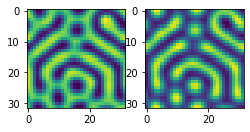

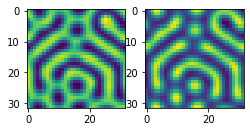

In [36]:
start = 0
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, -1].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, -1].reshape((x_size,y_size)))
plt.show()



In [37]:
T

32

In [50]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = 500#-1
t_test = 200000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [51]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00418474
Loss_s : 0.07617440
Loss   : 822.77679443


In [52]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

731.8449278847592
90.85147352947732


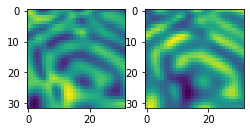

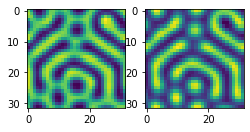

In [53]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()